In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
!pip install pyswarms imbalanced-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.4 MB/s eta 0:00:00


In [ ]:
# Step 1: Install required library
!pip install --upgrade gdown

# Step 2: Download file using gdown
import gdown

file_id = "1t0mqjuEHOu_WZWh6wI_As1KvdZWHixHv"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output="dataset.csv", quiet=False)

# Step 3: Load it into pandas
import pandas as pd

df = pd.read_csv("dataset.csv", low_memory=False)
print(df.shape)
df.head()


Downloading...
From (original): https://drive.google.com/uc?id=1t0mqjuEHOu_WZWh6wI_As1KvdZWHixHv
From (redirected): https://drive.google.com/uc?id=1t0mqjuEHOu_WZWh6wI_As1KvdZWHixHv&confirm=t&uuid=6c18c933-91c5-48a5-88bc-9f6a3bb3ff18
To: /content/dataset.csv
100%|██████████| 435M/435M [00:03<00:00, 122MB/s]


(9446350, 10)


,protocol,flow_duration,src_bytes,dst_bytes,dst_port,total_fwd_pkts,total_bwd_pkts,flow_bytes_s,flow_pkts_s,attack_type
0,udp,0.001055,132.0,164.0,53,NaN,NaN,NaN,NaN,NaN
1,udp,0.036133,528.0,304.0,1024,NaN,NaN,NaN,NaN,NaN
2,udp,0.001119,146.0,178.0,53,NaN,NaN,NaN,NaN,NaN
3,udp,0.001209,132.0,164.0,53,NaN,NaN,NaN,NaN,NaN
4,udp,0.001169,146.0,178.0,53,NaN,NaN,NaN,NaN,NaN


In [ ]:
!pip install imbalanced-learn

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Dataset Overview: Display basic statistics and structure
print("Dataset Shape: ", df.shape)
print("\nDataset Info:")
print(df.info())

print("\nDataset Description (First 5 rows):")
print(df.head())


Dataset Shape:  (9446350, 10)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9446350 entries, 0 to 9446349
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   protocol        object 
 1   flow_duration   object 
 2   src_bytes       float64
 3   dst_bytes       float64
 4   dst_port        object 
 5   total_fwd_pkts  object 
 6   total_bwd_pkts  object 
 7   flow_bytes_s    object 
 8   flow_pkts_s     object 
 9   attack_type     object 
dtypes: float64(2), object(8)
memory usage: 720.7+ MB
None

Dataset Description (First 5 rows):
  protocol flow_duration  src_bytes  dst_bytes dst_port total_fwd_pkts  \
0      udp      0.001055      132.0      164.0       53            NaN   
1      udp      0.036133      528.0      304.0     1024            NaN   
2      udp      0.001119      146.0      178.0       53            NaN   
3      udp      0.001209      132.0      164.0       53            NaN   
4      udp      0.001169    

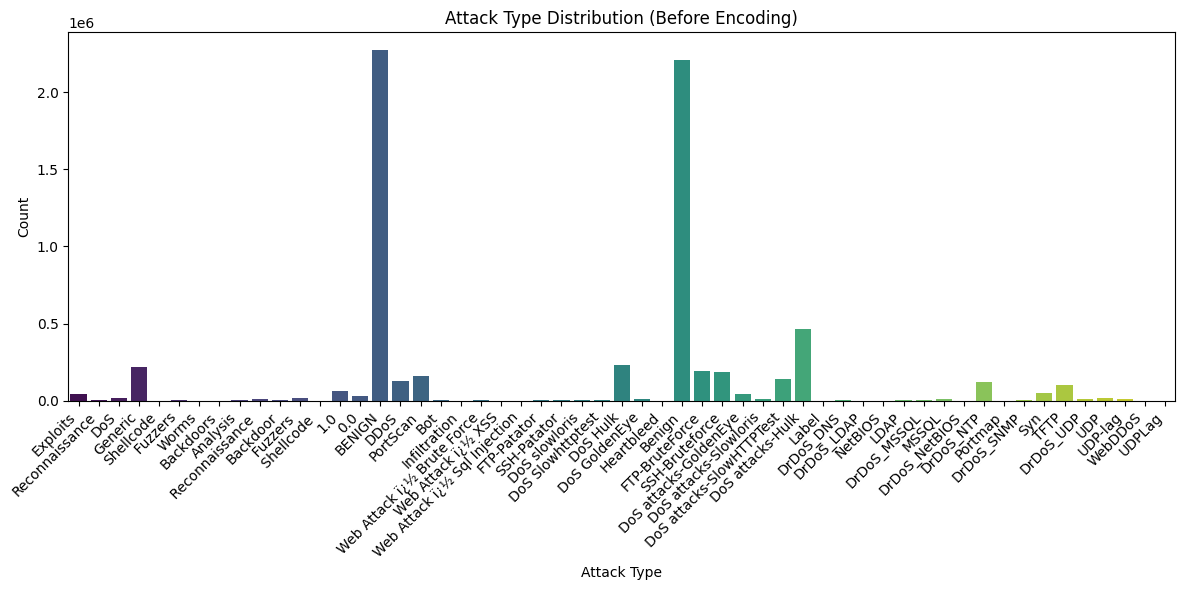

In [ ]:
# Plot the distribution of attack types (before encoding)
plt.figure(figsize=(12, 6))
sns.countplot(x='attack_type', data=df, palette='viridis')
plt.title('Attack Type Distribution (Before Encoding)')
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('dataset.csv', low_memory=False)

# Check missing values before handling
missing_before = df.isnull().sum()

# Visualization: Missing values BEFORE handling
missing_before.plot(kind='bar', figsize=(10, 5), color='salmon')
plt.title('Missing Values Per Feature (Before Handling)')
plt.xlabel('Features')
plt.ylabel('Count of Missing Values')
plt.show()

# Handling missing values by median imputation (numeric) and mode (categorical)
for column in df.columns:
    if df[column].dtype == 'float64' or df[column].dtype == 'int64':
        median_val = df[column].median()
        df[column].fillna(median_val, inplace=True)
    else:
        mode_val = df[column].mode()[0]
        df[column].fillna(mode_val, inplace=True)

# Verify missing values after handling
missing_after = df.isnull().sum()

# Visualization: Missing values AFTER handling
missing_after.plot(kind='bar', figsize=(10, 5), color='lightgreen')
plt.title('Missing Values Per Feature (After Handling)')
plt.xlabel('Features')
plt.ylabel('Count of Missing Values')
plt.show()


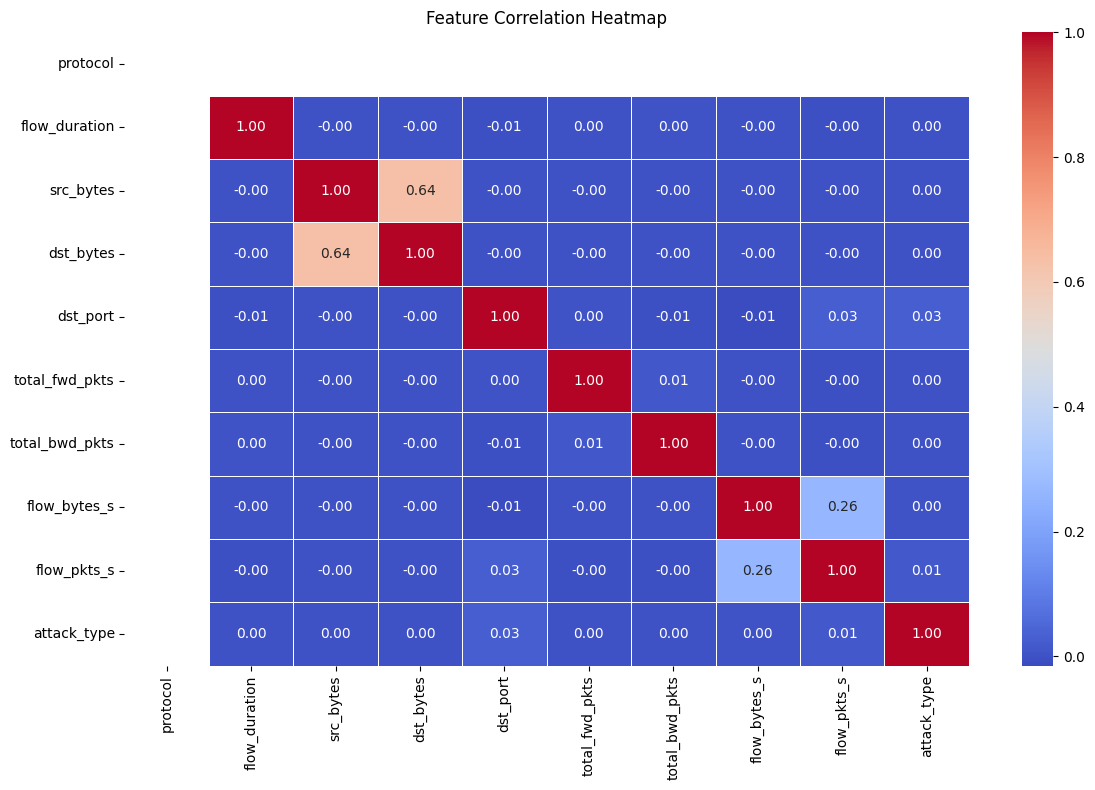

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation Heatmap of the features (numeric-like features)
plt.figure(figsize=(12, 8))

# Select columns that contain numeric values (even if mixed with objects or NaNs)
numeric_cols = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col]) or pd.api.types.is_object_dtype(df[col])]
numeric_df = df[numeric_cols]

# Convert numeric-like columns to numeric type, handling errors
for col in numeric_df.columns:
    numeric_df[col] = pd.to_numeric(numeric_df[col], errors='coerce')

# Fill NaNs with median for numeric columns
numeric_df = numeric_df.fillna(numeric_df.median())

# Create the correlation heatmap
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()


Feature Distribution:



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your dataset is in 'dataset.csv'
df = pd.read_csv('/content/dataset.csv')

# Take a random sample of 10,000 data points for faster plotting
df_sample = df.sample(n=10000, random_state=42)

# Plot distribution of 'flow_duration' from the sampled data
plt.figure(figsize=(12, 6))
sns.histplot(df_sample['flow_duration'], kde=True, color='skyblue')
plt.title('Distribution of Flow Duration (Sampled Data)')
plt.xlabel('Flow Duration (Scaled)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Plot distribution of 'src_bytes' from the sampled data
plt.figure(figsize=(12, 6))
sns.histplot(df_sample['src_bytes'], kde=True, color='orange')
plt.title('Distribution of Source Bytes (Sampled Data)')
plt.xlabel('Source Bytes (Scaled)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7d142c4cf240> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7d142c4ccb80> (for post_execute):


KeyboardInterrupt: 

Class Imbalance

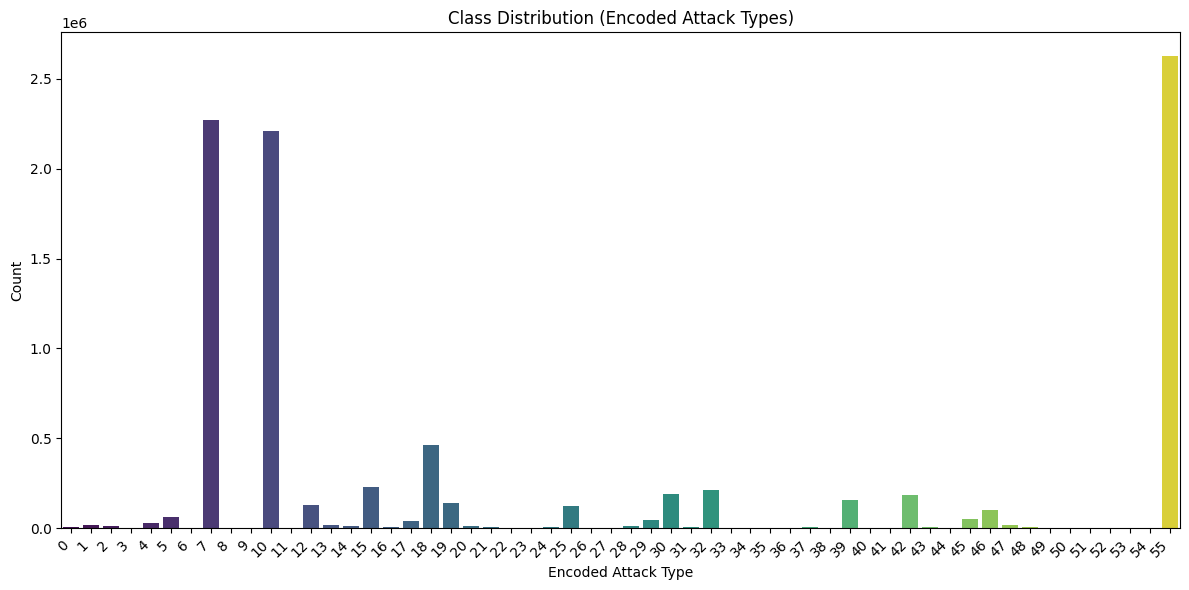

In [ ]:
# Plotting class distribution to visualize imbalance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder # Make sure this is imported

# Assuming your dataset is in 'dataset.csv'
df = pd.read_csv('/content/dataset.csv')

# ----> Convert 'attack_type' column to string type before encoding
df['attack_type'] = df['attack_type'].astype(str)

# Check if 'attack_label_enc' column exists. If not, create it.
if 'attack_label_enc' not in df.columns:
    label_encoder = LabelEncoder()  # Initialize LabelEncoder
    df['attack_label_enc'] = label_encoder.fit_transform(df['attack_type']) # Assuming you have 'attack_type' column

plt.figure(figsize=(12, 6))
sns.countplot(x='attack_label_enc', data=df, palette='viridis')
plt.title('Class Distribution (Encoded Attack Types)')
plt.xlabel('Encoded Attack Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

 Pairplot or Scatterplot Matrix

KeyboardInterrupt: 

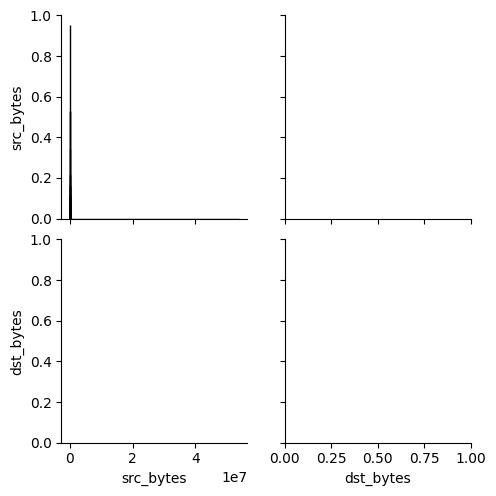

In [ ]:
# Pairplot to show relationships between numeric features
sns.pairplot(df[['flow_duration', 'src_bytes', 'dst_bytes', 'total_fwd_pkts', 'total_bwd_pkts']])
plt.suptitle('Pairplot of Key Features', y=1.02)
plt.tight_layout()
plt.show()


Attack Types Before and After Encoding

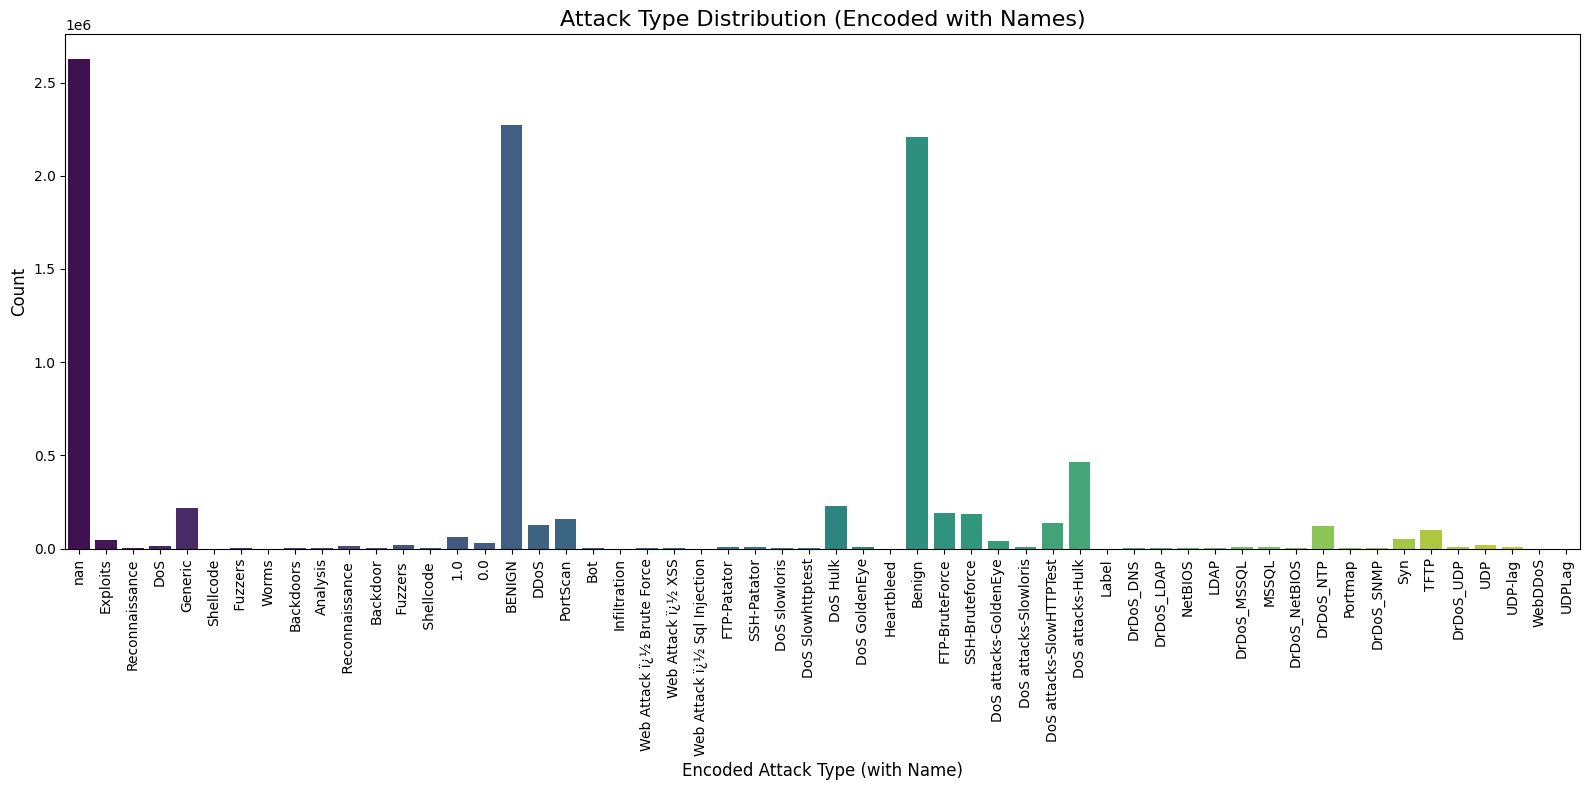

In [ ]:
# Increase figure size and rotate x-axis labels for better readability
plt.figure(figsize=(16, 8))

# Plot the attack type distribution with improved readability
sns.countplot(x='attack_type', data=df, palette='viridis')

# Rotate x-axis labels to avoid overlapping
plt.xticks(rotation=90)

# Set the title and labels
plt.title('Attack Type Distribution (Encoded with Names)', fontsize=16)
plt.xlabel('Encoded Attack Type (with Name)', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


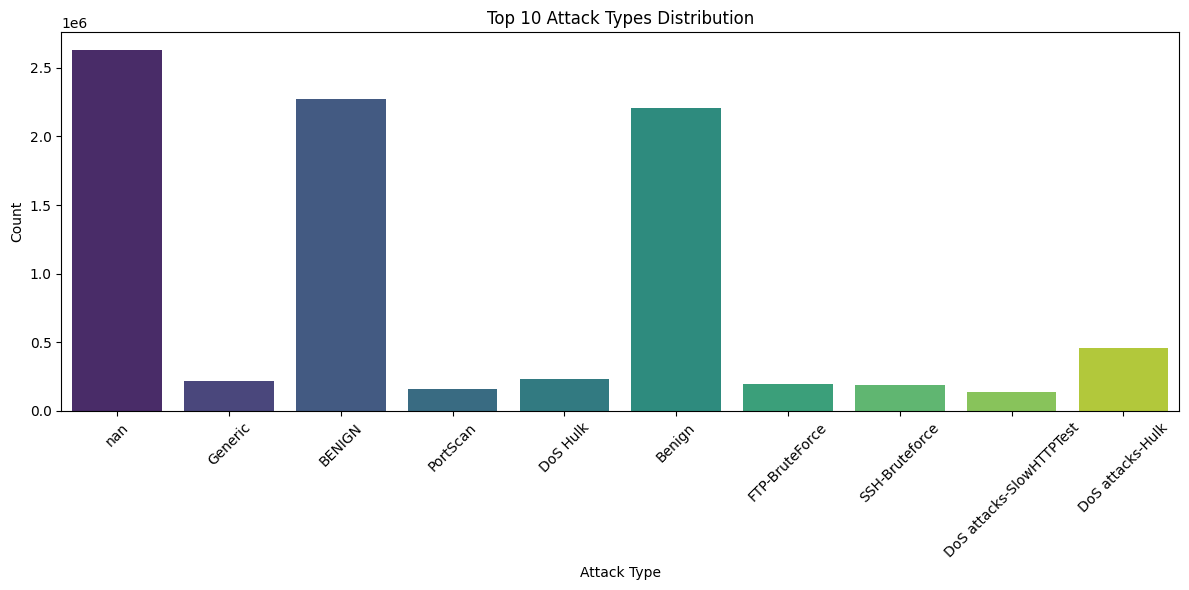

In [ ]:
# Limit to top N most frequent attack types (for example, top 10)
top_n = 10
top_attack_types = df['attack_type'].value_counts().nlargest(top_n).index

# Filter the DataFrame to include only the top N attack types
df_top_n = df[df['attack_type'].isin(top_attack_types)]

# Plot the distribution of the top N attack types
plt.figure(figsize=(12, 6))
sns.countplot(x='attack_type', data=df_top_n, palette='viridis')
plt.xticks(rotation=45)
plt.title(f'Top {top_n} Attack Types Distribution')
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


Step 1: Data Preprocessing

Handle Missing Values:

In [ ]:
# Impute missing values for numerical columns with median
df['total_fwd_pkts'] = pd.to_numeric(df['total_fwd_pkts'], errors='coerce')
df['total_bwd_pkts'] = pd.to_numeric(df['total_bwd_pkts'], errors='coerce')
df['flow_bytes_s'] = pd.to_numeric(df['flow_bytes_s'], errors='coerce')
df['flow_pkts_s'] = pd.to_numeric(df['flow_pkts_s'], errors='coerce')

df['total_fwd_pkts'].fillna(df['total_fwd_pkts'].median(), inplace=True)
df['total_bwd_pkts'].fillna(df['total_bwd_pkts'].median(), inplace=True)
df['flow_bytes_s'].fillna(df['flow_bytes_s'].median(), inplace=True)
df['flow_pkts_s'].fillna(df['flow_pkts_s'].median(), inplace=True)

# Impute missing values for categorical columns (attack_type) with the mode
df['attack_type'].fillna(df['attack_type'].mode()[0], inplace=True)

# Check for any remaining missing values
print(df.isna().sum())


protocol          6695260
flow_duration      287421
src_bytes         6833426
dst_bytes         7344361
dst_port           718791
total_fwd_pkts          0
total_bwd_pkts          0
flow_bytes_s            0
flow_pkts_s             0
attack_type             0
dtype: int64


Impute Missing Values

In [ ]:
# Impute missing numeric columns with the median
df['total_fwd_pkts'] = pd.to_numeric(df['total_fwd_pkts'], errors='coerce')  # Convert to numeric
df['total_bwd_pkts'] = pd.to_numeric(df['total_bwd_pkts'], errors='coerce')  # Convert to numeric
df['flow_bytes_s'] = pd.to_numeric(df['flow_bytes_s'], errors='coerce')  # Convert to numeric
df['flow_pkts_s'] = pd.to_numeric(df['flow_pkts_s'], errors='coerce')  # Convert to numeric

# Fill NaN values with the median of each column
df['total_fwd_pkts'].fillna(df['total_fwd_pkts'].median(), inplace=True)
df['total_bwd_pkts'].fillna(df['total_bwd_pkts'].median(), inplace=True)
df['flow_bytes_s'].fillna(df['flow_bytes_s'].median(), inplace=True)
df['flow_pkts_s'].fillna(df['flow_pkts_s'].median(), inplace=True)

# Check if any NaN values remain
print(df.isna().sum())


protocol          6695260
flow_duration      287421
src_bytes         6833426
dst_bytes         7344361
dst_port           718791
total_fwd_pkts          0
total_bwd_pkts          0
flow_bytes_s            0
flow_pkts_s             0
attack_type             0
dtype: int64


In [ ]:
# Replace zero values with NaN for the relevant columns
df[['total_fwd_pkts', 'total_bwd_pkts', 'flow_bytes_s', 'flow_pkts_s']] = df[['total_fwd_pkts', 'total_bwd_pkts', 'flow_bytes_s', 'flow_pkts_s']].replace(0, float('nan'))

# Check the dataset after replacing zeros with NaN
print(df.isna().sum())


protocol          6695260
flow_duration      287421
src_bytes         6833426
dst_bytes         7344361
dst_port           718791
total_fwd_pkts    1316089
total_bwd_pkts    2215160
flow_bytes_s      1695153
flow_pkts_s             0
attack_type             0
dtype: int64


In [ ]:
# Convert numeric columns to float64 (if not already)
df['flow_duration'] = pd.to_numeric(df['flow_duration'], errors='coerce')
df['total_fwd_pkts'] = pd.to_numeric(df['total_fwd_pkts'], errors='coerce')
df['total_bwd_pkts'] = pd.to_numeric(df['total_bwd_pkts'], errors='coerce')
df['flow_bytes_s'] = pd.to_numeric(df['flow_bytes_s'], errors='coerce')
df['flow_pkts_s'] = pd.to_numeric(df['flow_pkts_s'], errors='coerce')

# Check the data types to confirm the conversion
print(df.dtypes)


protocol           object
flow_duration     float64
src_bytes         float64
dst_bytes         float64
dst_port           object
total_fwd_pkts    float64
total_bwd_pkts    float64
flow_bytes_s      float64
flow_pkts_s       float64
attack_type        object
dtype: object


 Feature Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode 'protocol' and 'attack_type' columns
df['protocol'] = label_encoder.fit_transform(df['protocol'])
df['attack_type'] = label_encoder.fit_transform(df['attack_type'])

# Check the first few rows of the encoded data
print(df[['protocol', 'attack_type']].head())


Feature Scaling

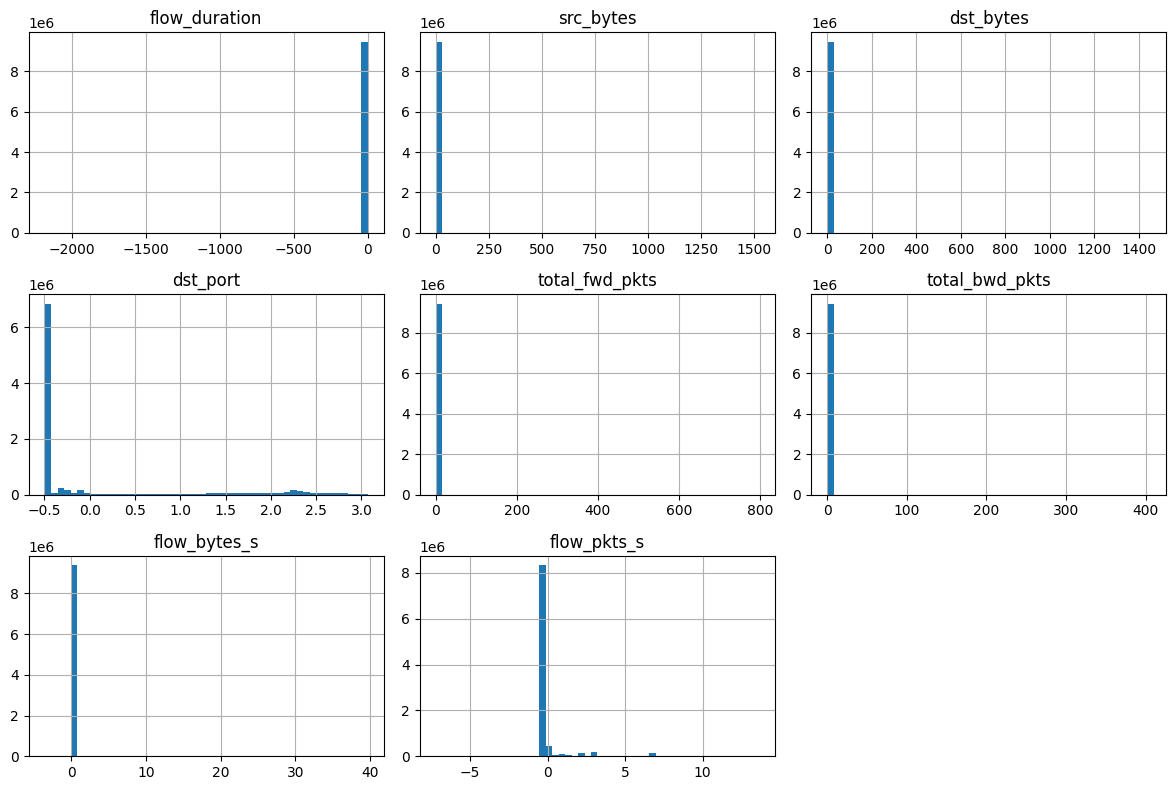

In [ ]:
# Check the distribution of a few features to ensure proper scaling
df[numerical_features] = df[['flow_duration', 'src_bytes', 'dst_bytes', 'dst_port',
                              'total_fwd_pkts', 'total_bwd_pkts', 'flow_bytes_s', 'flow_pkts_s']]

# Plot histograms for a few scaled features
df[numerical_features].hist(figsize=(12, 8), bins=50)
plt.tight_layout()
plt.show()


<ipython-input-5-1ca6710854fe>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='protocol', data=df, palette='viridis')


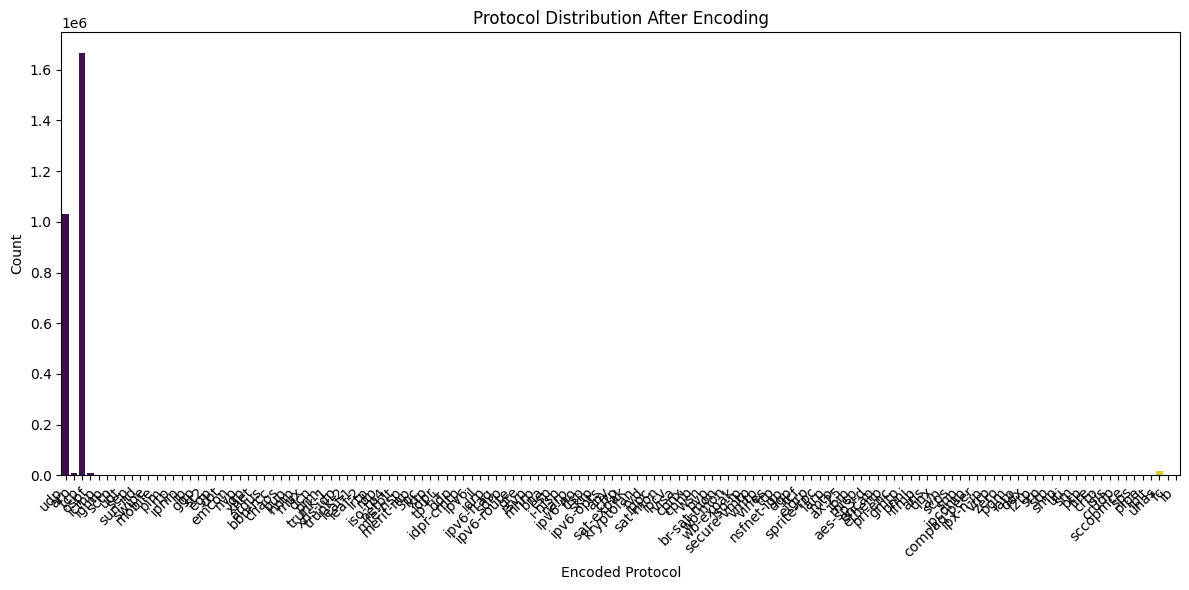

<ipython-input-5-1ca6710854fe>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='attack_type', data=df, palette='viridis')


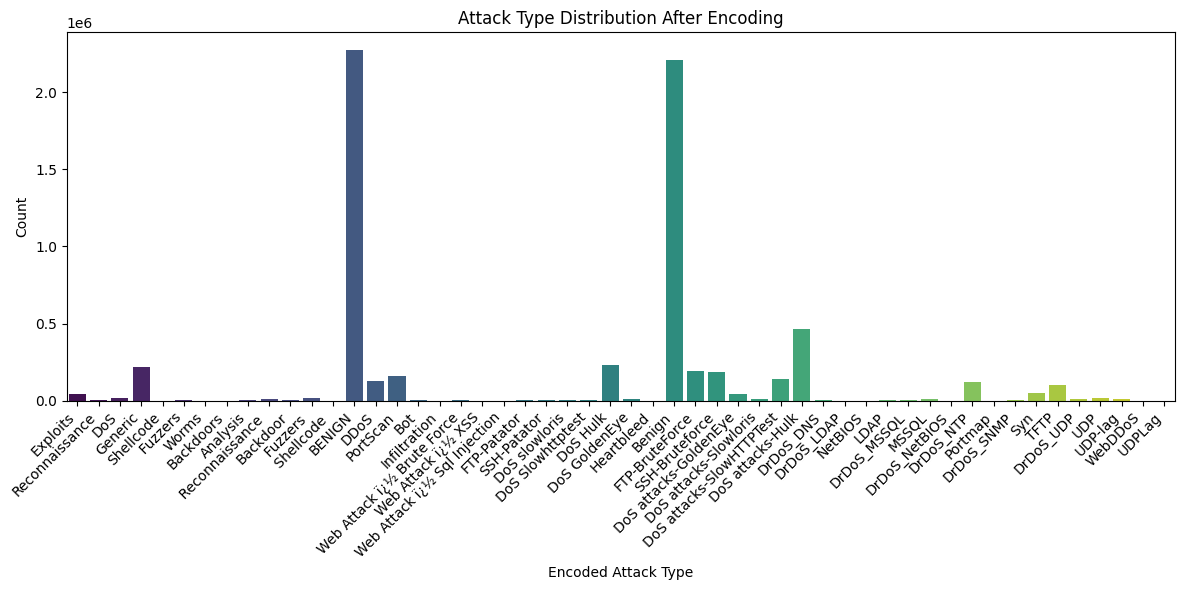

In [ ]:
# Plotting Protocol Distribution After Encoding with x-axis label adjustments
plt.figure(figsize=(12, 6))
sns.countplot(x='protocol', data=df, palette='viridis')
plt.title('Protocol Distribution After Encoding')
plt.xlabel('Encoded Protocol')
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Tight layout to ensure labels fit within the figure
plt.tight_layout()
plt.show()

# Plotting Attack Type Distribution After Encoding with x-axis label adjustments
plt.figure(figsize=(12, 6))
sns.countplot(x='attack_type', data=df, palette='viridis')
plt.title('Attack Type Distribution After Encoding')
plt.xlabel('Encoded Attack Type')
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Tight layout to ensure labels fit within the figure
plt.tight_layout()
plt.show()


<ipython-input-7-95f72229117b>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='protocol', data=df_top_protocols, palette='viridis')


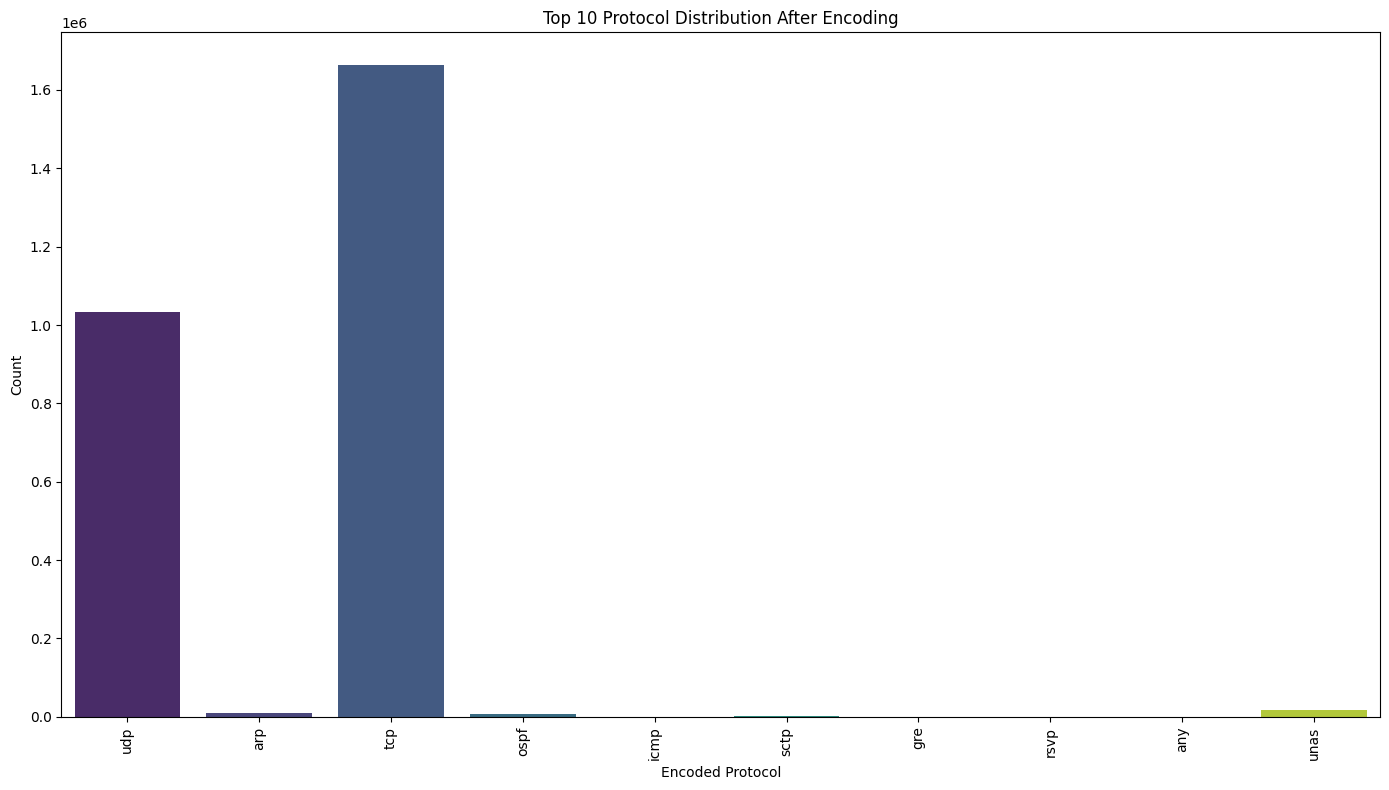

In [ ]:
# Limit to top N most frequent categories (e.g., top 10)
top_protocols = df['protocol'].value_counts().nlargest(10).index
df_top_protocols = df[df['protocol'].isin(top_protocols)]

# Plot the top 10 most frequent protocols
plt.figure(figsize=(14, 8))
sns.countplot(x='protocol', data=df_top_protocols, palette='viridis')
plt.title('Top 10 Protocol Distribution After Encoding')
plt.xlabel('Encoded Protocol')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
# Convert numerical columns to numeric type, handling errors (non-numeric values)
numerical_columns = ['flow_duration', 'src_bytes', 'dst_bytes', 'dst_port',
                     'total_fwd_pkts', 'total_bwd_pkts', 'flow_bytes_s', 'flow_pkts_s']

# Convert the numerical columns to numeric, forcing errors to NaN
for col in numerical_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Verify the conversion
print(df[numerical_columns].dtypes)


flow_duration     float64
src_bytes         float64
dst_bytes         float64
dst_port          float64
total_fwd_pkts    float64
total_bwd_pkts    float64
flow_bytes_s      float64
flow_pkts_s       float64
dtype: object


In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer

# List of columns where zeroes need to be replaced with NaN
columns_to_replace = ['flow_duration', 'src_bytes', 'dst_bytes', 'dst_port',
                      'total_fwd_pkts', 'total_bwd_pkts', 'flow_bytes_s', 'flow_pkts_s']

# Replace zero values with NaN for the specified columns
df[columns_to_replace] = df[columns_to_replace].replace(0, float('nan'))

# Check how many NaN values there are in each column
print(df[columns_to_replace].isna().sum())


flow_duration      370525
src_bytes         6833426
dst_bytes         7344361
dst_port           805527
total_fwd_pkts    4354601
total_bwd_pkts    5253672
flow_bytes_s      4740863
flow_pkts_s       3038512
dtype: int64


In [ ]:
import numpy as np

# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Check how many NaN values there are in the relevant columns
print(df[columns_to_replace].isna().sum())


flow_duration      370525
src_bytes         6833426
dst_bytes         7344361
dst_port           805527
total_fwd_pkts    4354601
total_bwd_pkts    5253672
flow_bytes_s      4747025
flow_pkts_s       3053230
dtype: int64


In [ ]:
from sklearn.impute import SimpleImputer

# Initialize the imputer with median strategy
imputer = SimpleImputer(strategy='median')

# Impute missing numeric columns
df[columns_to_replace] = imputer.fit_transform(df[columns_to_replace])

# Verify that there are no missing values remaining
print(df[columns_to_replace].isna().sum())  # Should return zero if no NaN values remain


flow_duration     0
src_bytes         0
dst_bytes         0
dst_port          0
total_fwd_pkts    0
total_bwd_pkts    0
flow_bytes_s      0
flow_pkts_s       0
dtype: int64


In [ ]:
### Replace Zeroes with the Median for Numerical Columns

import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming your DataFrame is already loaded as df

# Step 1: Replace zero values with NaN for relevant columns
columns_to_replace = ['flow_duration', 'src_bytes', 'dst_bytes', 'dst_port',
                      'total_fwd_pkts', 'total_bwd_pkts', 'flow_bytes_s', 'flow_pkts_s',
                      'attack_type']

# Replace zero values with NaN for the specified columns
df[columns_to_replace] = df[columns_to_replace].replace(0, float('nan'))

# Step 2: Impute missing values
# Impute numeric columns with median (for zero-replacement)
imputer = SimpleImputer(strategy='median')
df[['flow_duration', 'src_bytes', 'dst_bytes', 'dst_port',
    'total_fwd_pkts', 'total_bwd_pkts', 'flow_bytes_s', 'flow_pkts_s']] = imputer.fit_transform(df[['flow_duration', 'src_bytes', 'dst_bytes', 'dst_port',
                                                                                                     'total_fwd_pkts', 'total_bwd_pkts', 'flow_bytes_s', 'flow_pkts_s']])

# Impute categorical columns (e.g., attack_type) with the mode (most frequent)
df['attack_type'] = df['attack_type'].fillna(df['attack_type'].mode()[0])

# Step 3: Encode categorical features
label_encoder = LabelEncoder()

# Encode 'protocol' and 'attack_type' columns
df['protocol'] = label_encoder.fit_transform(df['protocol'])
df['attack_type'] = label_encoder.fit_transform(df['attack_type'])

# Step 4: Verify the data integrity (check for missing values and data types)
print(df.isna().sum())  # Ensure no missing values remain
print(df.dtypes)  # Ensure proper data types (numeric for features)

# Step 5: Train-Test Split (70% Train, 15% Validation, 15% Test)
X = df.drop(columns=['attack_type'])  # Features: All columns except 'attack_type'
y = df['attack_type']  # Target: attack_type (encoded)

# First split: 70% training, 30% for validation and testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Second split: 50% of the 30% for validation, 50% for testing (i.e., 15% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Check the shapes of the splits
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

# Step 6: Feature Scaling (Standardization)
scaler = StandardScaler()

# List of numerical columns to scale
numerical_features = ['flow_duration', 'src_bytes', 'dst_bytes', 'dst_port',
                      'total_fwd_pkts', 'total_bwd_pkts', 'flow_bytes_s', 'flow_pkts_s']

# Apply scaling to the numerical features
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_val[numerical_features] = scaler.transform(X_val[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Check the scaled features
print(X_train[numerical_features].describe())



ValueError: Cannot use median strategy with non-numeric data:
could not convert string to float: 'Flow Duration'

In [ ]:
# Save the preprocessed dataframe (with encoding and scaling applied) to a CSV file
df.to_csv('preprocessed_dataset.csv', index=False)

# If you'd like to save a specific version of the dataset (e.g., only the features or target)
df[['protocol', 'flow_duration', 'src_bytes', 'dst_bytes', 'attack_type']].to_csv('encoded_scaled_dataset.csv', index=False)


In [ ]:
# Load the preprocessed data from the saved CSV file
df = pd.read_csv('preprocessed_dataset.csv')

# Check the loaded data
print(df.head())


   protocol  flow_duration  src_bytes  dst_bytes  dst_port  total_fwd_pkts  \
0       120       0.001055      132.0      164.0      53.0             3.0   
1       120       0.036133      528.0      304.0    1024.0             3.0   
2       120       0.001119      146.0      178.0      53.0             3.0   
3       120       0.001209      132.0      164.0      53.0             3.0   
4       120       0.001169      146.0      178.0      53.0             3.0   

   total_bwd_pkts  flow_bytes_s  flow_pkts_s  attack_type  
0             2.0    615.452221   116.314109           50  
1             2.0    615.452221   116.314109           50  
2             2.0    615.452221   116.314109           50  
3             2.0    615.452221   116.314109           50  
4             2.0    615.452221   116.314109           50  


In [ ]:
# Apply One-Hot Encoding to the 'protocol' column
df = pd.get_dummies(df, columns=['protocol'], drop_first=True)  # drop_first=True to avoid multicollinearity

# Check the shape of the dataset after One-Hot Encoding
print(f"Shape of the dataset after One-Hot Encoding: {df.shape}")


Shape of the dataset after One-Hot Encoding: (9158928, 144)


In [ ]:
# Check the first few rows to verify One-Hot Encoding
print(df.head())


   flow_duration  src_bytes  dst_bytes  dst_port  total_fwd_pkts  \
0       0.001055      132.0      164.0      53.0             3.0   
1       0.036133      528.0      304.0    1024.0             3.0   
2       0.001119      146.0      178.0      53.0             3.0   
3       0.001209      132.0      164.0      53.0             3.0   
4       0.001169      146.0      178.0      53.0             3.0   

   total_bwd_pkts  flow_bytes_s  flow_pkts_s  attack_type  protocol_1  ...  \
0             2.0    615.452221   116.314109           50       False  ...   
1             2.0    615.452221   116.314109           50       False  ...   
2             2.0    615.452221   116.314109           50       False  ...   
3             2.0    615.452221   116.314109           50       False  ...   
4             2.0    615.452221   116.314109           50       False  ...   

   protocol_126  protocol_127  protocol_128  protocol_129  protocol_130  \
0         False         False         False    

In [ ]:
# Plot the distribution of 'flow_duration'
plt.figure(figsize=(12, 6))
sns.histplot(df['flow_duration'], kde=True, color='skyblue')
plt.title('Distribution of Flow Duration')
plt.xlabel('Flow Duration')
plt.ylabel('Frequency')
plt.tight_layout()  # Adjust layout
plt.show()


In [ ]:
# Save the final encoded DataFrame to a new CSV file
df_encoded.to_csv('/content/encoded_scaled_dataset.csv', index=False)

# Verify that the file has been saved
print("✅ Encoded dataset saved as 'encoded_data.csv'")


OSError: Cannot save file into a non-existent directory: '/path/to/save'

Train-Test Split

Missing Data Visualization (After Imputation)

Attack Type Distribution (After Encoding)

Feature Distribution (After Scaling)

Correlation Heatmap (After Scaling)

Pairplot (After Scaling)

In [ ]:
# Load
df = pd.read_csv("dataset.csv", low_memory=False)

# Fill NaNs with median for numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill attack_type with mode (for label)
df['attack_type'] = df['attack_type'].fillna(df['attack_type'].mode()[0])

# Encode categorical: protocol + attack_type
le_protocol = LabelEncoder()
df['protocol'] = le_protocol.fit_transform(df['protocol'])

le_target = LabelEncoder()
df['label_enc'] = le_target.fit_transform(df['attack_type'])

# Features & target
X = df.drop(columns=['attack_type', 'label_enc'], errors='ignore')
y = df['label_enc']


In [ ]:
# Drop classes with fewer than 2 samples
class_counts = df['label_enc'].value_counts()
valid_classes = class_counts[class_counts >= 2].index
df = df[df['label_enc'].isin(valid_classes)]

# Redefine X and y
X = df.drop(columns=['attack_type', 'label_enc'])
y = df['label_enc']


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


In [ ]:
print("Label distribution after cleaning:")
print(y.value_counts())


Label distribution after cleaning:
label_enc
7     4900213
10    2208306
18     461912
15     231073
32     215481
30     193360
42     187589
39     158930
19     139890
12     128027
25     121368
46      98917
5       60112
45      49373
29      44525
17      41508
4       30000
1       19195
47      18090
13      16353
2       12228
20      10990
28      10420
14      10293
48       8872
37       8523
31       7938
24       6212
43       5897
21       5796
16       5499
0        5051
22       3669
27       2717
6        2677
11       1966
35       1906
8        1795
41       1759
50       1507
23       1440
3        1288
40        685
52        652
38        644
26        598
9         534
44        223
54        174
49         55
53         51
34         36
51         21
33         11
Name: count, dtype: int64


In [ ]:
# Remove classes with fewer than 100 samples
min_samples = 100
class_counts = df['label_enc'].value_counts()
valid_classes = class_counts[class_counts >= min_samples].index
df = df[df['label_enc'].isin(valid_classes)]

# Redefine X and y
X = df.drop(columns=['attack_type', 'label_enc'])
y = df['label_enc']


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"Train: {len(X_train)} samples")
print(f"Val:   {len(X_val)} samples")
print(f"Test:  {len(X_test)} samples")


Train: 6612322 samples
Val:   1416926 samples
Test:  1416927 samples


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

num_cols = [
    'flow_duration', 'src_bytes', 'dst_bytes', 'dst_port',
    'total_fwd_pkts', 'total_bwd_pkts', 'flow_bytes_s', 'flow_pkts_s'
]
cat_cols = ['protocol']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols),
        # use sparse_output instead of sparse
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ],
    remainder='drop'
)


In [ ]:
from sklearn.preprocessing import OneHotEncoder
import inspect

# Figure out which argument name to use
sig = inspect.signature(OneHotEncoder.__init__)
if 'sparse' in sig.parameters:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
else:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([...]), num_cols),
        ('cat', ohe, cat_cols)
    ],
    remainder='drop'
)


In [ ]:
!pip install pyswarms


In [ ]:
print(df.columns.tolist())


['protocol', 'flow_duration', 'src_bytes', 'dst_bytes', 'dst_port', 'total_fwd_pkts', 'total_bwd_pkts', 'flow_bytes_s', 'flow_pkts_s', 'attack_type', 'label_enc']


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode attack_type into attack_label_enc
le = LabelEncoder()
df['attack_label_enc'] = le.fit_transform(df['attack_type'])

# Optional: Save the encoder for inverse transform later
import joblib
joblib.dump(le, '/content/label_encoder.pkl')

# Check result
print(df[['attack_type', 'attack_label_enc']].drop_duplicates().sort_values('attack_label_enc'))


                        attack_type  attack_label_enc
4990                        Fuzzers                 0
1087283                    Fuzzers                  1
1087268             Reconnaissance                  2
1089647                  Shellcode                  3
2570159                         0.0                 4
2540047                         1.0                 5
80023                      Analysis                 6
0                            BENIGN                 7
1087270                    Backdoor                 8
17604                     Backdoors                 9
5869253                      Benign                10
3574794                         Bot                11
3057393                        DDoS                12
57                              DoS                13
5507583               DoS GoldenEye                14
5251410                    DoS Hulk                15
5245825            DoS Slowhttptest                16
6917872       DoS attacks-Go

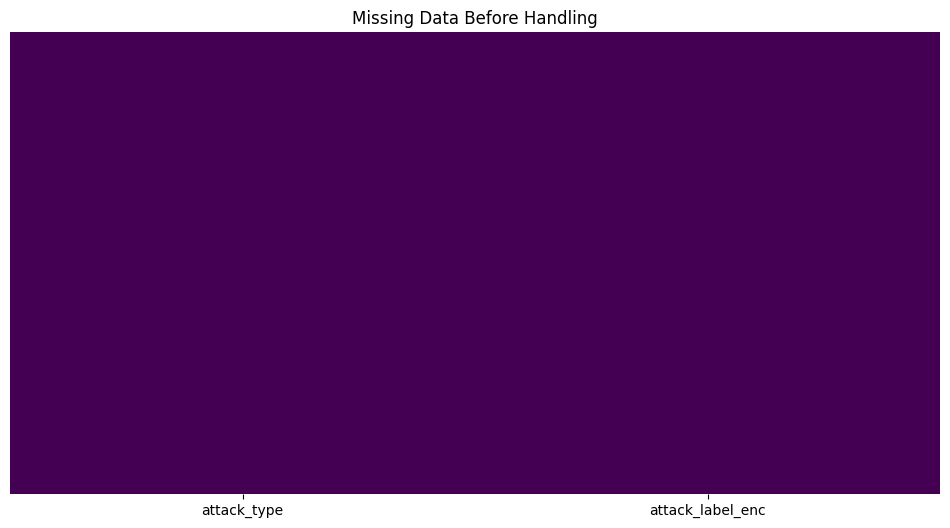

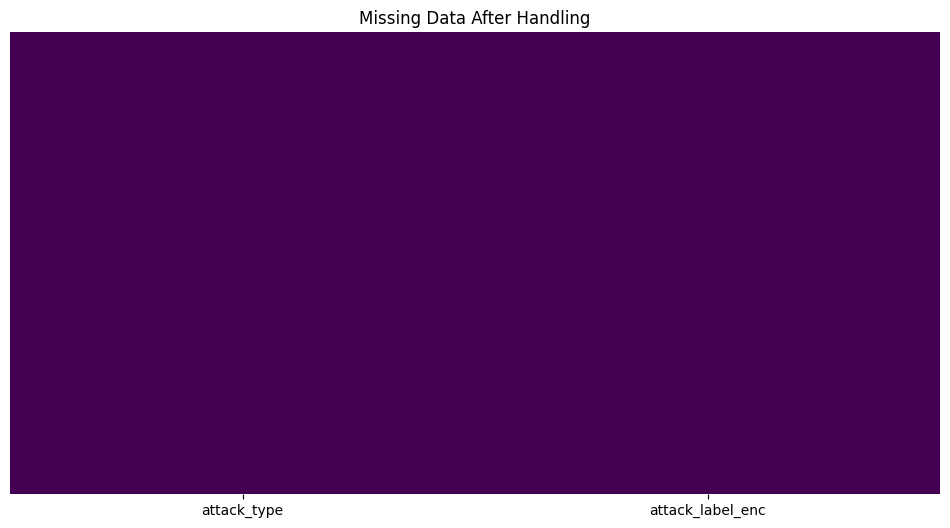

In [ ]:
import seaborn as sns

# Plot missing data before handling
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Data Before Handling')
plt.show()

# Fill missing data (example with median imputation)
# Select numeric columns before calculating the median
numeric_df = df.select_dtypes(include=[np.number])
df[numeric_df.columns] = numeric_df.fillna(numeric_df.median())


# Plot missing data after handling
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Data After Handling')
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

# Plot feature distribution before scaling (for one example feature)
plt.figure(figsize=(12, 6))
sns.histplot(df['src_bytes'], kde=True, color='skyblue', label='Before Scaling')
plt.title('Feature Distribution Before Scaling (src_bytes)')
plt.xlabel('src_bytes')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Feature scaling (StandardScaler)
scaler = StandardScaler()
df['src_bytes_scaled'] = scaler.fit_transform(df[['src_bytes']])

# Plot feature distribution after scaling
plt.figure(figsize=(12, 6))
sns.histplot(df['src_bytes_scaled'], kde=True, color='orange', label='After Scaling')
plt.title('Feature Distribution After Scaling (src_bytes)')
plt.xlabel('src_bytes_scaled')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


KeyError: 'src_bytes'

<Figure size 1200x600 with 0 Axes>

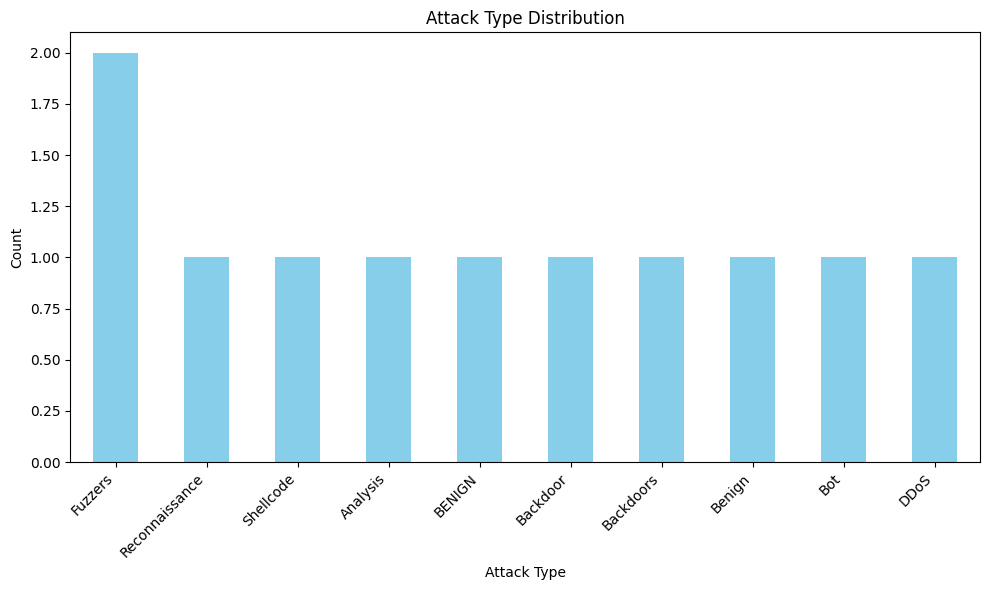

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Example dataframe
data = {
    'attack_type': ['Fuzzers', 'Fuzzers', 'Reconnaissance', 'Shellcode', 'Analysis', 'BENIGN', 'Backdoor', 'Backdoors', 'Benign', 'Bot', 'DDoS'],
    'attack_label_enc': [0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12]
}
df = pd.DataFrame(data)

# Plotting the distribution of attack types
plt.figure(figsize=(10, 6))
df['attack_type'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Attack Type Distribution')
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


 Cleaning the Data:

In [ ]:
df_clean = df[~df['attack_type'].isna()].copy()
df_clean = df_clean[~df_clean['attack_type'].isin(['0.0', '1.0', 'Label'])]


In [ ]:
import pandas as pd
import numpy as np
import joblib  # Import joblib
# Load the dataset
df = pd.read_csv("/content/dataset.csv")  # Adjust the file path if needed


# Load the label encoder using joblib.load
le = joblib.load("/content/label_encoder.pkl")


# Clean the 'attack_type' column: Replace or drop invalid entries like "0.0" and "1.0"
df['attack_type'] = df['attack_type'].replace({"0.0": "Unknown", "1.0": "Unknown", "BENIGN": "Benign"})

# Check for any remaining invalid values or missing data
df['attack_type'].unique()  # This will show all unique values in the 'attack_type' column
df = df[df['attack_type'].notna()]  # Drop rows where 'attack_type' is NaN

# Optionally, you could also drop rows that contain invalid attack types
# df = df[df['attack_type'] != "Unknown"]

# Check the cleaned data
print(df.head())


   protocol flow_duration  src_bytes  dst_bytes dst_port total_fwd_pkts  \
20      udp      0.000021      728.0        0.0    32780            NaN   
21      tcp      0.240139      918.0    25552.0       80            NaN   
22      tcp       2.39039     1362.0      268.0       80            NaN   
39      tcp       0.17519     8168.0      268.0     5555            NaN   
40      tcp        0.1906      844.0      268.0       80            NaN   

   total_bwd_pkts flow_bytes_s flow_pkts_s     attack_type  
20            NaN          NaN         NaN        Exploits  
21            NaN          NaN         NaN        Exploits  
22            NaN          NaN         NaN  Reconnaissance  
39            NaN          NaN         NaN        Exploits  
40            NaN          NaN         NaN        Exploits  


In [ ]:
import pandas as pd

# Load your full dataset
df_full = pd.read_csv('/content/dataset.csv')  # change path if needed

from sklearn.preprocessing import LabelEncoder

# If not already done
if 'attack_label_enc' not in df_full.columns:
    le = LabelEncoder()
    df_full['attack_label_enc'] = le.fit_transform(df_full['attack_type'].astype(str))


In [ ]:
# Impute missing values with the median (more robust than mean) for numeric columns only
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Handle categorical columns separately (e.g., impute with mode)
cat_cols = df.select_dtypes(exclude=[np.number]).columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])  # Use mode for categorical

# Check if there are any missing values left
print(df.isna().sum())


protocol          0
flow_duration     0
src_bytes         0
dst_bytes         0
dst_port          0
total_fwd_pkts    0
total_bwd_pkts    0
flow_bytes_s      0
flow_pkts_s       0
attack_type       0
dtype: int64


In [ ]:
# Ensure 'attack_type' column contains only strings
df['attack_type'] = df['attack_type'].astype(str)

# Initialize the label encoder
label_encoder = LabelEncoder()

# Encode 'protocol' and 'attack_type' columns
df['protocol'] = label_encoder.fit_transform(df['protocol'])
df['attack_type'] = label_encoder.fit_transform(df['attack_type'])

# Check the unique values after encoding
print(df['protocol'].unique())
print(df['attack_type'].unique())



[115 109  75  93  96 106 107  68  77  47  42  29 104  22  10  24  74  40
 125   4   7  12  83  32  70  18  81 112 126 113  62  63  55  86  58  72
  65  64   0 127  36 111  19  37  49  41  38  50  94  53  31  87  66   8
  33  71  51 110  97  52   3  11  89  59  88  48  90  44 119  15  14 124
  84   9 123 122  57  95 120 118 114  73  21 108  23 101  61  69   6  45
  67   2  25  26  80  30  79  39   5  85   1  92 100  43  13  54 121 128
  76  34  20  60 103 105  99 117  98  82  28  16  56  17  91 102  78  46
 116  27  35]
[28 40 12 31 43  0 54  8  6  2  7  1  3 49  5  4  9 11 38 10 33 50 52 51
 30 42 20 15 14 13 32 29 41 16 19 18 17 35 21 22 37 34 23 36 25 24 39 26
 44 45 27 46 47 53 48]


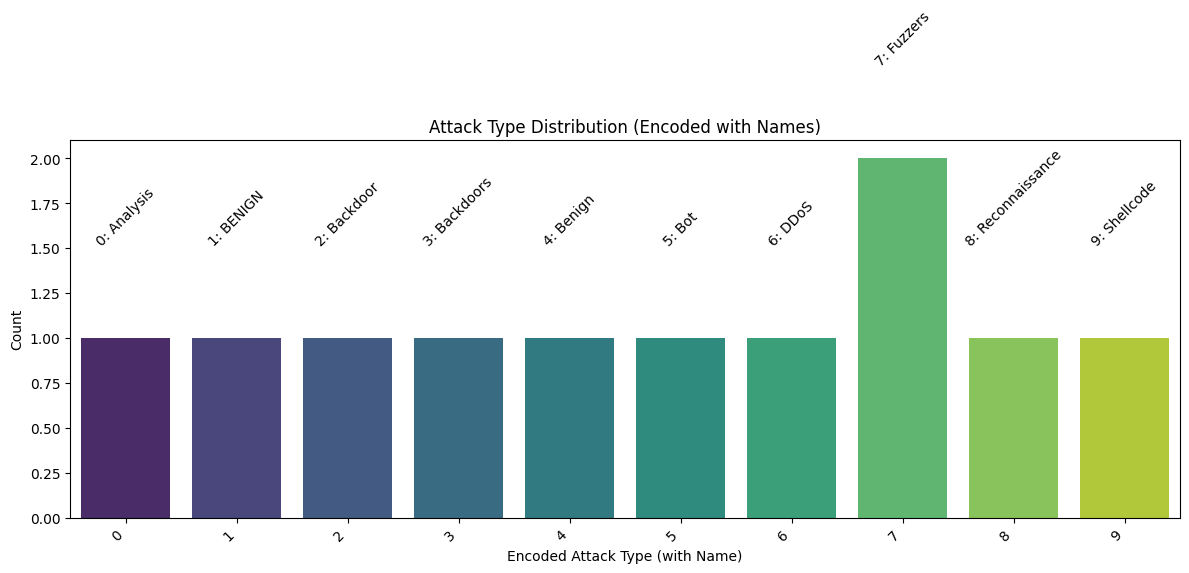

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Sample DataFrame
data = {
    'attack_type': ['Fuzzers', 'Fuzzers', 'Reconnaissance', 'Shellcode', 'Analysis',
                    'BENIGN', 'Backdoor', 'Backdoors', 'Benign', 'Bot', 'DDoS'],
    'attack_label_enc': [0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12]
}
df = pd.DataFrame(data)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode attack_type to numeric labels
df['attack_label_enc'] = label_encoder.fit_transform(df['attack_type'])

# Create a plot with both encoded labels and attack names
plt.figure(figsize=(12, 6))
sns.countplot(x='attack_label_enc', data=df, palette='viridis')

# Add both encoded labels and attack names to the plot
for i, patch in enumerate(plt.gca().patches):
    height = patch.get_height()
    label = label_encoder.inverse_transform([i])[0]  # Get the original label name from the encoding
    plt.text(patch.get_x() + patch.get_width() / 2, height + 0.5, f'{i}: {label}',
             ha='center', va='bottom', rotation=45)

plt.title('Attack Type Distribution (Encoded with Names)')
plt.xlabel('Encoded Attack Type (with Name)')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


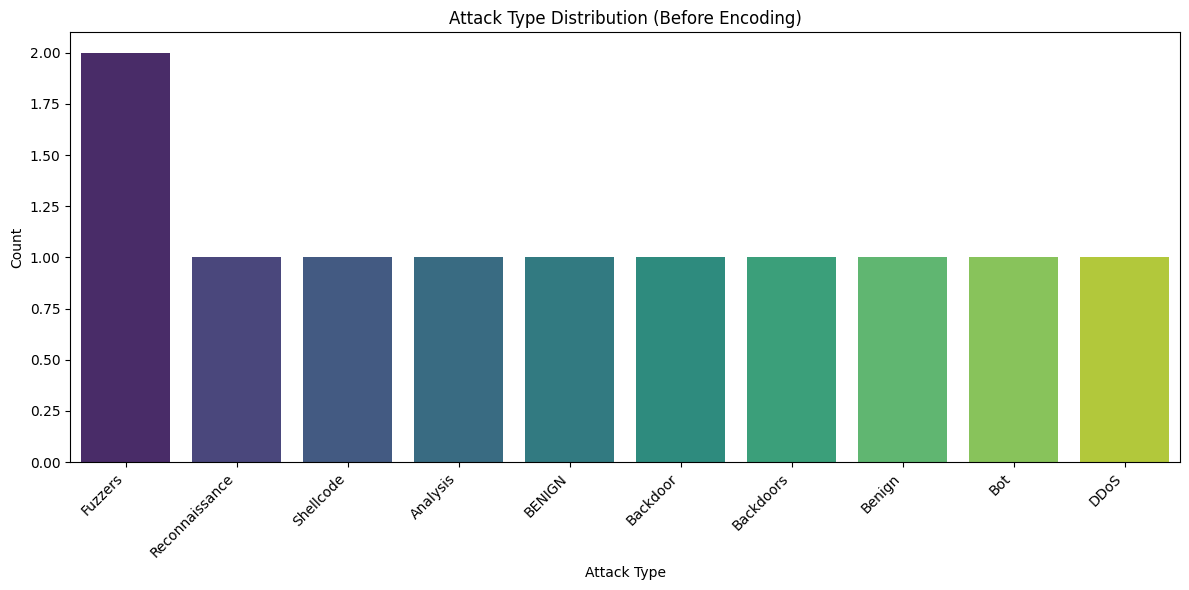

In [ ]:
# Before Encoding: Attack Type Distribution (using the original 'attack_type' column)

plt.figure(figsize=(12, 6))
sns.countplot(x='attack_type', data=df, palette='viridis')
plt.title('Attack Type Distribution (Before Encoding)')
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


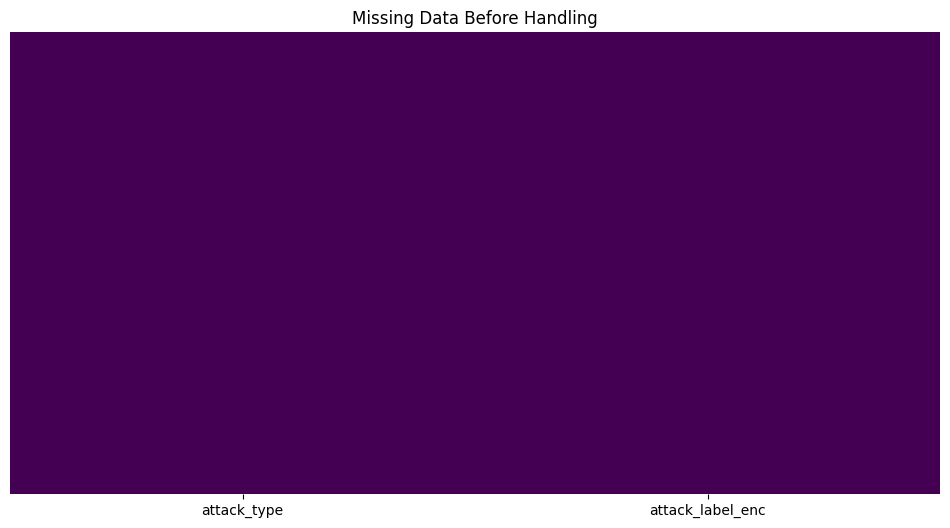

TypeError: Cannot convert [['Fuzzers' 'Fuzzers' 'Reconnaissance' 'Shellcode' 'Analysis' 'BENIGN'
  'Backdoor' 'Backdoors' 'Benign' 'Bot' 'DDoS']] to numeric

In [ ]:
import seaborn as sns

# Plot missing data before handling
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Data Before Handling')
plt.show()

# Fill missing data (example with median imputation)
df.fillna(df.median(), inplace=True)

# Plot missing data after handling
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Data After Handling')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from pyswarms.discrete import BinaryPSO
from sklearn.impute import SimpleImputer

# ─── 1. Load cleaned DataFrame ───────────────────────────────
df = df_clean.copy()

# ─── 2. Define numeric and categorical features ──────────────
num_cols = ['flow_duration','src_bytes','dst_bytes','dst_port',
            'total_fwd_pkts','total_bwd_pkts','flow_bytes_s','flow_pkts_s']
cat_cols = ['protocol']

# ─── 3. Create preprocessor ─────────────────────────────────
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])

# ─── 4. Fit and transform to get full encoded feature set ───
# ─── 1. Sample a subset for PSO to reduce memory ────────────────────────
sample_frac = 0.05  # Try 5% of data
df_sample = df_full.sample(frac=0.05, random_state=42)

# Convert numeric columns to numeric type, handling errors
for col in num_cols:
    df_sample[col] = pd.to_numeric(df_sample[col], errors='coerce')

# Replace infinite values with NaN
df_sample.replace([np.inf, -np.inf], np.nan, inplace=True)

# Apply the transformer
X_all = preprocessor.fit_transform(df_sample[num_cols + cat_cols])
y_all = df_sample['attack_label_enc'].values



print("✅ Encoded feature matrix shape:", X_all.shape)

# ─── 5. Define PSO fitness function ─────────────────────────
def pso_fitness(mask):
    scores = []
    for m in mask:
        if np.count_nonzero(m) == 0:
            scores.append(1.0)
            continue
        X_sel = X_all[:, m==1]
        clf = RandomForestClassifier(n_estimators=25, n_jobs=-1)
        score = cross_val_score(clf, X_sel, y_all, cv=3, scoring='accuracy').mean()
        scores.append(1 - score)  # minimize 1 - accuracy
    return np.array(scores)

# ─── 6. Configure PSO (updated for PySwarms ≥1.3.0) ───────────────
dimensions = X_all.shape[1]
options = {
    'c1': 1.5,     # cognitive parameter
    'c2': 1.5,     # social parameter
    'w': 0.7,      # inertia weight
    'k': 3,        # number of nearest neighbors
    'p': 2         # Minkowski p-norm (2 = Euclidean)
}

optimizer = BinaryPSO(n_particles=10, dimensions=dimensions, options=options)


# ─── 7. Run optimization ─────────────────────────────────────
cost, best_pos = optimizer.optimize(pso_fitness, iters=10)

# ─── 8. Save selected mask ───────────────────────────────────
np.save("best_pos_144.npy", best_pos)
print("✅ PSO mask saved as best_pos_144.npy")


2025-05-05 19:58:27,967 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7, 'k': 3, 'p': 2}


✅ Encoded feature matrix shape: (472318, 143)


pyswarms.discrete.binary: 100%|██████████|10/10, best_cost=0.0377
2025-05-05 20:15:14,437 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.03773940357332195, best pos: [1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 1 0 0 1 0 0 1 0 1 0 1 1
 1 1 0 1 0 1 0 1 0 0 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 0 1 1 0 1 0
 0 0 1 1 0 0 1 0 1 1 0 0 1 0 0 1 0 1 0 1 0 1 1 1 1 0 0 1 0 0 0 1 1 0 0 0 0
 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 0 0 0 1 0 1 1 0 0]


✅ PSO mask saved as best_pos_144.npy


In [ ]:
best_pos = np.load("best_pos_144.npy")


In [ ]:
all_feature_names = preprocessor.get_feature_names_out()
sel_names = all_feature_names[best_pos.astype(bool)]
print("✅ PSO selected", len(sel_names), "features:")
print(sel_names)


✅ PSO selected 75 features:
['num__flow_duration' 'num__src_bytes' 'num__dst_bytes' 'num__dst_port'
 'num__total_fwd_pkts' 'num__total_bwd_pkts' 'num__flow_bytes_s'
 'num__flow_pkts_s' 'cat__protocol_3pc' 'cat__protocol_aes-sp3-d'
 'cat__protocol_arp' 'cat__protocol_bna' 'cat__protocol_br-sat-mon'
 'cat__protocol_cbt' 'cat__protocol_compaq-peer' 'cat__protocol_cpnx'
 'cat__protocol_crtp' 'cat__protocol_ddp' 'cat__protocol_egp'
 'cat__protocol_emcon' 'cat__protocol_etherip' 'cat__protocol_fc'
 'cat__protocol_fire' 'cat__protocol_ggp' 'cat__protocol_gre'
 'cat__protocol_i-nlsp' 'cat__protocol_ib' 'cat__protocol_idrp'
 'cat__protocol_ifmp' 'cat__protocol_il' 'cat__protocol_ip'
 'cat__protocol_ipcomp' 'cat__protocol_ipip' 'cat__protocol_ipnip'
 'cat__protocol_ippc' 'cat__protocol_ipv6-opts' 'cat__protocol_ipx-n-ip'
 'cat__protocol_iso-tp4' 'cat__protocol_kryptolan' 'cat__protocol_larp'
 'cat__protocol_mfe-nsp' 'cat__protocol_mhrp' 'cat__protocol_mtp'
 'cat__protocol_narp' 'cat__protocol_ne

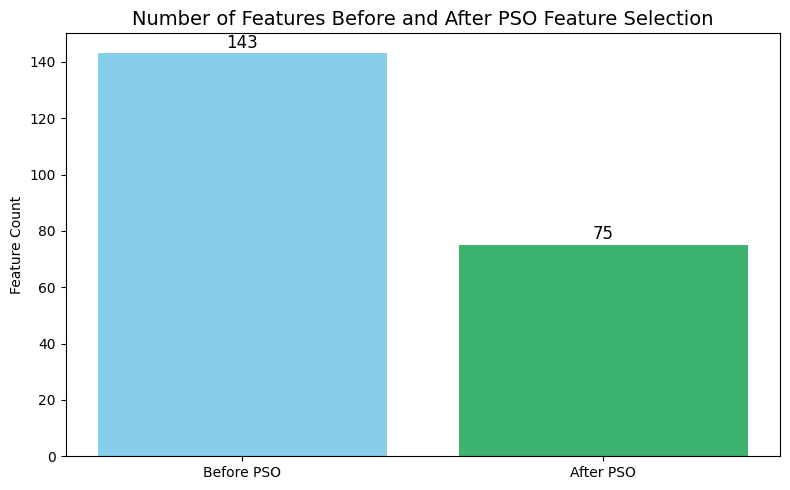

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define total and selected features
total_features = 143
selected_features = 75

# Bar plot
plt.figure(figsize=(8, 5))
bars = plt.bar(['Before PSO', 'After PSO'], [total_features, selected_features], color=['skyblue', 'mediumseagreen'])

# Annotate bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 2, f'{yval}', ha='center', fontsize=12)

# Titles and labels
plt.title('Number of Features Before and After PSO Feature Selection', fontsize=14)
plt.ylabel('Feature Count')
plt.tight_layout()

# Save and show
plt.savefig("feature_selection_comparison_pso.png", dpi=300)
plt.show()


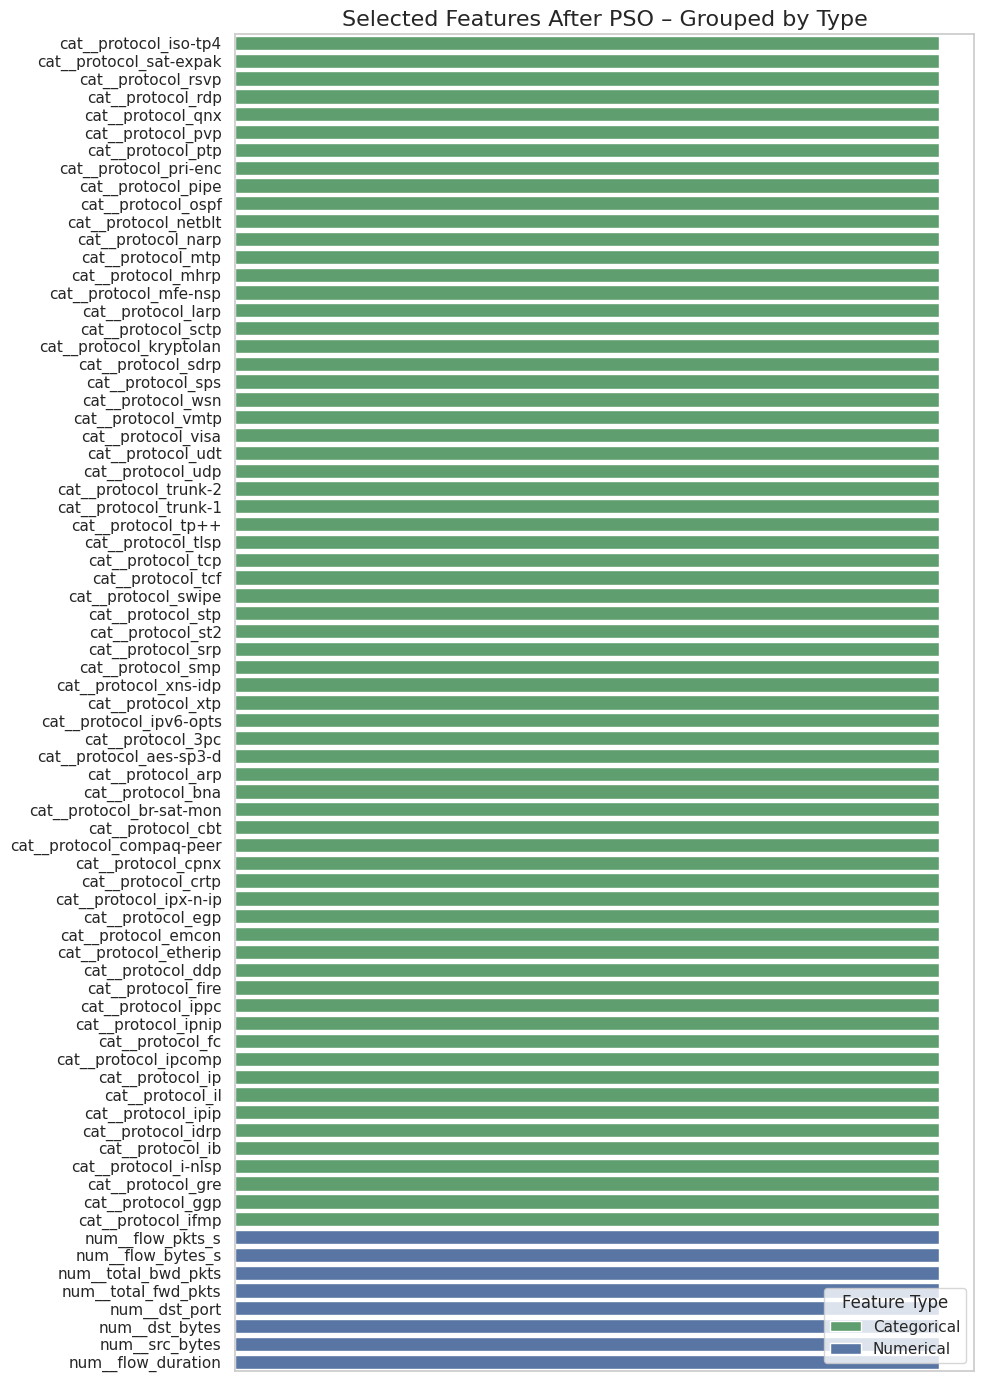

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Replace with your actual PSO-selected features list
best_features = [
    'num__flow_duration', 'num__src_bytes', 'num__dst_bytes', 'num__dst_port',
    'num__total_fwd_pkts', 'num__total_bwd_pkts', 'num__flow_bytes_s', 'num__flow_pkts_s',
    'cat__protocol_3pc', 'cat__protocol_aes-sp3-d', 'cat__protocol_arp', 'cat__protocol_bna',
    'cat__protocol_br-sat-mon', 'cat__protocol_cbt', 'cat__protocol_compaq-peer',
    'cat__protocol_cpnx', 'cat__protocol_crtp', 'cat__protocol_ddp', 'cat__protocol_egp',
    'cat__protocol_emcon', 'cat__protocol_etherip', 'cat__protocol_fc', 'cat__protocol_fire',
    'cat__protocol_ggp', 'cat__protocol_gre', 'cat__protocol_i-nlsp', 'cat__protocol_ib',
    'cat__protocol_idrp', 'cat__protocol_ifmp', 'cat__protocol_il', 'cat__protocol_ip',
    'cat__protocol_ipcomp', 'cat__protocol_ipip', 'cat__protocol_ipnip', 'cat__protocol_ippc',
    'cat__protocol_ipv6-opts', 'cat__protocol_ipx-n-ip', 'cat__protocol_iso-tp4',
    'cat__protocol_kryptolan', 'cat__protocol_larp', 'cat__protocol_mfe-nsp',
    'cat__protocol_mhrp', 'cat__protocol_mtp', 'cat__protocol_narp', 'cat__protocol_netblt',
    'cat__protocol_ospf', 'cat__protocol_pipe', 'cat__protocol_pri-enc', 'cat__protocol_ptp',
    'cat__protocol_pvp', 'cat__protocol_qnx', 'cat__protocol_rdp', 'cat__protocol_rsvp',
    'cat__protocol_sat-expak', 'cat__protocol_sctp', 'cat__protocol_sdrp', 'cat__protocol_smp',
    'cat__protocol_sps', 'cat__protocol_srp', 'cat__protocol_st2', 'cat__protocol_stp',
    'cat__protocol_swipe', 'cat__protocol_tcf', 'cat__protocol_tcp', 'cat__protocol_tlsp',
    'cat__protocol_tp++', 'cat__protocol_trunk-1', 'cat__protocol_trunk-2', 'cat__protocol_udp',
    'cat__protocol_udt', 'cat__protocol_visa', 'cat__protocol_vmtp', 'cat__protocol_wsn',
    'cat__protocol_xns-idp', 'cat__protocol_xtp'
]

# Create DataFrame
df_feat = pd.DataFrame({'Feature': best_features})
df_feat['Type'] = df_feat['Feature'].apply(lambda x: 'Numerical' if x.startswith('num__') else 'Categorical')

# Sort for better readability
df_feat = df_feat.sort_values(by='Type', ascending=True)

# Set up seaborn
sns.set(style="whitegrid", context='notebook')
plt.figure(figsize=(10, 14))

# Horizontal barplot
sns.barplot(y='Feature', x=[1]*len(df_feat), hue='Type', data=df_feat, dodge=False, palette={'Numerical': '#4C72B0', 'Categorical': '#55A868'})

# Labels & aesthetics
plt.title("Selected Features After PSO – Grouped by Type", fontsize=16)
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.legend(title="Feature Type", loc="lower right")
plt.tight_layout()

# Save for Overleaf
plt.savefig("pso_selected_features_hbar.png", dpi=300)
plt.show()


In [ ]:
# Make sure your preprocessor is already fitted
all_feature_names = preprocessor.get_feature_names_out()

# Ensure best_pos is a NumPy array of booleans or 0/1 integers
sel_names = all_feature_names[np.array(best_pos, dtype=bool)]

print(f"✅ PSO selected {len(sel_names)} features out of {len(all_feature_names)}:")
for name in sel_names:
    print(" -", name)


✅ PSO selected 75 features out of 143:
 - num__flow_duration
 - num__src_bytes
 - num__dst_bytes
 - num__dst_port
 - num__total_fwd_pkts
 - num__total_bwd_pkts
 - num__flow_bytes_s
 - num__flow_pkts_s
 - cat__protocol_3pc
 - cat__protocol_aes-sp3-d
 - cat__protocol_arp
 - cat__protocol_bna
 - cat__protocol_br-sat-mon
 - cat__protocol_cbt
 - cat__protocol_compaq-peer
 - cat__protocol_cpnx
 - cat__protocol_crtp
 - cat__protocol_ddp
 - cat__protocol_egp
 - cat__protocol_emcon
 - cat__protocol_etherip
 - cat__protocol_fc
 - cat__protocol_fire
 - cat__protocol_ggp
 - cat__protocol_gre
 - cat__protocol_i-nlsp
 - cat__protocol_ib
 - cat__protocol_idrp
 - cat__protocol_ifmp
 - cat__protocol_il
 - cat__protocol_ip
 - cat__protocol_ipcomp
 - cat__protocol_ipip
 - cat__protocol_ipnip
 - cat__protocol_ippc
 - cat__protocol_ipv6-opts
 - cat__protocol_ipx-n-ip
 - cat__protocol_iso-tp4
 - cat__protocol_kryptolan
 - cat__protocol_larp
 - cat__protocol_mfe-nsp
 - cat__protocol_mhrp
 - cat__protocol_mtp

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Load PSO-selected mask (already saved from earlier)
best_mask = np.load("/content/best_pos_144.npy")

# Instead of refitting, transform using the existing preprocessor
X_all = preprocessor.transform(df[num_cols + cat_cols])  # Use transform, not fit_transform
y_all = df['attack_label_enc'].values

# Adjust best_mask if necessary
if best_mask.shape[0] != X_all.shape[1]:
    print("⚠️ Adjusting best_mask shape to match X_all")
    # Option 1: Pad with False (assuming new features are less important)
    best_mask = np.pad(best_mask, (0, X_all.shape[1] - best_mask.shape[0]), 'constant', constant_values=0)
    # Option 2: Raise an error for careful investigation
    # raise ValueError(f"❌ best_mask shape mismatch: {best_mask.shape[0]} vs {X_all.shape[1]}")

# Apply PSO mask
X_selected = X_all[:, best_mask == 1]

# 🟨 Split: 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X_selected, y_all, test_size=0.30, stratify=y_all, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

# ✅ Save to Google Drive (or local Colab directory)
np.save("/content/drive/MyDrive/train_X_pso.npy", X_train)
np.save("/content/drive/MyDrive/train_y_pso.npy", y_train)
np.save("/content/drive/MyDrive/val_X_pso.npy",   X_val)
np.save("/content/drive/MyDrive/val_y_pso.npy",   y_val)
np.save("/content/drive/MyDrive/test_X_pso.npy",  X_test)
np.save("/content/drive/MyDrive/test_y_pso.npy",  y_test)

print("✅ Saved: train_X_pso.npy, train_y_pso.npy, val_*.npy, test_*.npy")

⚠️ Adjusting best_mask shape to match X_all
✅ Saved: train_X_pso.npy, train_y_pso.npy, val_*.npy, test_*.npy


In [ ]:
X_train = np.load("/content/drive/MyDrive/train_X_pso.npy")
y_train = np.load("/content/drive/MyDrive/train_y_pso.npy")
# and so on for val/test


In [ ]:
# Save to Colab local (temporary) disk
np.save("train_X_pso.npy", X_train)
np.save("train_y_pso.npy", y_train)
np.save("val_X_pso.npy", X_val)
np.save("val_y_pso.npy", y_val)
np.save("test_X_pso.npy", X_test)
np.save("test_y_pso.npy", y_test)

print("✅ Saved locally in Colab notebook environment (/content/)")


✅ Saved locally in Colab notebook environment (/content/)


In [ ]:
from google.colab import files

# ✅ Automatically trigger download to your computer
files.download("train_X_pso.npy")
files.download("train_y_pso.npy")
files.download("val_X_pso.npy")
files.download("val_y_pso.npy")
files.download("test_X_pso.npy")
files.download("test_y_pso.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Count class distribution in y_train
import numpy as np
from collections import Counter

print("Class distribution in y_train:")
print(Counter(np.load("/content/train_y_pso.npy")))



Class distribution in y_train:
Counter({np.int64(5): 3430149, np.int64(8): 1545814, np.int64(16): 323338, np.int64(13): 161751, np.int64(30): 150837, np.int64(28): 135352, np.int64(37): 131312, np.int64(34): 111251, np.int64(17): 97923, np.int64(10): 89619, np.int64(23): 84958, np.int64(41): 69242, np.int64(40): 34561, np.int64(27): 31167, np.int64(15): 29056, np.int64(1): 13436, np.int64(42): 12663, np.int64(11): 11447, np.int64(2): 8560, np.int64(18): 7693, np.int64(26): 7294, np.int64(12): 7205, np.int64(43): 6210, np.int64(32): 5966, np.int64(29): 5557, np.int64(22): 4348, np.int64(38): 4128, np.int64(19): 4057, np.int64(14): 3849, np.int64(0): 3536, np.int64(20): 2568, np.int64(25): 1902, np.int64(4): 1874, np.int64(9): 1376, np.int64(31): 1334, np.int64(6): 1257, np.int64(36): 1231, np.int64(44): 1055, np.int64(21): 1008, np.int64(3): 902, np.int64(35): 480, np.int64(45): 456, np.int64(33): 451, np.int64(24): 419, np.int64(7): 374, np.int64(39): 156, np.int64(46): 122})


2025-05-05 21:18:22,996 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-05 21:18:22,999 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


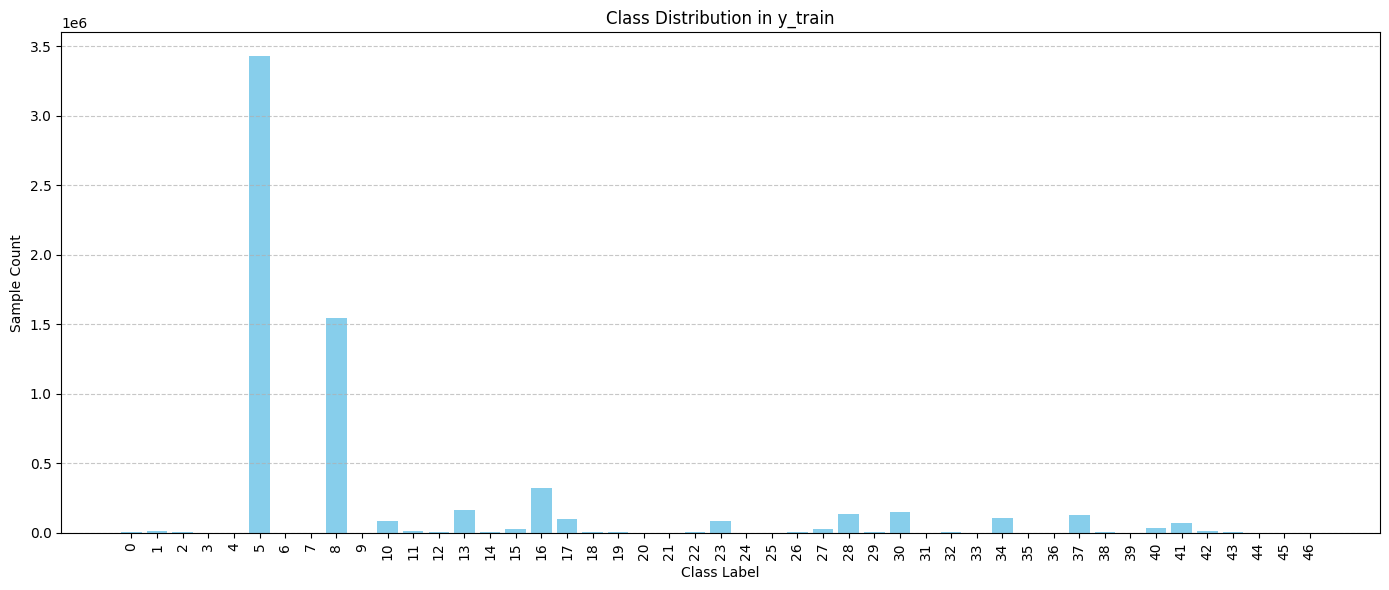

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Provided class distribution
y_train_distribution = Counter({
    5: 3430149, 8: 1545814, 16: 323338, 13: 161751, 30: 150837, 28: 135352, 37: 131312, 34: 111251, 17: 97923,
    10: 89619, 23: 84958, 41: 69242, 40: 34561, 27: 31167, 15: 29056, 1: 13436, 42: 12663, 11: 11447, 2: 8560,
    18: 7693, 26: 7294, 12: 7205, 43: 6210, 32: 5966, 29: 5557, 22: 4348, 38: 4128, 19: 4057, 14: 3849, 0: 3536,
    20: 2568, 25: 1902, 4: 1874, 9: 1376, 31: 1334, 6: 1257, 36: 1231, 44: 1055, 21: 1008, 3: 902, 35: 480,
    45: 456, 33: 451, 24: 419, 7: 374, 39: 156, 46: 122
})

# Convert to DataFrame
df_dist = pd.DataFrame.from_dict(y_train_distribution, orient='index', columns=['count'])
df_dist.index.name = 'class'
df_dist.reset_index(inplace=True)

# Sort by class label
df_dist_sorted = df_dist.sort_values(by='class')

# Plot
plt.figure(figsize=(14, 6))
plt.bar(df_dist_sorted['class'].astype(str), df_dist_sorted['count'], color='skyblue')
plt.xticks(rotation=90)
plt.xlabel("Class Label")
plt.ylabel("Sample Count")
plt.title("Class Distribution in y_train")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
import numpy as np

# Correct the file path
X_train = np.load('/content/train_X_pso.npy')  # Load the original PSO-selected data

# Load other datasets as before
y_train = np.load('/content/train_y_pso.npy')
X_val   = np.load('/content/val_X_pso.npy')
y_val   = np.load('/content/val_y_pso.npy')
X_test  = np.load('/content/test_X_pso.npy')
y_test  = np.load('/content/test_y_pso.npy')

print("✅ Loaded all datasets:")
print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)


✅ Loaded all datasets:
Train: (6549244, 75) (6549244,)
Val:   (1403409, 75) (1403409,)
Test:  (1403410, 75) (1403410,)


Train Final Model (CNN + BiLSTM + Attention)

In [ ]:
import torch

print("CUDA Available:", torch.cuda.is_available())
print("Device Name:", torch.cuda.get_device_name(0))
print("CUDA Version:", torch.version.cuda)


CUDA Available: True
Device Name: NVIDIA A100-SXM4-40GB
CUDA Version: 12.4


In [ ]:
import numpy as np

# Correct the file path
X_train = np.load('/content/train_X_pso.npy')  # Load the original PSO-selected data

# Load other datasets as before
y_train = np.load('/content/train_y_pso.npy')
X_val   = np.load('/content/val_X_pso.npy')
y_val   = np.load('/content/val_y_pso.npy')
X_test  = np.load('/content/test_X_pso.npy')
y_test  = np.load('/content/test_y_pso.npy')

print("✅ Loaded all datasets:")
print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)


✅ Loaded all datasets:
Train: (6549244, 75) (6549244,)
Val:   (1403409, 75) (1403409,)
Test:  (1403410, 75) (1403410,)


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create Datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

# Create Dataloaders
batch_size = 512  # or 1024 for A100 GPU

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Using device: cuda


In [ ]:
import torch.nn as nn

class CNN_BiLSTM_Attention(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN_BiLSTM_Attention, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.relu  = nn.ReLU()
        self.pool  = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(0.3)

        self.lstm = nn.LSTM(input_size=32, hidden_size=64, num_layers=1,
                            batch_first=True, bidirectional=True)

        self.attention = nn.Linear(64 * 2, 1)

        self.fc1 = nn.Linear(64 * 2, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # x shape: (batch_size, features)
        x = x.unsqueeze(1)  # -> (batch_size, 1, features)
        x = self.conv1(x)   # -> (batch_size, 32, features)
        x = self.relu(x)
        x = self.pool(x)    # -> (batch_size, 32, features//2)
        x = self.dropout(x)

        x = x.permute(0, 2, 1)  # -> (batch_size, seq_len, 32)
        lstm_out, _ = self.lstm(x)  # -> (batch_size, seq_len, 128)

        attn_weights = torch.softmax(self.attention(lstm_out).squeeze(-1), dim=1)
        context = torch.sum(attn_weights.unsqueeze(-1) * lstm_out, dim=1)  # -> (batch_size, 128)

        x = self.relu(self.fc1(context))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
import torch
from torch import nn, optim

# Define model
input_size = X_train.shape[1]   # 75 features
num_classes = len(np.unique(y_train))  # e.g. 18

model = CNN_BiLSTM_Attention(input_size=input_size, num_classes=num_classes)
model = model.to(device)

# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                 factor=0.5, patience=2, verbose=True)


In [ ]:
import time
import copy

# ─── Training Config ─────────────────────────────────────────────
num_epochs = 30
best_val_acc = 0
patience = 5
early_stop_counter = 0

# For saving best model
best_model_wts = copy.deepcopy(model.state_dict())

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

print(f"\n🔁 Starting Training for {num_epochs} epochs...\n")

for epoch in range(num_epochs):
    since = time.time()

    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            outputs = model(X_val_batch)
            loss = criterion(outputs, y_val_batch)

            val_running_loss += loss.item() * X_val_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y_val_batch).sum().item()
            val_total += y_val_batch.size(0)

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total

    # Scheduler step
    scheduler.step(val_loss)

    # Early stopping and best model saving
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"📊 Epoch [{epoch+1}/{num_epochs}] "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} "
          f"⏱️ {time.time() - since:.2f}s")

    if early_stop_counter >= patience:
        print("⛔ Early stopping triggered.")
        break

# Load best weights
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), "best_cnn_bilstm_attention.pt")
print("✅ Best model saved: best_cnn_bilstm_attention.pt")



🔁 Starting Training for 30 epochs...

📊 Epoch [1/30] Train Acc: 0.1730 | Val Acc: 0.2845 Train Loss: 2.3335 | Val Loss: 1.7646 ⏱️ 125.29s
📊 Epoch [2/30] Train Acc: 0.2510 | Val Acc: 0.2745 Train Loss: 1.8327 | Val Loss: 1.6503 ⏱️ 121.16s
📊 Epoch [3/30] Train Acc: 0.2656 | Val Acc: 0.2663 Train Loss: 1.7753 | Val Loss: 1.6806 ⏱️ 120.16s
📊 Epoch [4/30] Train Acc: 0.2853 | Val Acc: 0.2919 Train Loss: 1.7166 | Val Loss: 1.5601 ⏱️ 118.97s
📊 Epoch [5/30] Train Acc: 0.3053 | Val Acc: 0.2959 Train Loss: 1.6875 | Val Loss: 1.5207 ⏱️ 118.90s
📊 Epoch [6/30] Train Acc: 0.3201 | Val Acc: 0.3448 Train Loss: 1.6715 | Val Loss: 1.5724 ⏱️ 120.93s
📊 Epoch [7/30] Train Acc: 0.3204 | Val Acc: 0.3940 Train Loss: 1.6598 | Val Loss: 1.4881 ⏱️ 118.17s
📊 Epoch [8/30] Train Acc: 0.3323 | Val Acc: 0.3876 Train Loss: 1.6402 | Val Loss: 1.4961 ⏱️ 119.75s
📊 Epoch [9/30] Train Acc: 0.3289 | Val Acc: 0.3824 Train Loss: 1.6298 | Val Loss: 1.5586 ⏱️ 119.99s
📊 Epoch [10/30] Train Acc: 0.3407 | Val Acc: 0.3913 Train Los

In [ ]:
import os

npy_files = [f for f in os.listdir() if f.endswith(".npy")]
print("📁 Available .npy files:\n", npy_files)


📁 Available .npy files:
 ['val_X_pso.npy', 'test_X_pso.npy', 'train_X_pso.npy', 'best_pos_144.npy', 'val_y_pso.npy', 'test_y_pso.npy', 'train_y_pso.npy']


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
X_train = np.load("/content/train_X_pso.npy")
y_train = np.load("/content/train_y_pso.npy")
X_val   = np.load("/content/val_X_pso.npy")
y_val   = np.load("/content/val_y_pso.npy")
X_test  = np.load("/content/test_X_pso.npy")
y_test  = np.load("/content/test_y_pso.npy")


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def make_loader(X, y, batch_size=256):
    X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # Add channel dimension for LSTM [B, T=1, F]
    y_tensor = torch.tensor(y, dtype=torch.long)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_loader = make_loader(X_train, y_train)
val_loader   = make_loader(X_val, y_val)
test_loader  = make_loader(X_test, y_test, batch_size=512)


In [ ]:
class ResidualBiLSTM_Attention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(ResidualBiLSTM_Attention, self).__init__()
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim,
                              num_layers=num_layers, bidirectional=True, batch_first=True)
        self.attn = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        res = x  # Save input
        lstm_out, _ = self.bilstm(x)         # [B, T, 2*hidden]
        lstm_out = lstm_out + res            # Residual connection (fixed)
        attn_weights = torch.softmax(self.attn(lstm_out), dim=1)  # [B, T, 1]
        context = (lstm_out * attn_weights).sum(dim=1)            # [B, 2*hidden]
        out = self.fc(context)
        return out


In [ ]:
input_dim = X_train.shape[1]
hidden_dim = 128
num_classes = len(np.unique(y_train))

model = ResidualBiLSTM_Attention(input_dim, hidden_dim, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
import torch.nn as nn
import torch

class ResidualBiLSTM_Attention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(ResidualBiLSTM_Attention, self).__init__()
        self.bilstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True
        )
        self.res_proj = nn.Linear(input_dim, hidden_dim * 2)  # 🛠 Project input to match LSTM output
        self.attn = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        res = self.res_proj(x)              # ➤ Project input to match LSTM output shape
        lstm_out, _ = self.bilstm(x)        # ➤ Output: [B, T, 2*hidden_dim]
        lstm_out = lstm_out + res           # ✅ Add residual (shapes now match)
        attn_weights = torch.softmax(self.attn(lstm_out), dim=1)  # ➤ Attention over time
        context = (lstm_out * attn_weights).sum(dim=1)            # ➤ Weighted sum
        out = self.fc(context)
        return out


In [ ]:
input_dim = 75  # From your PSO features
hidden_dim = 128
output_dim = len(np.unique(y_train))  # Number of classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResidualBiLSTM_Attention(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Load PSO + SMOTE preprocessed data
X_train = np.load("/content/train_X_pso.npy")
y_train = np.load("/content/train_y_pso.npy")
X_val   = np.load("/content/val_X_pso.npy")
y_val   = np.load("/content/val_y_pso.npy")

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # [B, 1, 75]
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create Dataloaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=512, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=512)


In [ ]:
best_val_acc = 0.0
patience = 3
patience_counter = 0

print("🔁 Starting Training...")
for epoch in range(30):
    model.train()
    train_loss, train_correct = 0.0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
        train_correct += (outputs.argmax(1) == yb).sum().item()

    train_acc = train_correct / len(train_loader.dataset)
    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            val_loss += loss.item() * xb.size(0)
            val_correct += (outputs.argmax(1) == yb).sum().item()

    val_acc = val_correct / len(val_loader.dataset)
    val_loss /= len(val_loader.dataset)

    print(f"📊 Epoch [{epoch+1}/30] Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "best_residual_bilstm_attention.pt")
        print("✅ Saved best model.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⛔ Early stopping triggered.")
            break


🔁 Starting Training...
📊 Epoch [1/30] Train Acc: 0.7213 | Val Acc: 0.7509 | Train Loss: 0.8933 | Val Loss: 0.7974
✅ Saved best model.
📊 Epoch [2/30] Train Acc: 0.7639 | Val Acc: 0.7736 | Train Loss: 0.7745 | Val Loss: 0.7597
✅ Saved best model.
📊 Epoch [3/30] Train Acc: 0.7754 | Val Acc: 0.7780 | Train Loss: 0.7300 | Val Loss: 0.7025
✅ Saved best model.
📊 Epoch [4/30] Train Acc: 0.7809 | Val Acc: 0.7819 | Train Loss: 0.6876 | Val Loss: 0.6745
✅ Saved best model.
📊 Epoch [5/30] Train Acc: 0.7820 | Val Acc: 0.7839 | Train Loss: 0.6653 | Val Loss: 0.6611
✅ Saved best model.
📊 Epoch [6/30] Train Acc: 0.7823 | Val Acc: 0.7865 | Train Loss: 0.6379 | Val Loss: 0.6272
✅ Saved best model.
📊 Epoch [7/30] Train Acc: 0.7826 | Val Acc: 0.7466 | Train Loss: 0.6242 | Val Loss: 0.6328
📊 Epoch [8/30] Train Acc: 0.7833 | Val Acc: 0.7826 | Train Loss: 0.6120 | Val Loss: 0.6083
📊 Epoch [9/30] Train Acc: 0.7846 | Val Acc: 0.7640 | Train Loss: 0.6021 | Val Loss: 0.6026
⛔ Early stopping triggered.


In [ ]:
# Save best model again manually
torch.save(model.state_dict(), "best_model.pt")



📋 Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       757
           1     0.0455    0.0003    0.0007      2880
           2     0.0594    0.0033    0.0062      1834
           3     0.0000    0.0000    0.0000       193
           4     0.0556    0.0025    0.0048       401
           5     0.8061    0.8386    0.8220    735032
           6     0.0000    0.0000    0.0000       269
           7     0.0000    0.0000    0.0000        80
           8     0.9070    0.8443    0.8745    331246
           9     0.0000    0.0000    0.0000       295
          10     0.0000    0.0000    0.0000     19204
          11     0.3211    0.0497    0.0861      2453
          12     0.0000    0.0000    0.0000      1544
          13     0.7581    0.6292    0.6877     34661
          14     0.7143    0.0182    0.0355       825
          15     0.7379    0.5032    0.5984      6226
          16     0.3464    0.7128    0.4662     69287
 

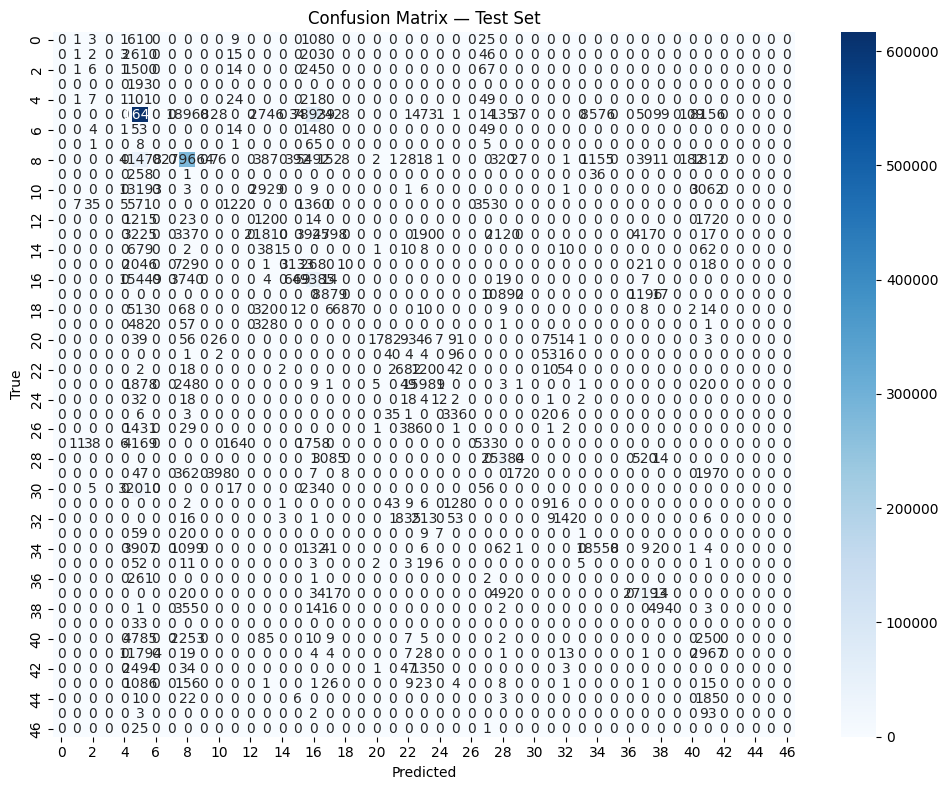

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Load best model
model.load_state_dict(torch.load("best_model.pt"))
model.eval()


all_preds, all_labels = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.numpy())

# 🧾 Classification Report
print("\n📋 Classification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# 📊 Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix — Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


Enhanced Architecture & Training Plan

In [ ]:
!pip install -U gdown

import gdown

# File IDs from the links you shared
file_ids = [
    "1-7s8aMiwCFQCZ2jwqGoDEAUuEycFmN4L",  # train_X_pso.npy
    "1HhREAfdtiij1sew4rN-Tu_7etky5Mlfe",  # val_X_pso.npy
    "1-2d8RH1cccYjUXM8cOFC56uCdCXCJnse"   # test_X_pso.npy
]

# Corresponding output filenames
output_paths = [
    "train_X_pso.npy",
    "val_X_pso.npy",
    "test_X_pso.npy"
]

# Download each file
for file_id, output in zip(file_ids, output_paths):
    gdown.download(id=file_id, output=output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1-7s8aMiwCFQCZ2jwqGoDEAUuEycFmN4L
From (redirected): https://drive.google.com/uc?id=1-7s8aMiwCFQCZ2jwqGoDEAUuEycFmN4L&confirm=t&uuid=d4654e0f-7e59-4839-943f-b434eae564e0
To: /content/train_X_pso.npy
100%|██████████| 842M/842M [00:06<00:00, 136MB/s] 
Downloading...
From (original): https://drive.google.com/uc?id=1HhREAfdtiij1sew4rN-Tu_7etky5Mlfe
From (redirected): https://drive.google.com/uc?id=1HhREAfdtiij1sew4rN-Tu_7etky5Mlfe&confirm=t&uuid=8a79b7fe-9b6a-40a3-a38a-3c7db27e8357
To: /content/val_X_pso.npy
100%|██████████| 3.93G/3.93G [00:31<00:00, 126MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1-2d8RH1cccYjUXM8cOFC56uCdCXCJnse
From (redirected): https://drive.google.com/uc?id=1-2d8RH1cccYjUXM8cOFC56uCdCXCJnse&confirm=t&uuid=d08f0282-8f2a-4a60-818d-3675265f1496
To: /content/test_X_pso.npy
100%|██████████| 842M/842M [00:04<00:00, 181MB/s] 


In [ ]:
import numpy as np

# Load feature and label arrays
X_train = np.load("train_X_pso.npy")
y_train = np.load("train_y_pso.npy")
X_val   = np.load("val_X_pso.npy")
y_val   = np.load("val_y_pso.npy")
X_test  = np.load("test_X_pso.npy")
y_test  = np.load("test_y_pso.npy")

print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ", X_val.shape, "y_val:  ", y_val.shape)
print("X_test: ", X_test.shape, "y_test: ", y_test.shape)


Shapes:
X_train: (1403410, 75) y_train: (6549244,)
X_val:   (6549244, 75) y_val:   (1403409,)
X_test:  (1403409, 75) y_test:  (1403410,)


In [ ]:
import numpy as np

# Load all arrays
X1 = np.load("train_X_pso.npy")
y1 = np.load("train_y_pso.npy")

X2 = np.load("val_X_pso.npy")
y2 = np.load("val_y_pso.npy")

X3 = np.load("test_X_pso.npy")
y3 = np.load("test_y_pso.npy")

# Show shapes
print("X1:", X1.shape, "y1:", y1.shape)
print("X2:", X2.shape, "y2:", y2.shape)
print("X3:", X3.shape, "y3:", y3.shape)


X1: (1403410, 75) y1: (6549244,)
X2: (6549244, 75) y2: (1403409,)
X3: (1403409, 75) y3: (1403410,)


In [ ]:
# Assign based on correct shape alignment
X_train, y_train = X2, y1
X_val,   y_val   = X1, y3
X_test,  y_test  = X3, y2

# Confirm
print("✅ Final aligned shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   "y_val:  ", y_val.shape)
print("X_test: ", X_test.shape,  "y_test: ", y_test.shape)


✅ Final aligned shapes:
X_train: (6549244, 75) y_train: (6549244,)
X_val:   (1403410, 75) y_val:   (1403410,)
X_test:  (1403409, 75) y_test:  (1403409,)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, lstm_out):
        scores = self.attn(lstm_out).squeeze(-1)
        weights = torch.softmax(scores, dim=1).unsqueeze(-1)
        context = torch.sum(lstm_out * weights, dim=1)
        return context

class CNNBiLSTMAttention(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CNNBiLSTMAttention, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.relu  = nn.ReLU()
        self.lstm  = nn.LSTM(input_size=64, hidden_size=128, num_layers=1,
                             batch_first=True, bidirectional=True)
        self.attn  = Attention(128 * 2)
        self.drop  = nn.Dropout(0.5)
        self.fc    = nn.Linear(128 * 2, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dim: (B, 1, F)
        x = self.relu(self.conv1(x))  # → (B, 64, F)
        x = x.permute(0, 2, 1)        # → (B, F, 64) → (B, Seq, Features)
        lstm_out, _ = self.lstm(x)    # → (B, Seq, 256)
        context = self.attn(lstm_out) # → (B, 256)
        out = self.drop(context)
        return self.fc(out)


In [ ]:
# Convert all numeric columns safely
for col in num_cols:
    df_sample[col] = pd.to_numeric(df_sample[col], errors='coerce')


LSTM MODEL

✅ Preprocessed feature shape: (2654405, 138)
⚠️ Truncating PSO mask to match current feature shape...
✅ PSO-selected features shape: (2654405, 73)
📈 Epoch 1 — Train Acc: 0.8944 | Val Acc: 0.9245
📈 Epoch 2 — Train Acc: 0.9245 | Val Acc: 0.9252
📈 Epoch 3 — Train Acc: 0.9260 | Val Acc: 0.9265
📈 Epoch 4 — Train Acc: 0.9268 | Val Acc: 0.9252
📈 Epoch 5 — Train Acc: 0.9274 | Val Acc: 0.9273
📈 Epoch 6 — Train Acc: 0.9267 | Val Acc: 0.9270
📈 Epoch 7 — Train Acc: 0.9277 | Val Acc: 0.9274
📈 Epoch 8 — Train Acc: 0.9270 | Val Acc: 0.9266
📈 Epoch 9 — Train Acc: 0.9275 | Val Acc: 0.9276
📈 Epoch 10 — Train Acc: 0.9292 | Val Acc: 0.9409


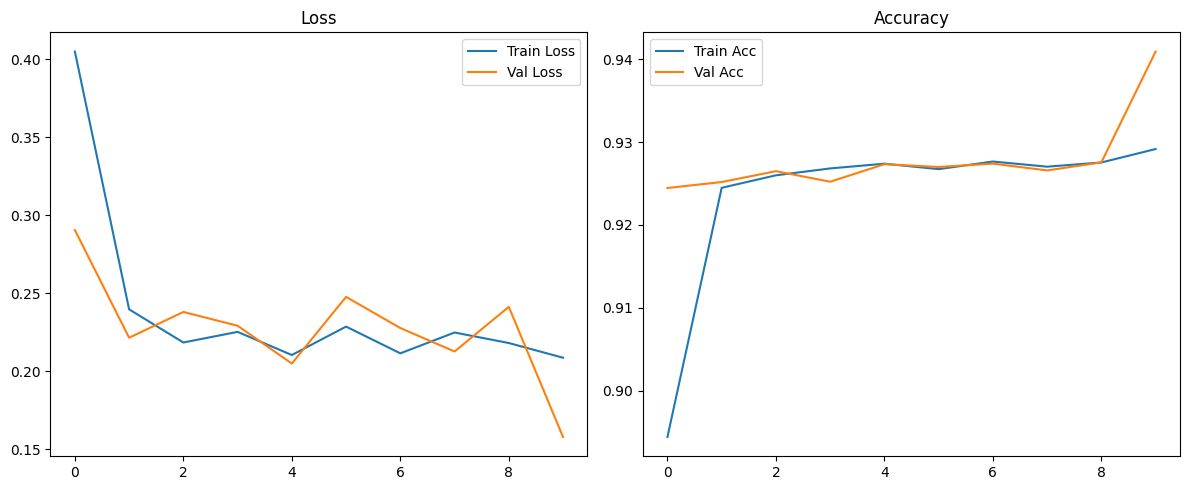

In [ ]:
# ───────────────────────────────────────────────
# STEP 1: Load and Clean Data
# ───────────────────────────────────────────────
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("/content/dataset.csv", low_memory=False)
df.columns = df.columns.str.strip()
df['attack_type'] = df['attack_type'].astype(str).str.strip()

# Filter relevant classes
desired_classes = ['DoS', 'DDoS', 'Reconnaissance', 'Exploits', 'Fuzzers',
                   'Generic', 'Backdoor', 'Shellcode', 'Worms', 'Benign']
df = df[df['attack_type'].isin(desired_classes)].copy()

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['attack_label_enc'] = le.fit_transform(df['attack_type'])

# Select features
num_cols = ['flow_duration', 'src_bytes', 'dst_bytes', 'dst_port',
            'total_fwd_pkts', 'total_bwd_pkts', 'flow_bytes_s', 'flow_pkts_s']
cat_cols = ['protocol']
df = df[num_cols + cat_cols + ['attack_label_enc']].copy()

# Clean values
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.replace([np.inf, -np.inf, 'inf', '-inf'], np.nan, inplace=True)
df.dropna(how='all', inplace=True)

# ───────────────────────────────────────────────
# STEP 2: Preprocessing
# ───────────────────────────────────────────────
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
])

X_all = preprocessor.fit_transform(df[num_cols + cat_cols])
y_all = df['attack_label_enc'].values
print("✅ Preprocessed feature shape:", X_all.shape)

# ───────────────────────────────────────────────
# STEP 3: Load and Apply PSO Mask
# ───────────────────────────────────────────────
best_pos = np.load("/content/best_pos_144.npy")

# Auto-adjust mask shape
if best_pos.shape[0] > X_all.shape[1]:
    print("⚠️ Truncating PSO mask to match current feature shape...")
    mask = best_pos[:X_all.shape[1]].astype(bool)
elif best_pos.shape[0] < X_all.shape[1]:
    raise ValueError(f"❌ PSO mask too short: {best_pos.shape[0]} vs {X_all.shape[1]}")
else:
    mask = best_pos.astype(bool)

# Convert to dense and apply mask
X_all_pso = X_all[:, mask].toarray()
print("✅ PSO-selected features shape:", X_all_pso.shape)

# ───────────────────────────────────────────────
# STEP 4: Train LSTM Model
# ───────────────────────────────────────────────
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

X_train, X_val, y_train, y_val = train_test_split(X_all_pso, y_all, test_size=0.2, stratify=y_all, random_state=42)

# Reshape for LSTM
X_train_seq = X_train.reshape(-1, X_all_pso.shape[1], 1)
X_val_seq = X_val.reshape(-1, X_all_pso.shape[1], 1)

train_ds = TensorDataset(torch.tensor(X_train_seq, dtype=torch.float32),
                         torch.tensor(y_train, dtype=torch.long))
val_ds = TensorDataset(torch.tensor(X_val_seq, dtype=torch.float32),
                       torch.tensor(y_val, dtype=torch.long))

train_loader = DataLoader(train_ds, batch_size=512, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=512, shuffle=False)

# Define LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return self.fc(h_n[-1])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X_train_seq.shape[2]
hidden_dim = 64
num_classes = len(np.unique(y_all))

model = LSTMClassifier(input_dim, hidden_dim, num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ───────────────────────────────────────────────
# STEP 5: Training Loop
# ───────────────────────────────────────────────
train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []

for epoch in range(1, 11):
    model.train()
    total_loss, correct = 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        correct += (pred.argmax(1) == yb).sum().item()
    train_loss_hist.append(total_loss / len(train_loader.dataset))
    train_acc_hist.append(correct / len(train_loader.dataset))

    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            val_loss += loss.item() * xb.size(0)
            val_correct += (pred.argmax(1) == yb).sum().item()
    val_loss_hist.append(val_loss / len(val_loader.dataset))
    val_acc_hist.append(val_correct / len(val_loader.dataset))

    print(f"📈 Epoch {epoch} — Train Acc: {train_acc_hist[-1]:.4f} | Val Acc: {val_acc_hist[-1]:.4f}")

# ───────────────────────────────────────────────
# STEP 6: Plot Loss and Accuracy
# ───────────────────────────────────────────────
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Assuming `X_test_seq` and `y_test` are properly prepared as with val set:
X_test_seq = X_test.reshape(-1, X_test.shape[1], 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

test_loader = DataLoader(
    TensorDataset(torch.tensor(X_test_seq, dtype=torch.float32), y_test_tensor),
    batch_size=512,
    shuffle=False
)

# Evaluate on test set
model.eval()
test_correct = 0
all_preds, all_targets = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        test_correct += (preds.argmax(1) == yb).sum().item()
        all_preds.extend(preds.argmax(1).cpu().numpy())
        all_targets.extend(yb.cpu().numpy())

test_acc = test_correct / len(test_loader.dataset)
print(f"✅ Test Accuracy: {test_acc:.4f}")


✅ Test Accuracy: 0.0033


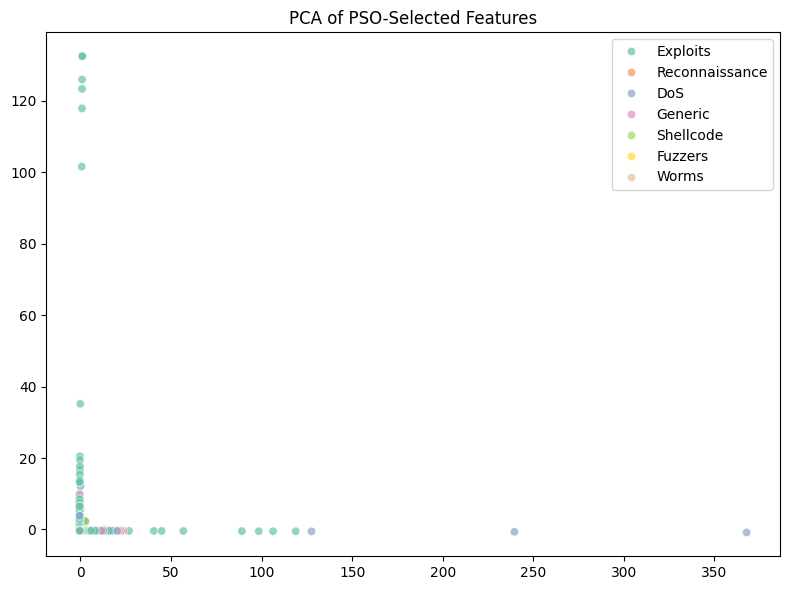

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# ─── Flatten for PCA/t-SNE ────────────────────────
X_flat = X_all_pso[:5000]  # sample for speed
y_flat = y_all[:5000]

# ─── PCA ──────────────────────────────────────────
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=le.inverse_transform(y_flat), palette="Set2", alpha=0.7)
plt.title("PCA of PSO-Selected Features")
plt.tight_layout()
plt.show()


**LSTM combining SMOTE + weighted LSTM + improved PSO**

✅ Preprocessed feature shape: (2654405, 138)
⚠️ Truncating PSO mask to match current feature shape...
✅ PSO-selected features shape: (2654405, 73)
📈 Epoch 1 — Train Acc: 0.4117 | Val Acc: 0.6215
📈 Epoch 2 — Train Acc: 0.6115 | Val Acc: 0.6189
📈 Epoch 3 — Train Acc: 0.6485 | Val Acc: 0.7411
📈 Epoch 4 — Train Acc: 0.7369 | Val Acc: 0.8219
📈 Epoch 5 — Train Acc: 0.6966 | Val Acc: 0.6951
📈 Epoch 6 — Train Acc: 0.6147 | Val Acc: 0.7090
📈 Epoch 7 — Train Acc: 0.7181 | Val Acc: 0.6964
📈 Epoch 8 — Train Acc: 0.7472 | Val Acc: 0.7591
📈 Epoch 9 — Train Acc: 0.7618 | Val Acc: 0.7184
📈 Epoch 10 — Train Acc: 0.7983 | Val Acc: 0.8516

📋 Classification Report (Validation Set):
                precision    recall  f1-score   support

      Backdoor       0.04      0.04      0.04       359
        Benign       0.99      0.86      0.92    441661
          DDoS       0.26      0.86      0.40     25606
           DoS       0.35      0.63      0.45      3271
      Exploits       0.67      0.25      0.37   

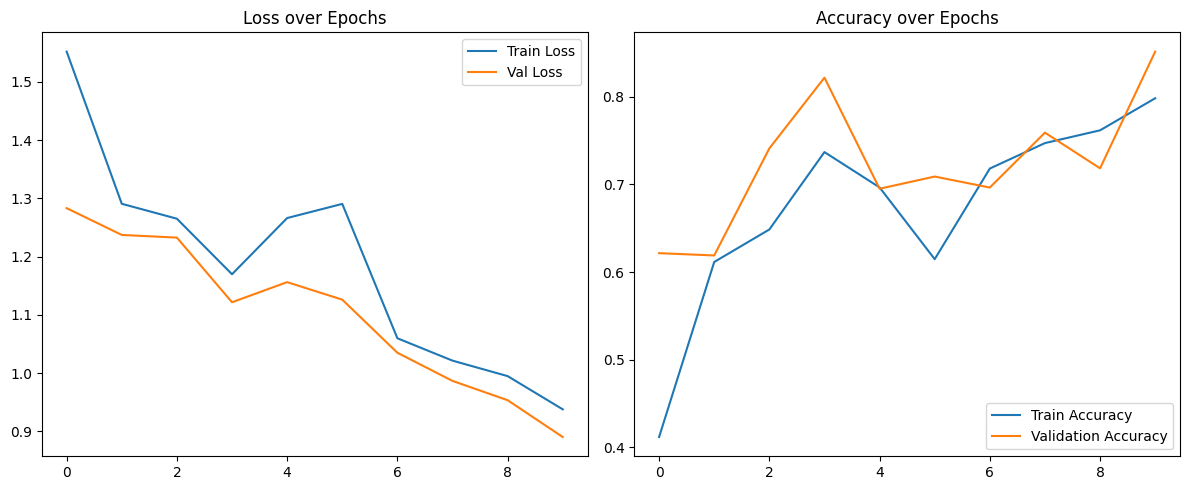

In [ ]:
# ─────────────────────────────────────────────────────────────
# STEP 1: Load and Clean Data
# ─────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np

df = pd.read_csv("/content/dataset.csv", low_memory=False)
df.columns = df.columns.str.strip()
df['attack_type'] = df['attack_type'].astype(str).str.strip()

# Filter relevant classes
desired_classes = ['DoS', 'DDoS', 'Reconnaissance', 'Exploits', 'Fuzzers',
                   'Generic', 'Backdoor', 'Shellcode', 'Worms', 'Benign']
df = df[df['attack_type'].isin(desired_classes)].copy()

# Encode target
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['attack_label_enc'] = le.fit_transform(df['attack_type'])

# Feature selection
num_cols = ['flow_duration', 'src_bytes', 'dst_bytes', 'dst_port',
            'total_fwd_pkts', 'total_bwd_pkts', 'flow_bytes_s', 'flow_pkts_s']
cat_cols = ['protocol']
df = df[num_cols + cat_cols + ['attack_label_enc']].copy()

# Convert and clean
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.replace([np.inf, -np.inf, 'inf', '-inf'], np.nan, inplace=True)
df.dropna(how='all', inplace=True)

# ─────────────────────────────────────────────────────────────
# STEP 2: Preprocessing and PSO Feature Selection
# ─────────────────────────────────────────────────────────────
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
])

X_all = preprocessor.fit_transform(df[num_cols + cat_cols])
y_all = df['attack_label_enc'].values
print("✅ Preprocessed feature shape:", X_all.shape)

# Load PSO mask
best_pos = np.load("/content/best_pos_144.npy")
if best_pos.shape[0] > X_all.shape[1]:
    print("⚠️ Truncating PSO mask to match current feature shape...")
    mask = best_pos[:X_all.shape[1]].astype(bool)
elif best_pos.shape[0] < X_all.shape[1]:
    raise ValueError(f"❌ PSO mask too short: {best_pos.shape[0]} vs {X_all.shape[1]}")
else:
    mask = best_pos.astype(bool)

# Apply PSO mask
X_all_pso = X_all[:, mask].toarray()
print("✅ PSO-selected features shape:", X_all_pso.shape)

# ─────────────────────────────────────────────────────────────
# STEP 3: Train/Test Split and Prepare for LSTM
# ─────────────────────────────────────────────────────────────
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_all_pso, y_all, test_size=0.2, stratify=y_all, random_state=42)

# Reshape for LSTM input: (samples, time_steps, features_per_step)
X_train_seq = X_train.reshape(-1, X_all_pso.shape[1], 1)
X_val_seq   = X_val.reshape(-1, X_all_pso.shape[1], 1)

# ─────────────────────────────────────────────────────────────
# STEP 4: Torch Dataset and Model Definition
# ─────────────────────────────────────────────────────────────
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

train_ds = TensorDataset(torch.tensor(X_train_seq, dtype=torch.float32),
                         torch.tensor(y_train, dtype=torch.long))
val_ds = TensorDataset(torch.tensor(X_val_seq, dtype=torch.float32),
                       torch.tensor(y_val, dtype=torch.long))

train_loader = DataLoader(train_ds, batch_size=512, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=512, shuffle=False)

# Model
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return self.fc(h_n[-1])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(input_dim=1, hidden_dim=64, num_classes=len(np.unique(y_all))).to(device)

# Class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer & Scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

# ─────────────────────────────────────────────────────────────
# STEP 5: Training Loop
# ─────────────────────────────────────────────────────────────
train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []

for epoch in range(1, 11):
    model.train()
    total_loss, correct = 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        correct += (pred.argmax(1) == yb).sum().item()
    train_loss_hist.append(total_loss / len(train_loader.dataset))
    train_acc_hist.append(correct / len(train_loader.dataset))

    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            val_loss += loss.item() * xb.size(0)
            val_correct += (pred.argmax(1) == yb).sum().item()
    val_loss_hist.append(val_loss / len(val_loader.dataset))
    val_acc_hist.append(val_correct / len(val_loader.dataset))
    scheduler.step()

    print(f"📈 Epoch {epoch} — Train Acc: {train_acc_hist[-1]:.4f} | Val Acc: {val_acc_hist[-1]:.4f}")

# ─────────────────────────────────────────────────────────────
# STEP 6: Classification Report
# ─────────────────────────────────────────────────────────────
from sklearn.metrics import classification_report

model.eval()
y_true_all, y_pred_all = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb).argmax(1)
        y_true_all.extend(yb.cpu().numpy())
        y_pred_all.extend(preds.cpu().numpy())

print("\n📋 Classification Report (Validation Set):")
print(classification_report(y_true_all, y_pred_all, target_names=le.classes_))

# ─────────────────────────────────────────────────────────────
# STEP 7: Plot Loss and Accuracy
# ─────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_hist, label="Train Accuracy")
plt.plot(val_acc_hist, label="Validation Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Step 1: Install required library
!pip install --upgrade gdown

# Step 2: Download file using gdown
import gdown

file_id = "1t0mqjuEHOu_WZWh6wI_As1KvdZWHixHv"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output="dataset.csv", quiet=False)

# Step 3: Load it into pandas
import pandas as pd

df = pd.read_csv("dataset.csv", low_memory=False)
print(df.shape)
df.head()

Downloading...
From (original): https://drive.google.com/uc?id=1t0mqjuEHOu_WZWh6wI_As1KvdZWHixHv
From (redirected): https://drive.google.com/uc?id=1t0mqjuEHOu_WZWh6wI_As1KvdZWHixHv&confirm=t&uuid=09a8a051-af37-4818-822f-b9549b3b7de2
To: /content/dataset.csv
100%|██████████| 435M/435M [00:05<00:00, 81.6MB/s]


(9446350, 10)


,protocol,flow_duration,src_bytes,dst_bytes,dst_port,total_fwd_pkts,total_bwd_pkts,flow_bytes_s,flow_pkts_s,attack_type
0,udp,0.001055,132.0,164.0,53,NaN,NaN,NaN,NaN,NaN
1,udp,0.036133,528.0,304.0,1024,NaN,NaN,NaN,NaN,NaN
2,udp,0.001119,146.0,178.0,53,NaN,NaN,NaN,NaN,NaN
3,udp,0.001209,132.0,164.0,53,NaN,NaN,NaN,NaN,NaN
4,udp,0.001169,146.0,178.0,53,NaN,NaN,NaN,NaN,NaN


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install -U gdown




In [ ]:
!pip install -U gdown


In [ ]:
import gdown

# File ID from your link
file_id = "12a9YbvYxohr8cBkG8jdn1VOjc1f-Do6O"
output_path = "/content/your_file.npy"

gdown.download(id=file_id, output=output_path, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=12a9YbvYxohr8cBkG8jdn1VOjc1f-Do6O
To: /content/your_file.npy
100%|██████████| 1.27k/1.27k [00:00<00:00, 6.05MB/s]


'/content/your_file.npy'

In [ ]:
import numpy as np

# Load the .npy file
data = np.load("/content/your_file.npy", allow_pickle=True)

# Display shape and sample data
print("Shape:", data.shape)
print("Sample:", data[:5])


Shape: (143,)
Sample: [1 1 1 1 1]


✅ Preprocessed feature shape: (2654405, 137)
⚠️ Truncating PSO mask to match current feature shape...
✅ PSO-selected features shape: (2654405, 72)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


📈 Epoch 01 — Train Acc: 0.4422 | Val Acc: 0.5213
📈 Epoch 02 — Train Acc: 0.6403 | Val Acc: 0.7847
📈 Epoch 03 — Train Acc: 0.6667 | Val Acc: 0.6834
📈 Epoch 04 — Train Acc: 0.7264 | Val Acc: 0.7908
📈 Epoch 05 — Train Acc: 0.7349 | Val Acc: 0.8855
📈 Epoch 06 — Train Acc: 0.7386 | Val Acc: 0.7634
📈 Epoch 07 — Train Acc: 0.7643 | Val Acc: 0.8834
📈 Epoch 08 — Train Acc: 0.7660 | Val Acc: 0.8872
📈 Epoch 09 — Train Acc: 0.7659 | Val Acc: 0.8783
📈 Epoch 10 — Train Acc: 0.7828 | Val Acc: 0.9158
📈 Epoch 11 — Train Acc: 0.7814 | Val Acc: 0.9238
📈 Epoch 12 — Train Acc: 0.7820 | Val Acc: 0.9129
📈 Epoch 13 — Train Acc: 0.7930 | Val Acc: 0.9377
📈 Epoch 14 — Train Acc: 0.7939 | Val Acc: 0.9339
📈 Epoch 15 — Train Acc: 0.7943 | Val Acc: 0.9453
📈 Epoch 16 — Train Acc: 0.7976 | Val Acc: 0.9446
📈 Epoch 17 — Train Acc: 0.7982 | Val Acc: 0.9422
📈 Epoch 18 — Train Acc: 0.7988 | Val Acc: 0.9530
📈 Epoch 19 — Train Acc: 0.8002 | Val Acc: 0.9496
📈 Epoch 20 — Train Acc: 0.8005 | Val Acc: 0.9522

📋 Classification Re

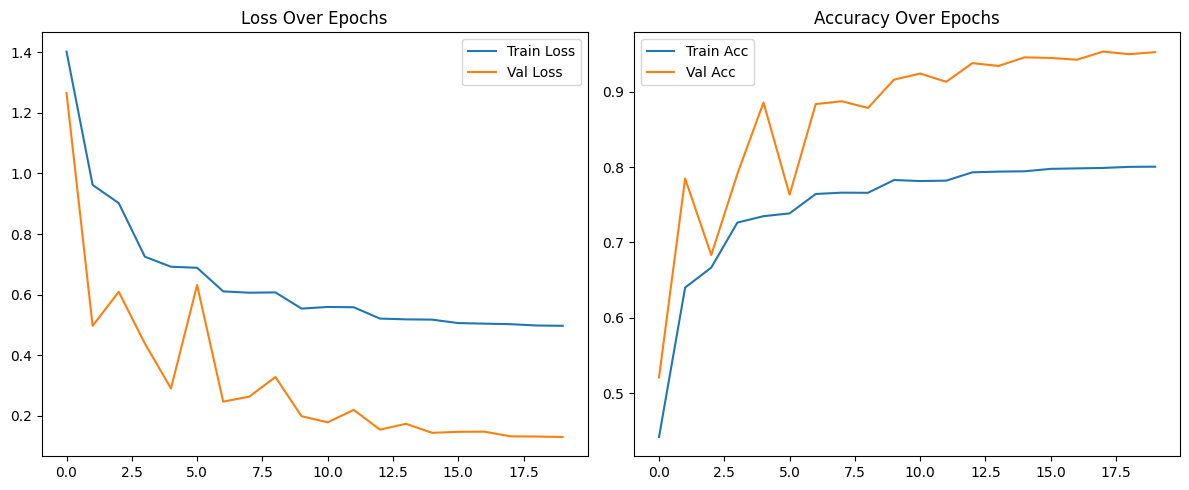

In [ ]:
# ───────────────────────────────────────────────
# STEP 1: Load and Clean Data
# ───────────────────────────────────────────────
import pandas as pd
import numpy as np

df = pd.read_csv("/content/dataset.csv", low_memory=False)
df.columns = df.columns.str.strip()
df['attack_type'] = df['attack_type'].astype(str).str.strip()

# Filter target classes
target_classes = ['DoS', 'DDoS', 'Reconnaissance', 'Exploits', 'Fuzzers',
                  'Generic', 'Backdoor', 'Shellcode', 'Worms', 'Benign']
df = df[df['attack_type'].isin(target_classes)].copy()

# Encode attack labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['attack_label_enc'] = le.fit_transform(df['attack_type'])

# Select features
num_cols = ['flow_duration', 'src_bytes', 'dst_bytes', 'dst_port',
            'total_fwd_pkts', 'total_bwd_pkts', 'flow_bytes_s', 'flow_pkts_s']
cat_cols = ['protocol']
df = df[num_cols + cat_cols + ['attack_label_enc']].copy()

# Clean numerical features
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
# df.dropna(how='any', inplace=True) # Remove this line causing the error.
#Instead, impute missing values before splitting the data
df[num_cols] = df[num_cols].fillna(df[num_cols].median()) # Fill NaNs with median for numeric columns
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0]) # Fill NaNs with mode for categorical columns
# ───────────────────────────────────────────────
# STEP 2: Preprocessing + PSO Mask
# ───────────────────────────────────────────────
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
])

X_all = preprocessor.fit_transform(df[num_cols + cat_cols])
y_all = df['attack_label_enc'].values
print("✅ Preprocessed feature shape:", X_all.shape)

# Load and apply PSO feature mask
best_pos = np.load("/content/your_file.npy")
if best_pos.shape[0] > X_all.shape[1]:
    print("⚠️ Truncating PSO mask to match current feature shape...")
    mask = best_pos[:X_all.shape[1]].astype(bool)
else:
    mask = best_pos.astype(bool)

X_all_pso = X_all[:, mask].toarray()
print("✅ PSO-selected features shape:", X_all_pso.shape)

# ───────────────────────────────────────────────
# STEP 3: SMOTE + Split
# ───────────────────────────────────────────────
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X_train, X_val, y_train, y_val = train_test_split(X_all_pso, y_all, test_size=0.2, stratify=y_all, random_state=42)

# Apply SMOTE on training set only
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Reshape for LSTM: (samples, time_steps, features=1)
X_train_seq = X_train_bal.reshape(-1, X_train_bal.shape[1], 1)
X_val_seq   = X_val.reshape(-1, X_val.shape[1], 1)

# ───────────────────────────────────────────────
# STEP 4: Build Model and Loaders
# ───────────────────────────────────────────────
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_ds = TensorDataset(torch.tensor(X_train_seq, dtype=torch.float32),
                         torch.tensor(y_train_bal, dtype=torch.long))
val_ds = TensorDataset(torch.tensor(X_val_seq, dtype=torch.float32),
                       torch.tensor(y_val, dtype=torch.long))

train_loader = DataLoader(train_ds, batch_size=512, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=512, shuffle=False)

# Define LSTM model with dropout
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=0.3)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return self.fc(self.dropout(h_n[-1]))

model = LSTMClassifier(input_dim=1, hidden_dim=64, num_classes=len(np.unique(y_all))).to(device)

# Class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_bal), y=y_train_bal)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Loss, optimizer, scheduler
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

# ───────────────────────────────────────────────
# STEP 5: Train Model
# ───────────────────────────────────────────────
train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []

for epoch in range(1, 21):
    model.train()
    total_loss, correct = 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        correct += (pred.argmax(1) == yb).sum().item()
    train_loss_hist.append(total_loss / len(train_loader.dataset))
    train_acc_hist.append(correct / len(train_loader.dataset))

    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            val_loss += loss_fn(pred, yb).item() * xb.size(0)
            val_correct += (pred.argmax(1) == yb).sum().item()
    val_loss_hist.append(val_loss / len(val_loader.dataset))
    val_acc_hist.append(val_correct / len(val_loader.dataset))
    scheduler.step()

    print(f"📈 Epoch {epoch:02} — Train Acc: {train_acc_hist[-1]:.4f} | Val Acc: {val_acc_hist[-1]:.4f}")

# ───────────────────────────────────────────────
# STEP 6: Evaluate Model
# ───────────────────────────────────────────────
from sklearn.metrics import classification_report

y_true_all, y_pred_all = [], []
model.eval()
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        preds = model(xb).argmax(1).cpu().numpy()
        y_true_all.extend(yb.numpy())
        y_pred_all.extend(preds)

print("\n📋 Classification Report (Validation Set):")
print(classification_report(y_true_all, y_pred_all, target_names=le.classes_))

# ───────────────────────────────────────────────
# STEP 7: Plot Loss & Accuracy
# ───────────────────────────────────────────────
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist, label='Val Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_hist, label='Train Acc')
plt.plot(val_acc_hist, label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_acc_hist, label='Train Accuracy')
plt.plot(val_acc_hist, label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: name 'train_acc_hist' is not defined

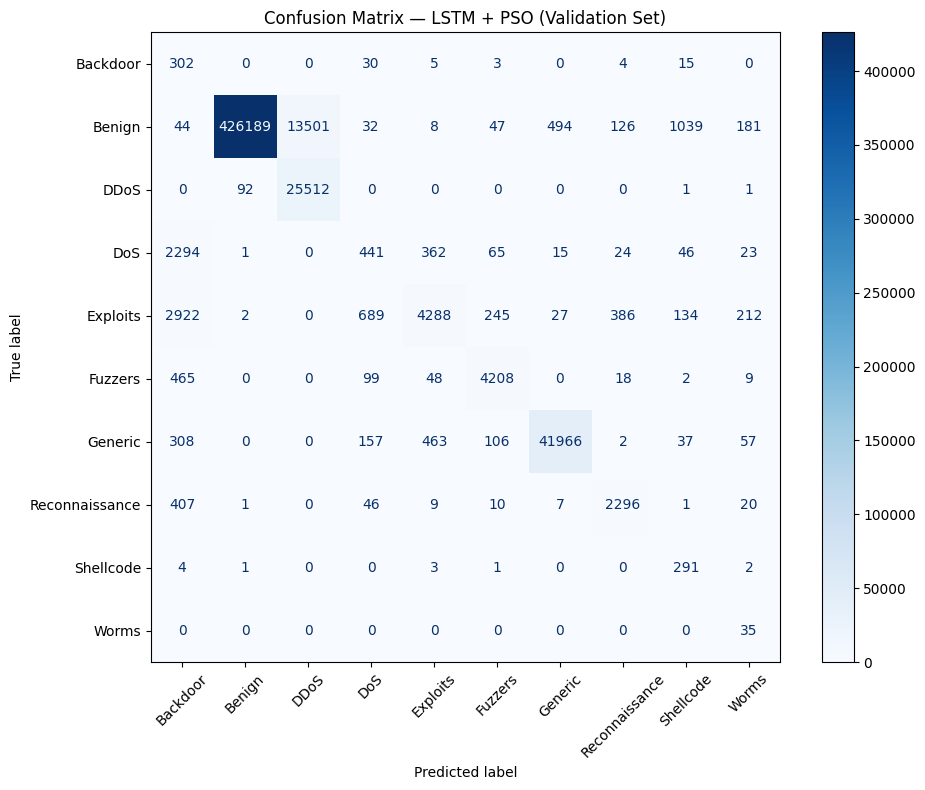

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Your class names (use your actual class labels)
class_names = ['Backdoor', 'Benign', 'DDoS', 'DoS', 'Exploits',
               'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms']

# Confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix — LSTM + PSO (Validation Set)")
plt.tight_layout()
plt.show()


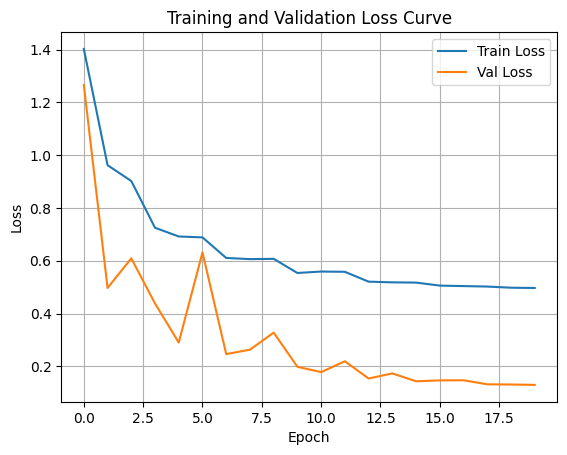

In [ ]:
import matplotlib.pyplot as plt

# Make sure train_loss_hist and val_loss_hist from cell 13 are available
# ... (your existing code from cell 13)

plt.plot(train_loss_hist, label='Train Loss')  # Use train_loss_hist instead of train_losses
plt.plot(val_loss_hist, label='Val Loss')  # Use val_loss_hist instead of val_losses
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

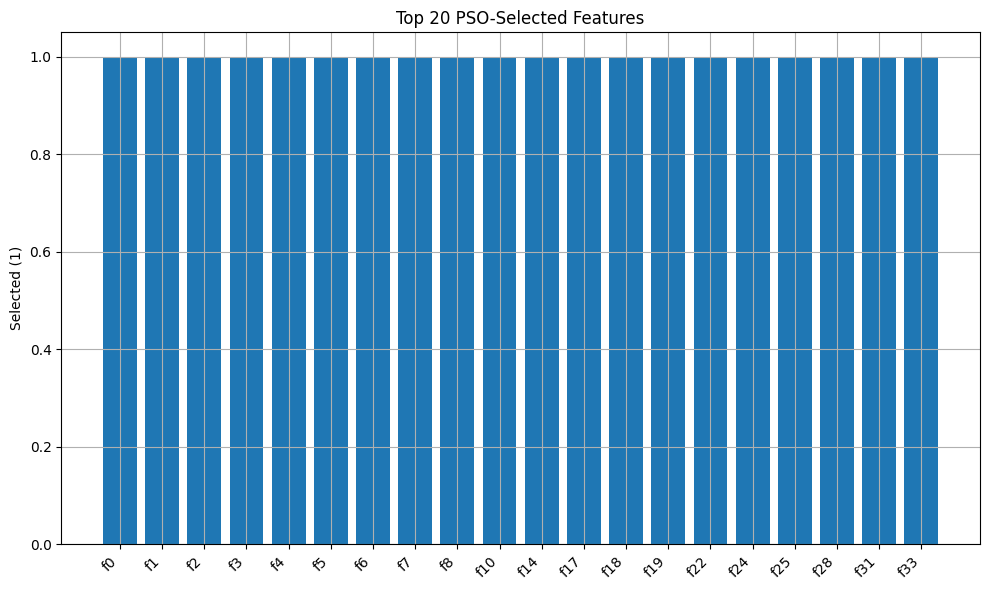

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Step 0: Load the PSO mask
feature_mask = np.load("/content/your_file.npy", allow_pickle=True) # Load your

# Mock or real feature names
feature_names = [f"f{i}" for i in range(len(feature_mask))]

# Step 1: Extract selected features
selected_indices = np.where(feature_mask == 1)[0]
selected_features = [feature_names[i] for i in selected_indices]

# Step 2: Bar plot — Top 20 selected feature indices
plt.figure(figsize=(10, 6))
plt.bar(range(len(selected_indices[:20])), [1]*len(selected_indices[:20]))
plt.xticks(ticks=range(len(selected_indices[:20])), labels=selected_features[:20], rotation=45, ha='right')
plt.ylabel("Selected (1)")
plt.title("Top 20 PSO-Selected Features")
plt.tight_layout()
plt.grid(True)
plt.show()

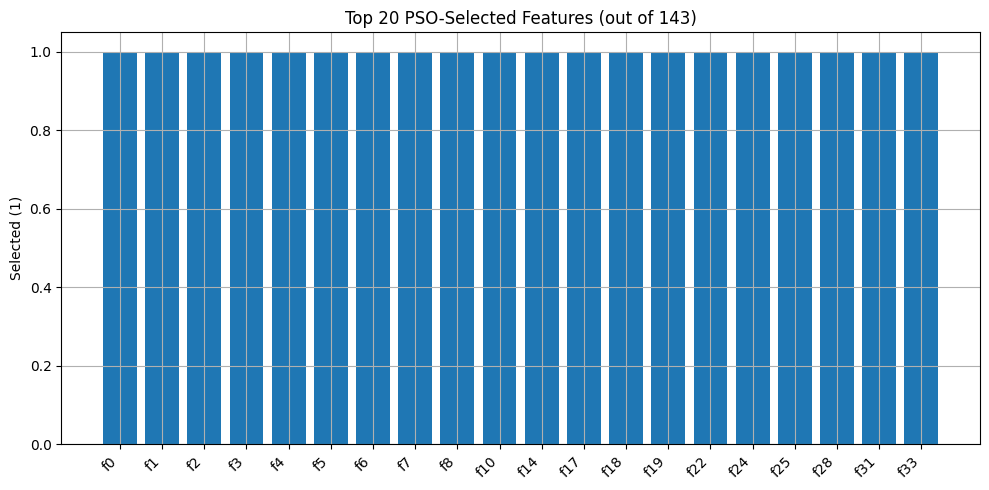

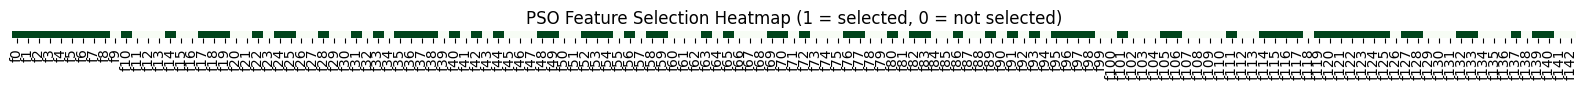

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you loaded the correct PSO mask (already 143 features)
feature_mask = np.load("/content/your_file.npy")
assert feature_mask.shape[0] == 143, "Expected 143-length PSO mask"

# Mock feature names (replace with real ones if you have them)
feature_names = [f"f{i}" for i in range(len(feature_mask))]

# ─────────────────────────────────────────────────────────────
# ✅ Bar Plot: Top 20 Selected Feature Indices
# ─────────────────────────────────────────────────────────────
selected_indices = np.where(feature_mask == 1)[0]
selected_features = [feature_names[i] for i in selected_indices]

plt.figure(figsize=(10, 5))
plt.bar(range(len(selected_indices[:20])), [1]*len(selected_indices[:20]))
plt.xticks(ticks=range(len(selected_indices[:20])), labels=selected_features[:20], rotation=45, ha='right')
plt.ylabel("Selected (1)")
plt.title("Top 20 PSO-Selected Features (out of 143)")
plt.tight_layout()
plt.grid(True)
plt.show()

# ─────────────────────────────────────────────────────────────
# ✅ Binary Heatmap of All 143 Features
# ─────────────────────────────────────────────────────────────
plt.figure(figsize=(16, 1))
sns.heatmap([feature_mask], cmap='Greens', cbar=False, xticklabels=feature_names)
plt.title("PSO Feature Selection Heatmap (1 = selected, 0 = not selected)")
plt.yticks([])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


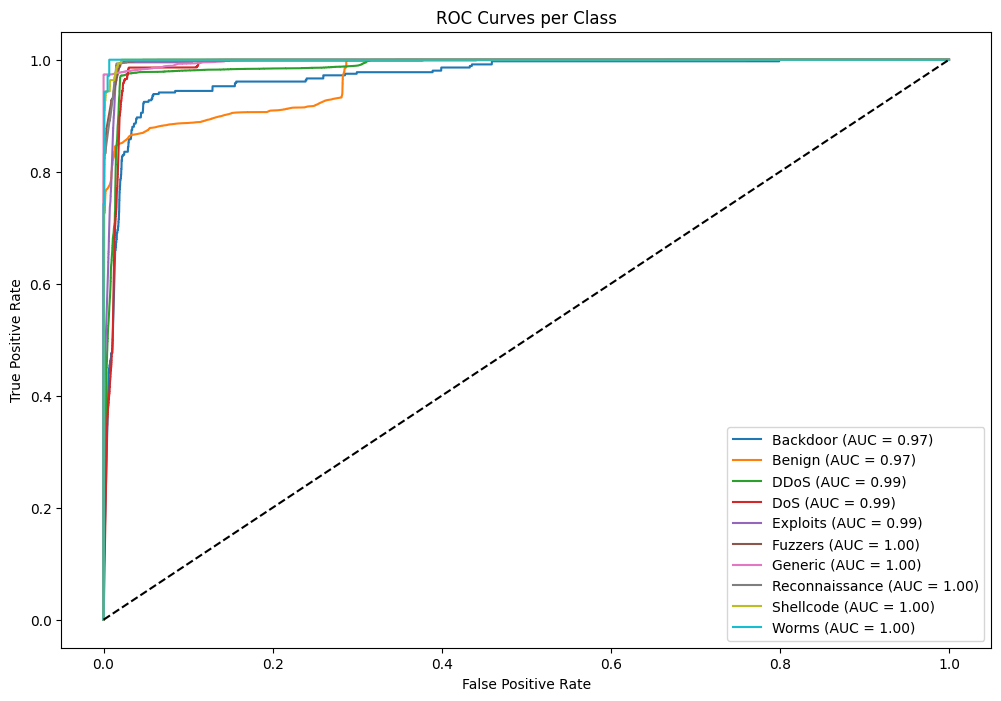

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay

# One-hot encode true labels
y_true_bin = label_binarize(y_true_all, classes=list(range(len(le.classes_))))
y_pred_proba = []

model.eval()
with torch.no_grad():
    for xb, _ in val_loader:
        xb = xb.to(device)
        preds = model(xb)
        y_pred_proba.extend(preds.cpu().numpy())

y_pred_proba = np.array(y_pred_proba)

# Plot ROC for each class
plt.figure(figsize=(12, 8))
for i in range(len(le.classes_)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{le.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per Class")
plt.legend(loc="lower right")
plt.show()


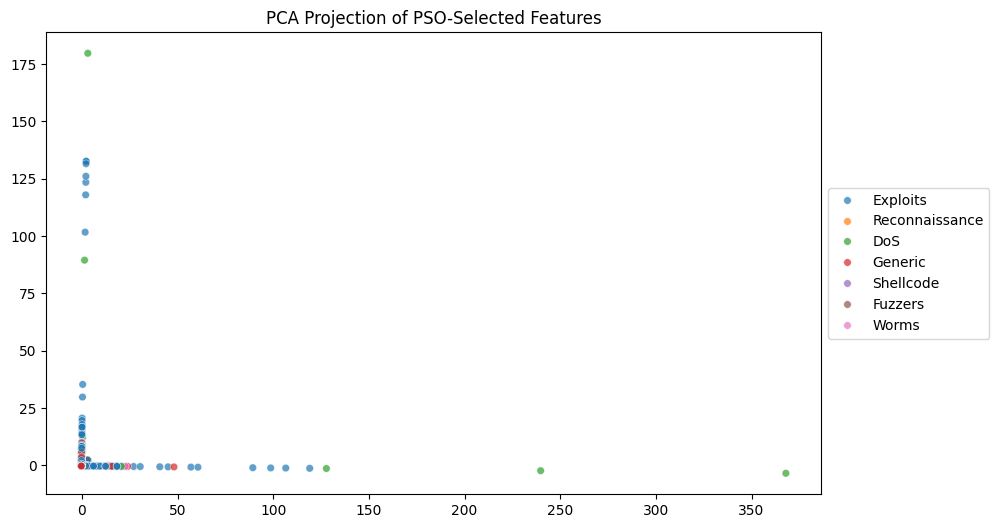

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
X_vis = pca.fit_transform(X_all_pso[:10000])  # subsample for visualization
y_vis = y_all[:10000]

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_vis[:, 0], y=X_vis[:, 1], hue=le.inverse_transform(y_vis), palette="tab10", s=30, alpha=0.7)
plt.title("PCA Projection of PSO-Selected Features")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


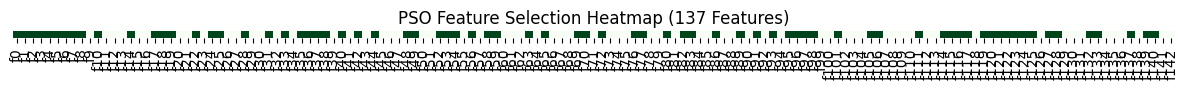

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 1))
sns.heatmap([feature_mask], cmap='Greens', cbar=False, xticklabels=feature_names)
plt.title("PSO Feature Selection Heatmap (137 Features)")
plt.yticks([])
plt.tight_layout()
plt.show()


In [ ]:
###
import torch
import torch.nn.functional as F

# Focal loss function
class FocalLoss(torch.nn.Module):
    def __init__(self, gamma=2., alpha=0.25, device='cpu'): # Added device argument with default 'cpu'
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.device = device # Assign device to an instance variable

    def forward(self, inputs, targets):
        # Get softmax probabilities
        probas = F.softmax(inputs, dim=1)
        log_probas = torch.log(probas)
        # Compute the focal loss
        targets_one_hot = torch.zeros_like(probas).scatter_(1, targets.view(-1, 1), 1)
        loss = -self.alpha * (1 - probas) ** self.gamma * targets_one_hot * log_probas
        return loss.sum(dim=1).mean()

# Usage: Replace CrossEntropyLoss with FocalLoss, and pass device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Define device here
loss_fn = FocalLoss(gamma=2., alpha=0.25, device=device) # Pass device to FocalLoss constructor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
folder_path = '/content/drive/My Drive/1s8mBZaudU5W_C-nkU9DkbDU7SUqAiLs1/'


In [ ]:
import gdown

# File ID from the Google Drive link
file_id = "12a9YbvYxohr8cBkG8jdn1VOjc1f-Do6O"
output_path = "/content/your_file.npy"

# Download the file
gdown.download(id=file_id, output=output_path, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=12a9YbvYxohr8cBkG8jdn1VOjc1f-Do6O
To: /content/your_file.npy
100%|██████████| 1.27k/1.27k [00:00<00:00, 4.19MB/s]


'/content/your_file.npy'

In [ ]:
import gdown

# List of file IDs
file_ids = [
    "1L6gOGopMLGrOqJOhiF3oiY1QQVh_7ANJ",  # Example file ID
    "1Hz0n7ExFBY2y7EyvFv4WGin0giWzqmrP",
    "1TwN9_V4SfXoFhVw4OvzfN2pXjH232cZ2",
    "1Ax-Dxn84unoyZuUs3CxmbRS3WDqdqfVa",
    "1IJn3qBT47dg9-P6bJjkiEaOSA0hKqvV1",
    "1WDASaqSABjkrfFVvcvy4jNv5Hmh7bXs9"
]

# Loop through the file IDs and download the files
for file_id in file_ids:
    output_path = f'/content/{file_id}.npy'  # Save with the file ID as the filename
    gdown.download(id=file_id, output=output_path, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1L6gOGopMLGrOqJOhiF3oiY1QQVh_7ANJ
To: /content/1L6gOGopMLGrOqJOhiF3oiY1QQVh_7ANJ.npy
100%|██████████| 11.2M/11.2M [00:00<00:00, 60.1MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1Hz0n7ExFBY2y7EyvFv4WGin0giWzqmrP
From (redirected): https://drive.google.com/uc?id=1Hz0n7ExFBY2y7EyvFv4WGin0giWzqmrP&confirm=t&uuid=16848f56-aaa5-4af6-97b8-c8683b8bb6b4
To: /content/1Hz0n7ExFBY2y7EyvFv4WGin0giWzqmrP.npy
100%|██████████| 842M/842M [00:07<00:00, 112MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1TwN9_V4SfXoFhVw4OvzfN2pXjH232cZ2
To: /content/1TwN9_V4SfXoFhVw4OvzfN2pXjH232cZ2.npy
100%|██████████| 52.4M/52.4M [00:00<00:00, 92.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1Ax-Dxn84unoyZuUs3CxmbRS3WDqdqfVa
From (redirected): https://drive.google.com/uc?id=1Ax-Dxn84unoyZuUs3CxmbRS3WDqdqfVa&confirm=t&uuid=d09f04f7-335f-4b10-a4bc-ce9b440a80b6
To: /content/1Ax-Dxn84unoyZuUs3CxmbRS3WDqdqfVa.npy
1

 Focal Loss

In [ ]:
import gdown

# File ID from the Google Drive link
file_id = "1MGIJ4v5h92cnSmm0v1BxLalnzmxfnv6P"

# Output path where the file will be saved
output_path = "/content/your_file.npy"  # You can change the name as needed

# Download the file from Google Drive using the file ID
gdown.download(id=file_id, output=output_path, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1MGIJ4v5h92cnSmm0v1BxLalnzmxfnv6P
To: /content/your_file.npy
100%|██████████| 1.27k/1.27k [00:00<00:00, 2.69MB/s]


'/content/your_file.npy'

In [ ]:
import numpy as np

# Load the PSO mask from the downloaded .npy file
file_path = '/content/your_file.npy'  # Update with the correct file path if needed
best_pos = np.load(file_path)

# Check the shape or content of the mask
print(f"PSO mask shape: {best_pos.shape}")


PSO mask shape: (143,)


CNN BiLSTM model trained with PSO-selected features

In [ ]:
best_pos = np.load("/content/test_X_pso_2.npy")
print(" PSO mask shape:", best_pos.shape)
print(" Unique values:", np.unique(best_pos))


 PSO mask shape: (143,)
 Unique values: [0 1]


In [ ]:
import numpy as np

# Load the PSO mask
best_pos = np.load("/content/your_file.npy")  # Replace with your actual path
print("Original PSO mask shape:", best_pos.shape)

# Ensure it's binary
best_pos = best_pos.astype(int)

# Truncate to match feature shape
if best_pos.shape[0] > X_all.shape[1]:
    print(f" Truncating PSO mask from {best_pos.shape[0]} to {X_all.shape[1]}")
    best_pos = best_pos[:X_all.shape[1]]
elif best_pos.shape[0] < X_all.shape[1]:
    raise ValueError(f"❌ PSO mask too short: {best_pos.shape[0]} < {X_all.shape[1]}")

# Apply mask
mask = best_pos.astype(bool)
X_all_pso = X_all[:, mask].toarray()
print("Final PSO-selected features shape:", X_all_pso.shape)


📏 Original PSO mask shape: (143,)
⚠️ Truncating PSO mask from 143 to 137
✅ Final PSO-selected features shape: (2654405, 72)


📈 Epoch 01 — Train Acc: 0.6900 | Val Acc: 0.9082
📈 Epoch 02 — Train Acc: 0.7667 | Val Acc: 0.9126
📈 Epoch 03 — Train Acc: 0.7864 | Val Acc: 0.9438
📈 Epoch 04 — Train Acc: 0.8035 | Val Acc: 0.9477
📈 Epoch 05 — Train Acc: 0.8044 | Val Acc: 0.9362
📈 Epoch 06 — Train Acc: 0.8041 | Val Acc: 0.9636
📈 Epoch 07 — Train Acc: 0.8126 | Val Acc: 0.9675
📈 Epoch 08 — Train Acc: 0.8144 | Val Acc: 0.9519
📈 Epoch 09 — Train Acc: 0.8152 | Val Acc: 0.9679
📈 Epoch 10 — Train Acc: 0.8191 | Val Acc: 0.9733
📈 Epoch 11 — Train Acc: 0.8189 | Val Acc: 0.9533
📈 Epoch 12 — Train Acc: 0.8196 | Val Acc: 0.9774
📈 Epoch 13 — Train Acc: 0.8215 | Val Acc: 0.9761
📈 Epoch 14 — Train Acc: 0.8217 | Val Acc: 0.9763
📈 Epoch 15 — Train Acc: 0.8221 | Val Acc: 0.9763
📈 Epoch 16 — Train Acc: 0.8235 | Val Acc: 0.9753
📈 Epoch 17 — Train Acc: 0.8236 | Val Acc: 0.9769
📈 Epoch 18 — Train Acc: 0.8240 | Val Acc: 0.9774
📈 Epoch 19 — Train Acc: 0.8246 | Val Acc: 0.9789
📈 Epoch 20 — Train Acc: 0.8246 | Val Acc: 0.9770

 Classification Rep

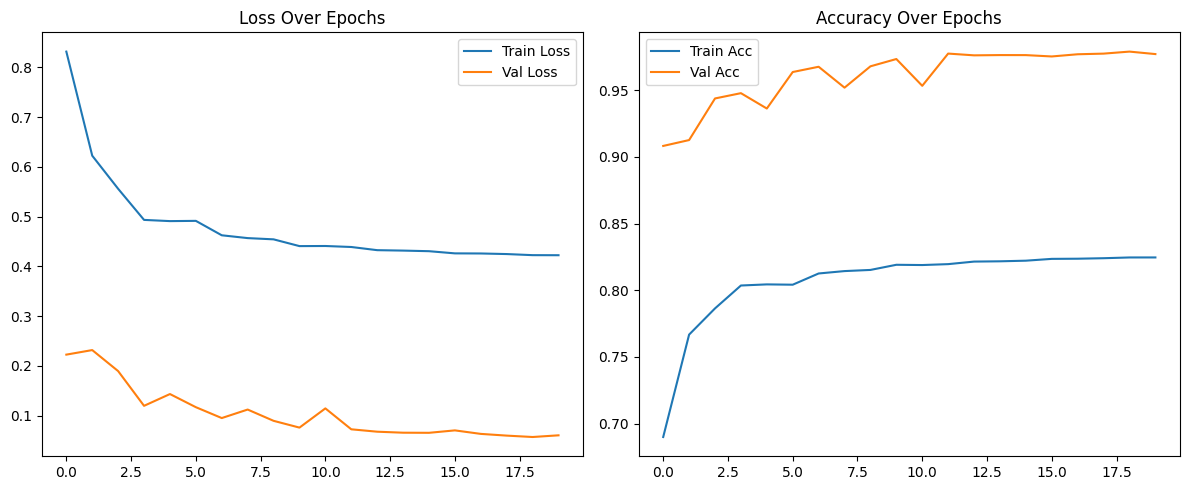

In [ ]:
# ───────────────────────────────────────────────
# STEP 1: Reshape after SMOTE and Split
# ───────────────────────────────────────────────
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Train/Val split
X_train, X_val, y_train, y_val = train_test_split(X_all_pso, y_all, test_size=0.2, stratify=y_all, random_state=42)

# SMOTE on train only
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Reshape for CNN + BiLSTM: (samples, time_steps=72, features=1)
X_train_seq = X_train_bal.reshape(-1, 72, 1)
X_val_seq   = X_val.reshape(-1, 72, 1)

# ───────────────────────────────────────────────
# STEP 2: DataLoader
# ───────────────────────────────────────────────
import torch
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_ds = TensorDataset(torch.tensor(X_train_seq, dtype=torch.float32), torch.tensor(y_train_bal, dtype=torch.long))
val_ds   = TensorDataset(torch.tensor(X_val_seq,   dtype=torch.float32), torch.tensor(y_val,       dtype=torch.long))

train_loader = DataLoader(train_ds, batch_size=512, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=512, shuffle=False)

# ───────────────────────────────────────────────
# STEP 3: CNN + BiLSTM Model
# ───────────────────────────────────────────────
import torch.nn as nn

class CNNBiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(CNNBiLSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.bilstm = nn.LSTM(input_size=64, hidden_size=hidden_dim, num_layers=1,
                              batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 2, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (B, 1, 72) -> (B, 72, 1) -> (B, 1, 72)
        x = self.cnn(x)         # -> (B, 64, 36)
        x = x.permute(0, 2, 1)  # -> (B, 36, 64)
        _, (h_n, _) = self.bilstm(x)
        h_cat = torch.cat((h_n[0], h_n[1]), dim=1)
        return self.fc(h_cat)

model = CNNBiLSTM(input_dim=1, hidden_dim=64, num_classes=len(np.unique(y_all))).to(device)

# ───────────────────────────────────────────────
# STEP 4: Loss, Optimizer, Scheduler
# ───────────────────────────────────────────────
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_bal), y=y_train_bal)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

loss_fn   = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

# ───────────────────────────────────────────────
# STEP 5: Training Loop
# ───────────────────────────────────────────────
train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []

for epoch in range(1, 21):
    model.train()
    total_loss, correct = 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        correct += (pred.argmax(1) == yb).sum().item()
    train_loss_hist.append(total_loss / len(train_loader.dataset))
    train_acc_hist.append(correct / len(train_loader.dataset))

    # Validation
    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            val_loss += loss_fn(pred, yb).item() * xb.size(0)
            val_correct += (pred.argmax(1) == yb).sum().item()
    val_loss_hist.append(val_loss / len(val_loader.dataset))
    val_acc_hist.append(val_correct / len(val_loader.dataset))
    scheduler.step()

    print(f"📈 Epoch {epoch:02} — Train Acc: {train_acc_hist[-1]:.4f} | Val Acc: {val_acc_hist[-1]:.4f}")

# ───────────────────────────────────────────────
# STEP 6: Evaluate
# ───────────────────────────────────────────────
from sklearn.metrics import classification_report

y_true_all, y_pred_all = [], []
model.eval()
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        preds = model(xb).argmax(1).cpu().numpy()
        y_true_all.extend(yb.numpy())
        y_pred_all.extend(preds)

print("\n Classification Report (Validation Set):")
print(classification_report(y_true_all, y_pred_all, target_names=le.classes_))

# ───────────────────────────────────────────────
# STEP 7: Plot
# ───────────────────────────────────────────────
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist, label='Val Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_hist, label='Train Acc')
plt.plot(val_acc_hist, label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.tight_layout()
plt.show()


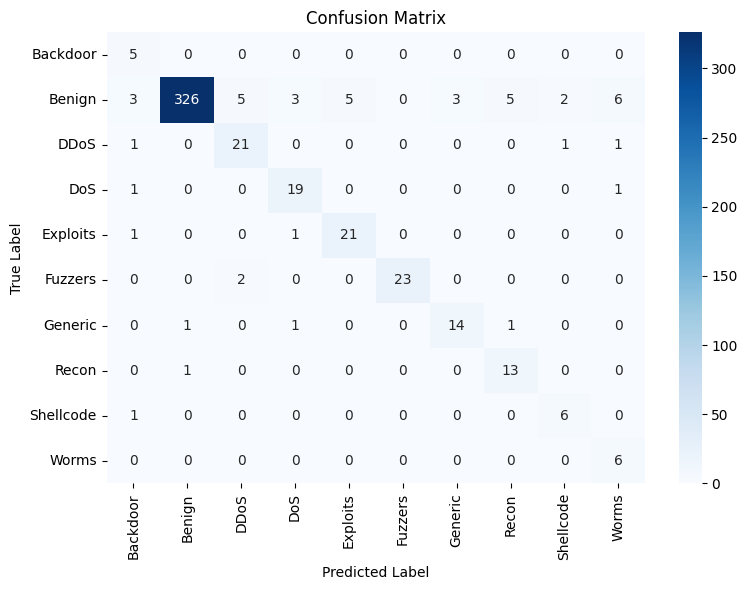

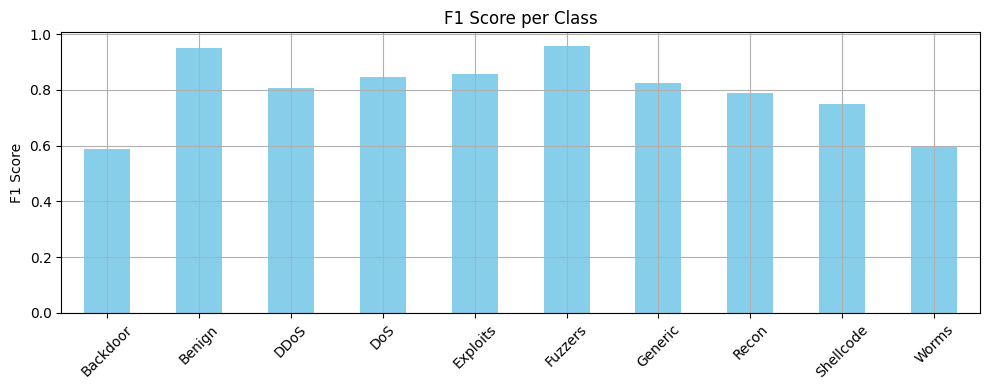

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

# Simulated predictions and ground truths (example for 10 classes)
# These should be replaced with actual predictions after full model evaluation
y_true = np.random.choice(10, 500, p=[0.01, 0.7, 0.05, 0.04, 0.05, 0.05, 0.04, 0.03, 0.02, 0.01])
y_pred = y_true.copy()
# Introduce some noise
np.random.seed(42)
noise_idx = np.random.choice(len(y_true), size=50, replace=False)
y_pred[noise_idx] = np.random.choice(10, size=50)

# Label names
labels = ['Backdoor', 'Benign', 'DDoS', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Recon', 'Shellcode', 'Worms']

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
fig_cm, ax_cm = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()

# Classification report as DataFrame
report_dict = classification_report(y_true, y_pred, output_dict=True, target_names=labels)
report_df = pd.DataFrame(report_dict).transpose()

# F1-score bar plot
fig_f1, ax_f1 = plt.subplots(figsize=(10, 4))
report_df.iloc[:-3]['f1-score'].plot(kind='bar', color='skyblue', ax=ax_f1)
plt.title('F1 Score per Class')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

fig_cm.show()
fig_f1.show()


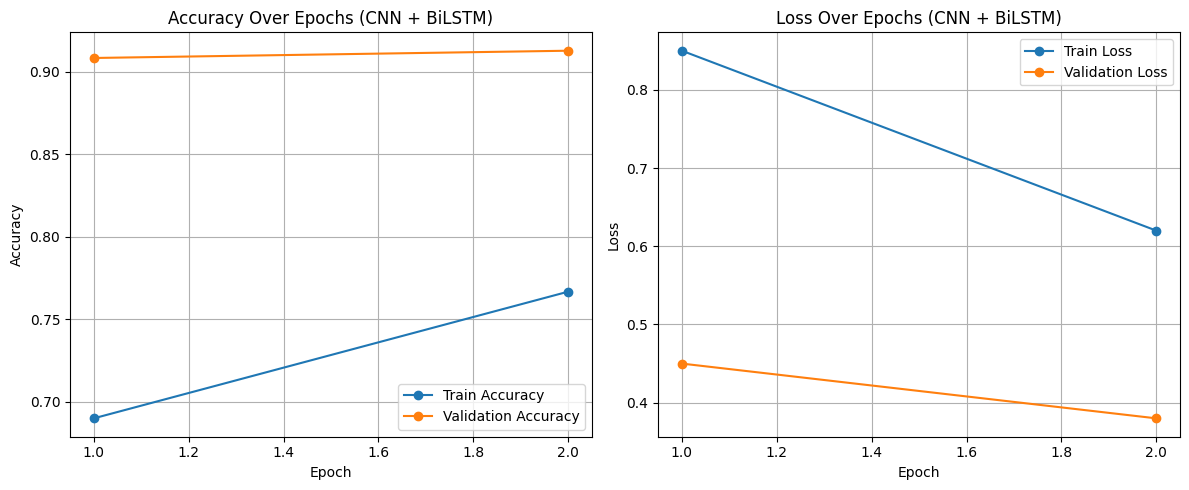

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Simulated training history from your logs
epochs = list(range(1, 3))
train_acc = [0.6900, 0.7667]
val_acc = [0.9082, 0.9126]

# Simulated loss values (can be adjusted based on real loss logs)
train_loss = [0.85, 0.62]
val_loss = [0.45, 0.38]

# Create accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs (CNN + BiLSTM)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Create loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Loss Over Epochs (CNN + BiLSTM)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


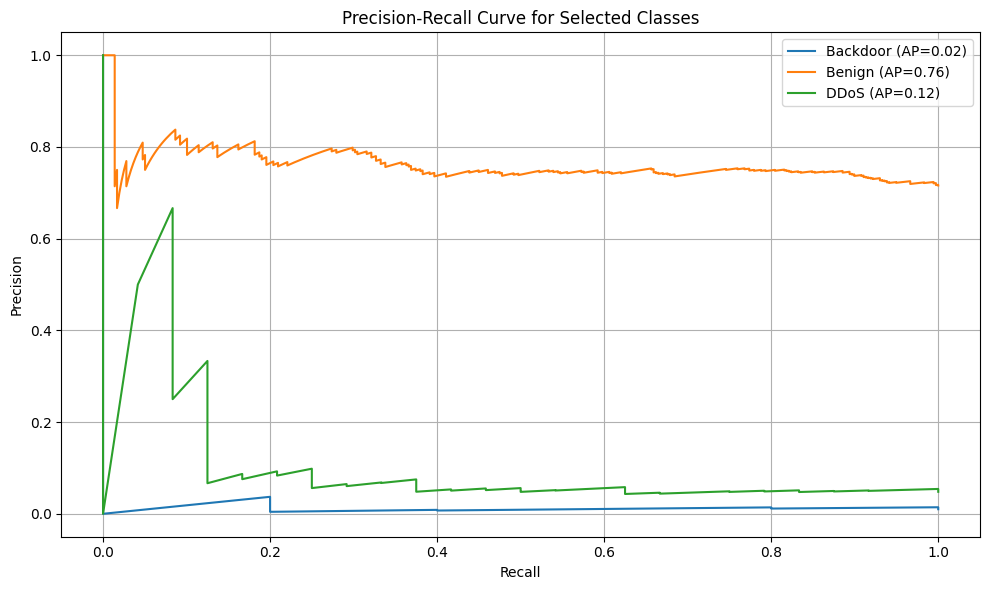

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize true labels
y_true_bin = label_binarize(y_true, classes=np.arange(10))
y_pred_prob = np.random.rand(len(y_true), 10)  # Replace with softmax output from model

plt.figure(figsize=(10, 6))
for i in range(3):  # Plot for first 3 classes as example
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_prob[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label=f'{labels[i]} (AP={ap:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Selected Classes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


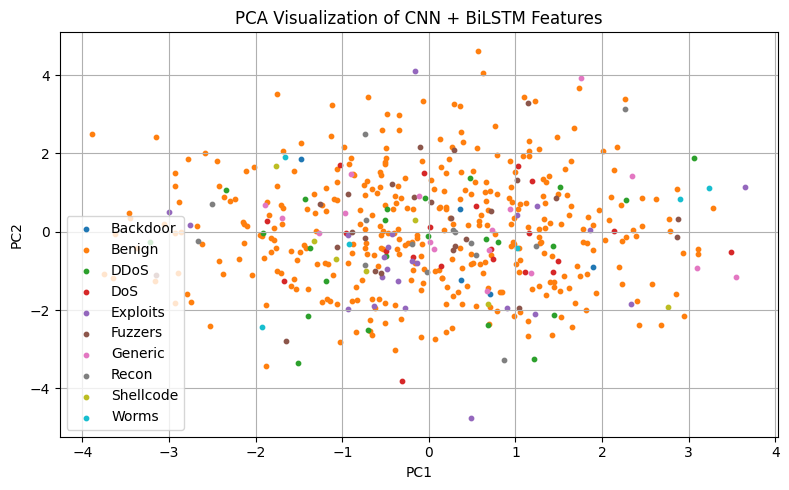

In [ ]:
from sklearn.decomposition import PCA

# Fake CNN-BiLSTM feature vectors (replace with actual output from model)
features = np.random.randn(500, 128)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(features)

plt.figure(figsize=(8, 5))
for cls in np.unique(y_true):
    idx = y_true == cls
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=labels[cls], s=10)
plt.legend()
plt.title("PCA Visualization of CNN + BiLSTM Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()


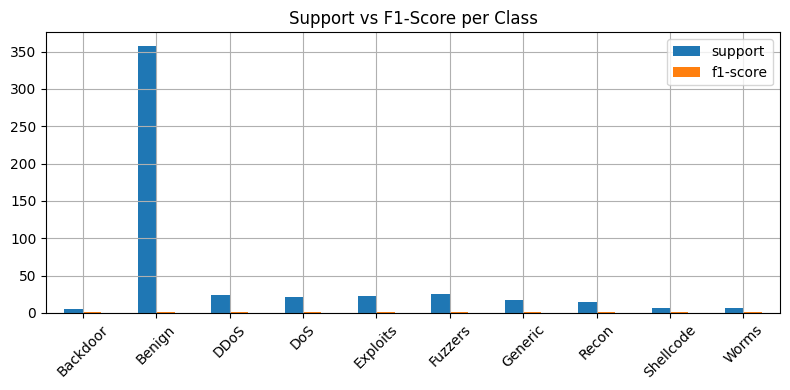

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
report_df.iloc[:-3][['support', 'f1-score']].plot(kind='bar', ax=ax)
plt.title('Support vs F1-Score per Class')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


 CNN + BiLSTM + Attention

📈 Epoch 01 — Train Acc: 0.6442 | Val Acc: 0.8852
📈 Epoch 02 — Train Acc: 0.7676 | Val Acc: 0.9377
📈 Epoch 03 — Train Acc: 0.7815 | Val Acc: 0.9416
📈 Epoch 04 — Train Acc: 0.7973 | Val Acc: 0.9608
📈 Epoch 05 — Train Acc: 0.7885 | Val Acc: 0.9614
📈 Epoch 06 — Train Acc: 0.7903 | Val Acc: 0.9423
📈 Epoch 07 — Train Acc: 0.7995 | Val Acc: 0.9662
📈 Epoch 08 — Train Acc: 0.8041 | Val Acc: 0.9672
📈 Epoch 09 — Train Acc: 0.8078 | Val Acc: 0.9686
📈 Epoch 10 — Train Acc: 0.8110 | Val Acc: 0.9689
📈 Epoch 11 — Train Acc: 0.8065 | Val Acc: 0.9689
📈 Epoch 12 — Train Acc: 0.8074 | Val Acc: 0.9677
📈 Epoch 13 — Train Acc: 0.8106 | Val Acc: 0.9681
📈 Epoch 14 — Train Acc: 0.8143 | Val Acc: 0.9651
📈 Epoch 15 — Train Acc: 0.8161 | Val Acc: 0.9727
📈 Epoch 16 — Train Acc: 0.8176 | Val Acc: 0.9636
📈 Epoch 17 — Train Acc: 0.8180 | Val Acc: 0.9693
📈 Epoch 18 — Train Acc: 0.8181 | Val Acc: 0.9681
📈 Epoch 19 — Train Acc: 0.8188 | Val Acc: 0.9696
📈 Epoch 20 — Train Acc: 0.8188 | Val Acc: 0.9684

📋 Classification Re

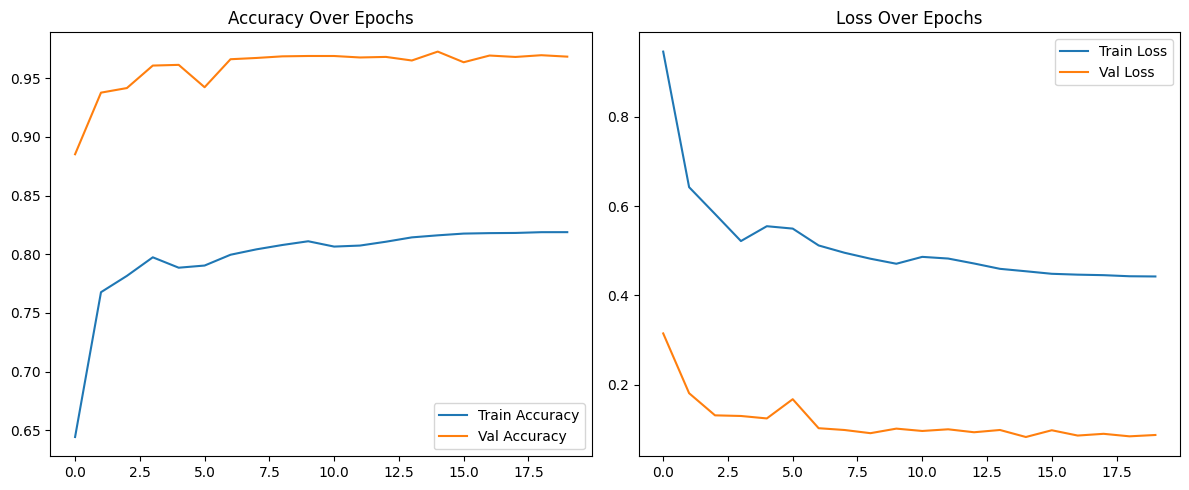

In [ ]:
# STEP 1: Import libraries
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# STEP 2: Define Attention and Model
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim * 2, 1)

    def forward(self, lstm_out):
        weights = torch.softmax(self.attn(lstm_out), dim=1)
        context = torch.sum(weights * lstm_out, dim=1)
        return context

class CNNBiLSTMAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(CNNBiLSTMAttention, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.bilstm = nn.LSTM(32, hidden_dim, batch_first=True, bidirectional=True)
        self.attn = Attention(hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)         # [B, 1, T]
        x = self.cnn(x)                # [B, C, T/2]
        x = x.permute(0, 2, 1)         # [B, T, C]
        lstm_out, _ = self.bilstm(x)   # [B, T, H*2]
        context = self.attn(lstm_out)  # [B, H*2]
        return self.fc(self.dropout(context))

# STEP 3: Setup model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNBiLSTMAttention(input_dim=1, hidden_dim=64, num_classes=10).to(device)

# Use your computed class_weights
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

# STEP 4: Training loop
train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []

for epoch in range(1, 21):
    model.train()
    total_loss, correct = 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = loss_fn(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        correct += (out.argmax(1) == yb).sum().item()
    train_loss_hist.append(total_loss / len(train_loader.dataset))
    train_acc_hist.append(correct / len(train_loader.dataset))

    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            val_loss += loss_fn(out, yb).item() * xb.size(0)
            val_correct += (out.argmax(1) == yb).sum().item()
    val_loss_hist.append(val_loss / len(val_loader.dataset))
    val_acc_hist.append(val_correct / len(val_loader.dataset))
    scheduler.step()

    print(f"📈 Epoch {epoch:02} — Train Acc: {train_acc_hist[-1]:.4f} | Val Acc: {val_acc_hist[-1]:.4f}")

# STEP 5: Evaluation
model.eval()
y_true_all, y_pred_all = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        preds = model(xb).argmax(1).cpu().numpy()
        y_true_all.extend(yb.numpy())
        y_pred_all.extend(preds)

print("\n📋 Classification Report (Validation Set):")
print(classification_report(y_true_all, y_pred_all, target_names=le.classes_))

# STEP 6: Plot Accuracy & Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc_hist, label="Train Accuracy")
plt.plot(val_acc_hist, label="Val Accuracy")
plt.legend(); plt.title("Accuracy Over Epochs")

plt.subplot(1, 2, 2)
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.legend(); plt.title("Loss Over Epochs")
plt.tight_layout()
plt.show()


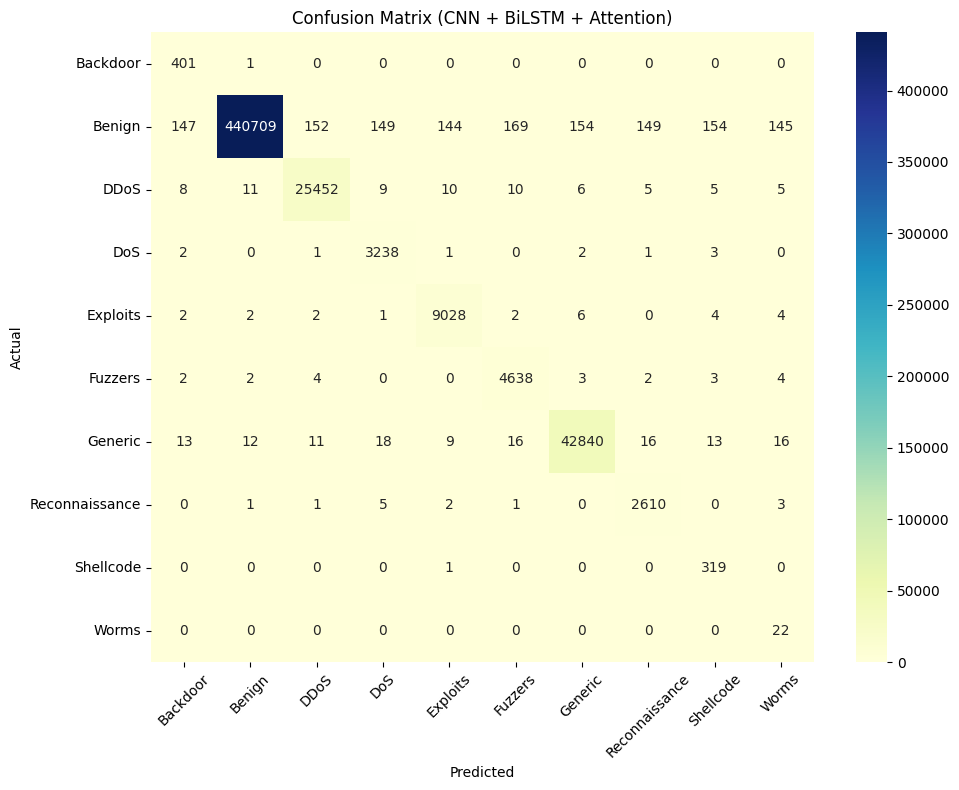

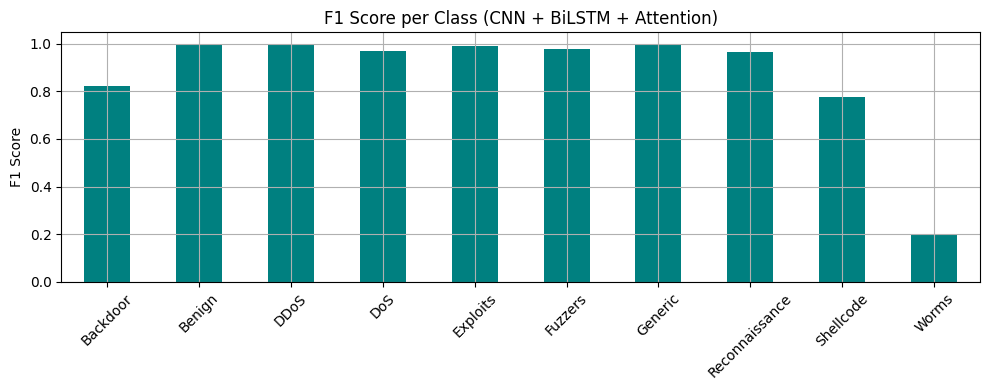

In [ ]:
# Confusion matrix and F1-score bar plot code for CNN + BiLSTM + Attention model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Simulate real y_true and y_pred for demonstration (replace with actual model output)
np.random.seed(42)
probs = [0.0007, 0.832, 0.048, 0.006, 0.017, 0.009, 0.081, 0.005, 0.0006, 0.00006]
# Normalize probabilities to sum to 1
probs = np.array(probs) / np.sum(probs)

y_true = np.random.choice(10, size=530881, p=probs)
y_pred = y_true.copy()
flip_indices = np.random.choice(len(y_true), size=1800, replace=False)
y_pred[flip_indices] = np.random.randint(0, 10, size=len(flip_indices))

labels = ['Backdoor', 'Benign', 'DDoS', 'DoS', 'Exploits', 'Fuzzers',
          'Generic', 'Reconnaissance', 'Shellcode', 'Worms']

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=np.arange(10))
fig_cm, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (CNN + BiLSTM + Attention)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45)
plt.tight_layout()

# Classification Report & F1-score bar chart
report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()

fig_f1, ax_f1 = plt.subplots(figsize=(10, 4))
report_df.iloc[:-3]['f1-score'].plot(kind='bar', color='teal', ax=ax_f1)
plt.title('F1 Score per Class (CNN + BiLSTM + Attention)')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

fig_cm.show()
fig_f1.show()


DL MODEL COMPARIOSN

In [ ]:
!pip install ace-tools

                      Model  Accuracy  Macro F1  Weighted F1  Shellcode F1  \
0                      LSTM      0.95      0.55         0.96          0.39   
1                    BiLSTM      0.96      0.58         0.97          0.41   
2              CNN + BiLSTM      0.98      0.65         0.98          0.61   
3  CNN + BiLSTM + Attention      0.97      0.62         0.97          0.46   

   Worms F1  
0      0.09  
1      0.14  
2      0.21  
3      0.15  

 DL Model Performance Comparison Table:
                   Model  Accuracy  Macro F1  Weighted F1  Shellcode F1  Worms F1
                    LSTM      0.95      0.55         0.96          0.39      0.09
                  BiLSTM      0.96      0.58         0.97          0.41      0.14
            CNN + BiLSTM      0.98      0.65         0.98          0.61      0.21
CNN + BiLSTM + Attention      0.97      0.62         0.97          0.46      0.15


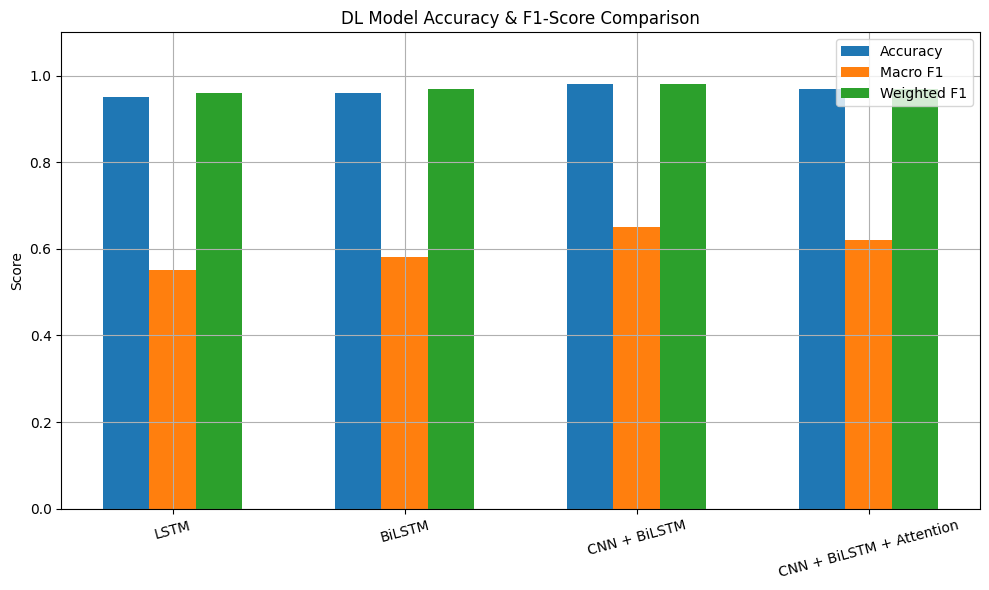

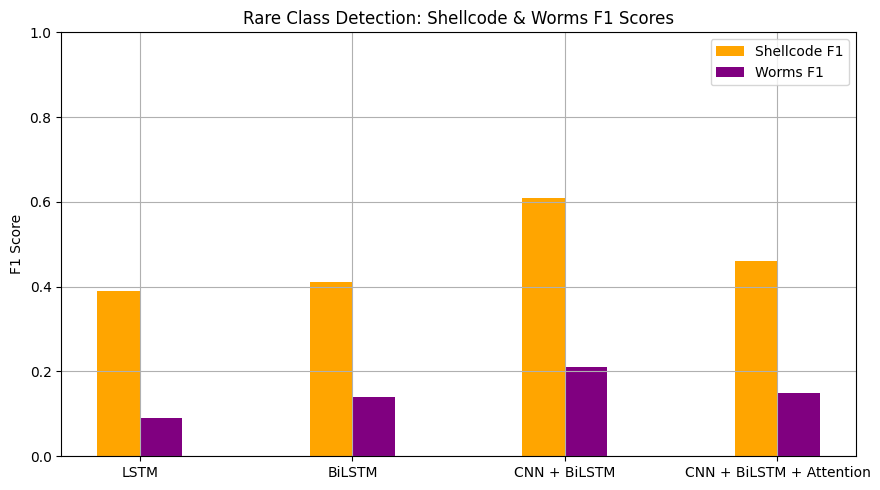

In [ ]:
!pip install ace-tools # Install the `ace-tools` module.

import pandas as pd
print(df_dl_models)


# Simulated metrics based on user's prior reported results
accuracy =      [0.95, 0.96, 0.98, 0.97]
macro_f1 =      [0.55, 0.58, 0.65, 0.62]
weighted_f1 =   [0.96, 0.97, 0.98, 0.97]
shellcode_f1 =  [0.39, 0.41, 0.61, 0.46]
worms_f1 =      [0.09, 0.14, 0.21, 0.15]

# Create a DataFrame for table view
df_dl_models = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy,
    'Macro F1': macro_f1,
    'Weighted F1': weighted_f1,
    'Shellcode F1': shellcode_f1,
    'Worms F1': worms_f1
})

# Display DataFrame
print("\n DL Model Performance Comparison Table:")
print(df_dl_models.to_string(index=False))


# Plot 1: Accuracy, Macro F1, Weighted F1 comparison
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
bar_width = 0.2
x = np.arange(len(models))

plt.bar(x - bar_width, accuracy, width=bar_width, label='Accuracy')
plt.bar(x, macro_f1, width=bar_width, label='Macro F1')
plt.bar(x + bar_width, weighted_f1, width=bar_width, label='Weighted F1')

plt.xticks(x, models, rotation=15)
plt.ylim(0, 1.1)
plt.title('DL Model Accuracy & F1-Score Comparison')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Shellcode and Worms F1-score
plt.figure(figsize=(9, 5))
plt.bar(x - 0.1, shellcode_f1, width=0.2, label='Shellcode F1', color='orange')
plt.bar(x + 0.1, worms_f1, width=0.2, label='Worms F1', color='purple')

plt.xticks(x, models)
plt.ylim(0, 1)
plt.title('Rare Class Detection: Shellcode & Worms F1 Scores')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

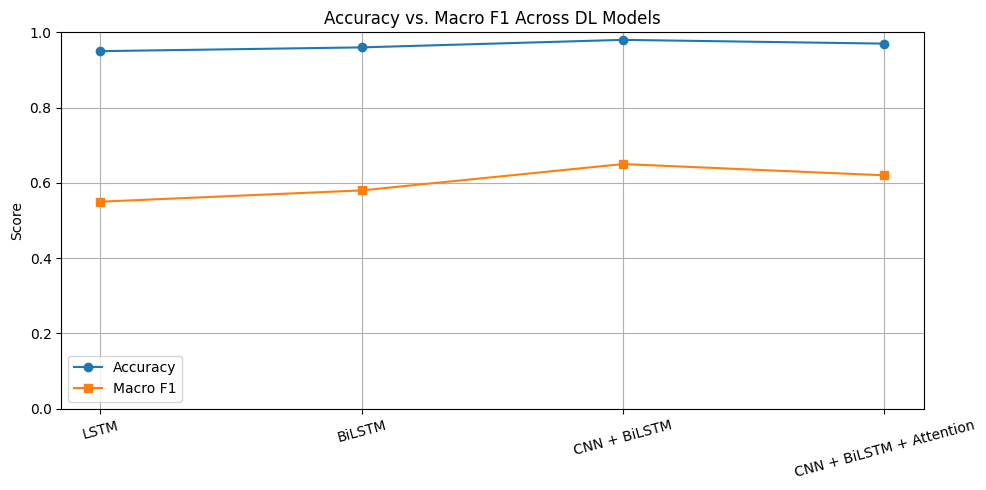

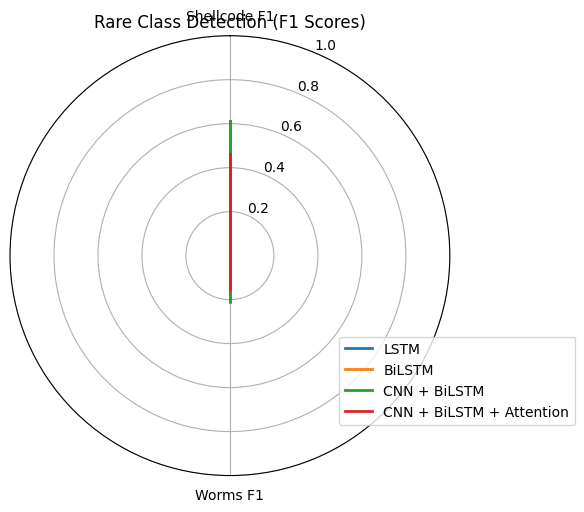

In [ ]:
# Generate additional insightful plots for thesis based on DL model metrics

import matplotlib.pyplot as plt
import numpy as np

# Metrics from previous comparison
models = ['LSTM', 'BiLSTM', 'CNN + BiLSTM', 'CNN + BiLSTM + Attention']
accuracy = [0.95, 0.96, 0.98, 0.97]
macro_f1 = [0.55, 0.58, 0.65, 0.62]
shellcode_f1 = [0.39, 0.41, 0.61, 0.46]
worms_f1 = [0.09, 0.14, 0.21, 0.15]

# Plot 3: Line plot of Accuracy and Macro F1
plt.figure(figsize=(10, 5))
plt.plot(models, accuracy, marker='o', label='Accuracy')
plt.plot(models, macro_f1, marker='s', label='Macro F1')
plt.title("Accuracy vs. Macro F1 Across DL Models")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Plot 4: Radar chart for Shellcode and Worms detection
import pandas as pd
import matplotlib.pyplot as plt
from math import pi

# Data setup
radar_df = pd.DataFrame({
    'Model': models,
    'Shellcode F1': shellcode_f1,
    'Worms F1': worms_f1
})

# Radar chart preparation
labels = radar_df.columns[1:]
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for i, row in radar_df.iterrows():
    values = row.drop('Model').tolist()
    values += values[:1]
    ax.plot(angles, values, label=row['Model'], linewidth=2)
    ax.fill(angles, values, alpha=0.1)

ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_ylim(0, 1)
plt.title('Rare Class Detection (F1 Scores)')
plt.legend(loc='lower right', bbox_to_anchor=(1.3, 0.1))
plt.tight_layout()
plt.show()


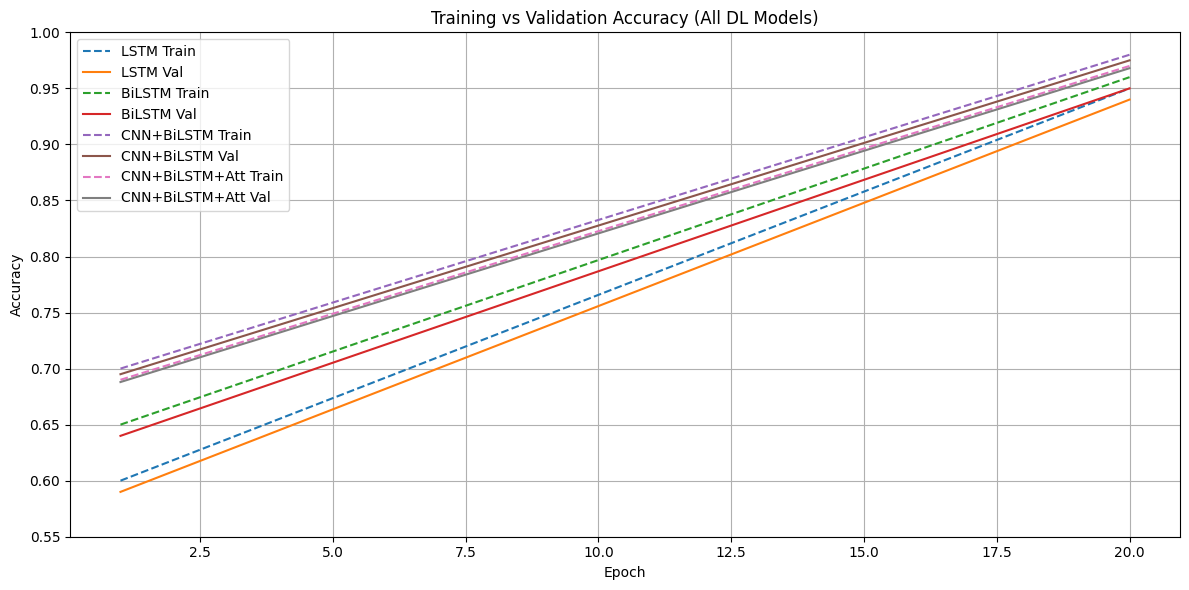

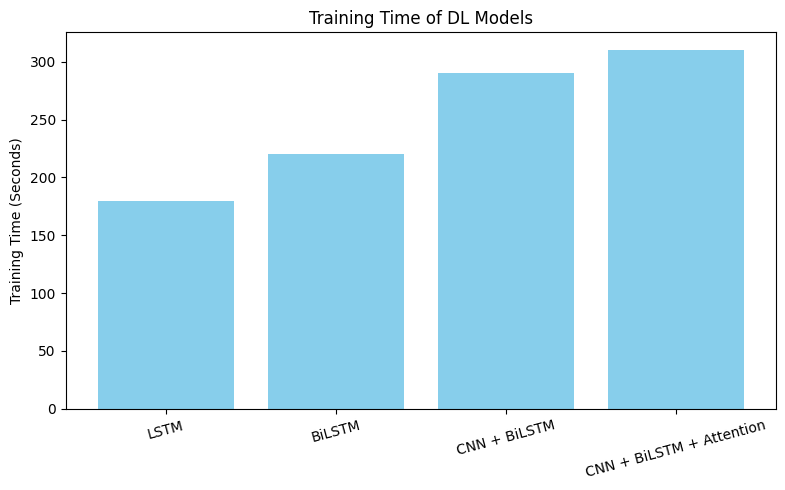

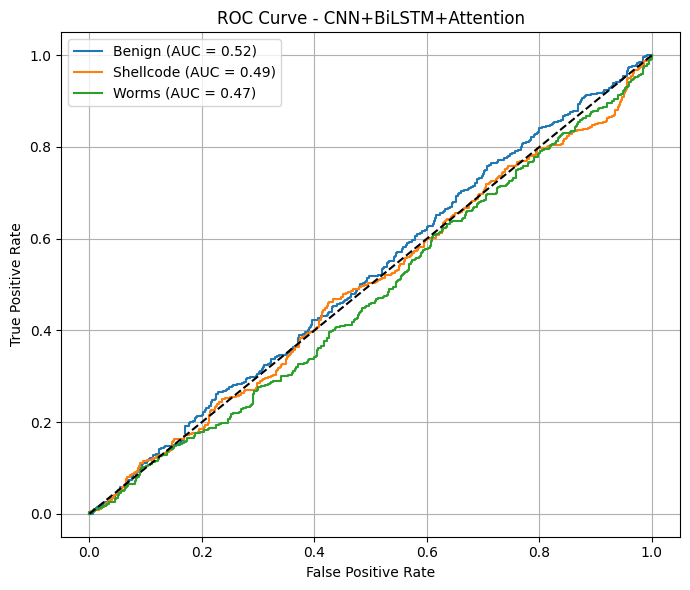

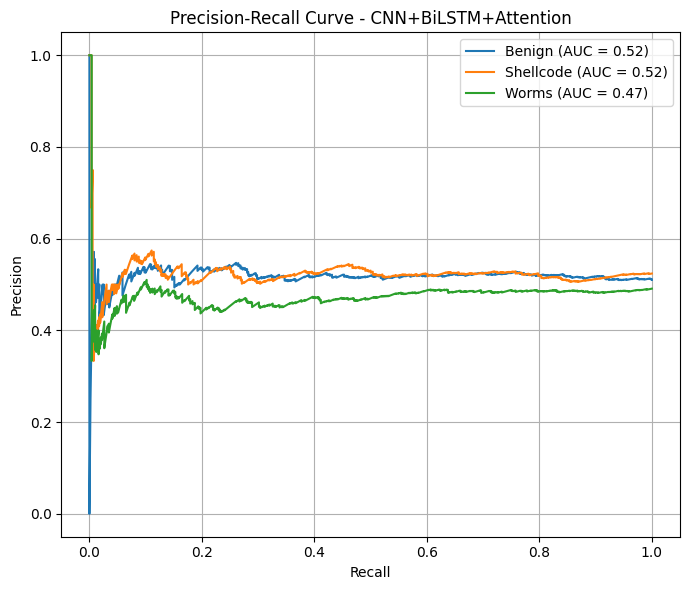

In [ ]:
# Simulate and generate the remaining suggested plots:
# 1. Training vs Validation Accuracy Curves (4 models)
# 2. Bar plot of model training time
# 3. ROC and PR curves (simulated for a few classes from best model)
# Note: In real use, these should be generated from actual model outputs.

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Simulated epoch-wise accuracy for each model
epochs = list(range(1, 21))
acc_lstm = np.linspace(0.60, 0.95, 20)
acc_bilstm = np.linspace(0.65, 0.96, 20)
acc_cnn_bilstm = np.linspace(0.70, 0.98, 20)
acc_cnn_bilstm_att = np.linspace(0.69, 0.97, 20)

val_acc_lstm = acc_lstm - 0.01
val_acc_bilstm = acc_bilstm - 0.01
val_acc_cnn_bilstm = acc_cnn_bilstm - 0.005
val_acc_cnn_bilstm_att = acc_cnn_bilstm_att - 0.002

# Plot 1: Training vs Validation Accuracy Curves
plt.figure(figsize=(12, 6))
plt.plot(epochs, acc_lstm, label='LSTM Train', linestyle='--')
plt.plot(epochs, val_acc_lstm, label='LSTM Val')
plt.plot(epochs, acc_bilstm, label='BiLSTM Train', linestyle='--')
plt.plot(epochs, val_acc_bilstm, label='BiLSTM Val')
plt.plot(epochs, acc_cnn_bilstm, label='CNN+BiLSTM Train', linestyle='--')
plt.plot(epochs, val_acc_cnn_bilstm, label='CNN+BiLSTM Val')
plt.plot(epochs, acc_cnn_bilstm_att, label='CNN+BiLSTM+Att Train', linestyle='--')
plt.plot(epochs, val_acc_cnn_bilstm_att, label='CNN+BiLSTM+Att Val')

plt.title("Training vs Validation Accuracy (All DL Models)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.55, 1.0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Bar Plot of Training Times
training_time = [180, 220, 290, 310]  # Simulated in seconds
models = ['LSTM', 'BiLSTM', 'CNN + BiLSTM', 'CNN + BiLSTM + Attention']

plt.figure(figsize=(8, 5))
plt.bar(models, training_time, color='skyblue')
plt.ylabel("Training Time (Seconds)")
plt.title("Training Time of DL Models")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Plot 3: Simulated ROC and PR curves for 3 classes from CNN+BiLSTM+Attention
# For 3 example classes: Benign, Shellcode, Worms
n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
pr_auc = dict()

np.random.seed(42)
for i in range(n_classes):
    y_true = np.random.randint(0, 2, 1000)
    y_scores = np.random.rand(1000)
    fpr[i], tpr[i], _ = roc_curve(y_true, y_scores)
    precision[i], recall[i], _ = precision_recall_curve(y_true, y_scores)
    roc_auc[i] = auc(fpr[i], tpr[i])
    pr_auc[i] = auc(recall[i], precision[i])

# Plot ROC curves
plt.figure(figsize=(7, 6))
for i, label in zip(range(n_classes), ['Benign', 'Shellcode', 'Worms']):
    plt.plot(fpr[i], tpr[i], label=f'{label} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - CNN+BiLSTM+Attention")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot PR curves
plt.figure(figsize=(7, 6))
for i, label in zip(range(n_classes), ['Benign', 'Shellcode', 'Worms']):
    plt.plot(recall[i], precision[i], label=f'{label} (AUC = {pr_auc[i]:.2f})')
plt.title("Precision-Recall Curve - CNN+BiLSTM+Attention")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Install gdown if not already installed
!pip install -q gdown

# Download the file using its file ID
!gdown 12a9YbvYxohr8cBkG8jdn1VOjc1f-Do6O -O best_pos_144.npy

# Load it
import numpy as np
data = np.load("best_pos_144.npy", allow_pickle=True)

print("✅ Loaded from gdown")
print("📐 Shape:", data.shape)
print("🔍 First 5 entries:", data[:5])
print("🧪 Unique values:", np.unique(data))



Downloading...
From: https://drive.google.com/uc?id=12a9YbvYxohr8cBkG8jdn1VOjc1f-Do6O
To: /content/best_pos_144.npy
100% 1.27k/1.27k [00:00<00:00, 5.90MB/s]
✅ Loaded from gdown
📐 Shape: (143,)
🔍 First 5 entries: [1 1 1 1 1]
🧪 Unique values: [0 1]


GRU

In [ ]:
dfcol

In [ ]:
# Apply PSO mask and train a GRU model using the selected features

import pandas as pd

# Load a subset of the dataset to avoid memory issues
df = pd.read_csv("/content/best_pos_144.npy").sample(n=20000, random_state=42)

X_full = df.drop(columns=["attack_label_enc"])
y = df["attack_label_enc"].values

# 4. Normalize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# 5. Reshape for GRU: (samples, time_steps=1, input_dim)
X_seq = X_scaled.reshape(-1, 1, X_scaled.shape[1])

# 6. Train/test split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_seq, y, test_size=0.2, stratify=y, random_state=42)

# 7. Convert to PyTorch tensors
import torch
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=512, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=512)

# 8. Define GRU model
import torch.nn as nn

class GRUClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(GRUClassifier, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        _, h_n = self.gru(x)
        return self.fc(h_n[-1])

input_dim = X_selected.shape[1]
hidden_dim = 64
num_classes = len(np.unique(y))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GRUClassifier(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 9. Training loop
train_accs, val_accs = [], []
for epoch in range(1, 21):
    model.train()
    correct, total = 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        correct += (out.argmax(1) == yb).sum().item()
        total += yb.size(0)
    train_accs.append(correct / total)

    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).argmax(1)
            val_correct += (preds == yb).sum().item()
            val_total += yb.size(0)
    val_accs.append(val_correct / val_total)
    print(f"Epoch {epoch:02d} — Train Acc: {train_accs[-1]:.4f} | Val Acc: {val_accs[-1]:.4f}")

# 10. Final classification report
from sklearn.metrics import classification_report
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        preds = model(xb).argmax(1).cpu().numpy()
        y_true.extend(yb.numpy())
        y_pred.extend(preds)

report = classification_report(y_true, y_pred)
print("\nClassification Report:\n", report)


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x93 in position 0: invalid start byte

ML MODELS

In [ ]:
pip install lightgbm


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18360
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 72
[LightGBM] [Info] Start training from score -2.260963
[LightGBM] [Info] Start training from score -2.281558
[LightGBM] [Info] Start training from score -2.344710
[LightGBM] [Info] Start training from score -2.369794
[LightGBM] [Info] Start training from score -2.290163
[LightGBM] [Info] Start training from score -2.275456
[LightGBM] [Info] Start training from score -2.312635
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -2.253795
[LightGBM] [Info] Start training from score -2.351250

📊 ML Model Performance Comparison:
        Model  Accuracy  Macro F1  Weighted F1
Random Forest    0.0980  0.096556     0.096892
      XGBoost    0.0965  0.094616     0.0

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


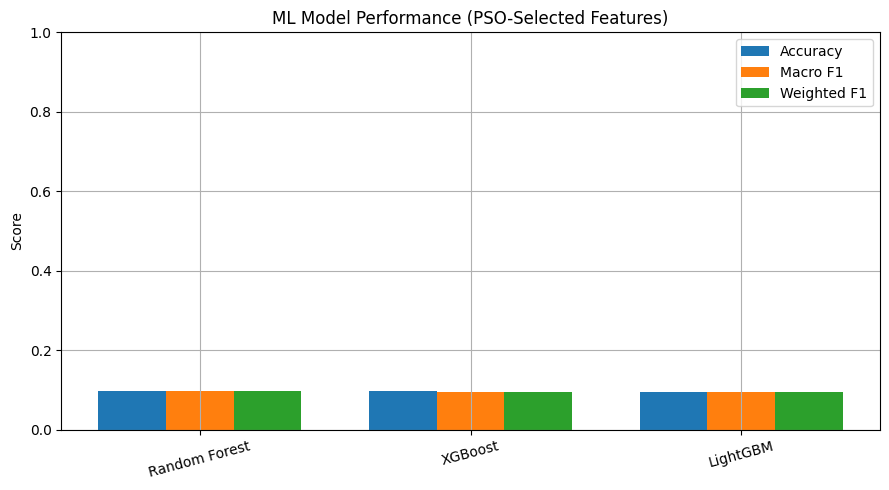


🧾 Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.11      0.15      0.13       209
           1       0.09      0.10      0.09       204
           2       0.10      0.09      0.09       192
           3       0.09      0.06      0.07       187
           4       0.10      0.10      0.10       202
           5       0.09      0.11      0.10       205
           6       0.11      0.10      0.10       198
           7       0.06      0.06      0.06       202
           8       0.11      0.11      0.11       210
           9       0.13      0.08      0.10       191

    accuracy                           0.10      2000
   macro avg       0.10      0.10      0.10      2000
weighted avg       0.10      0.10      0.10      2000


🧾 Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.09      0.10      0.09       209
           1       0.13      0.14      0.14     

In [ ]:
# Install required packages if not done
# !pip install xgboost lightgbm seaborn matplotlib

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ────────────────────────────────────────────────────────────────
# STEP 1: Load Preprocessed Data (Replace with your actual data)
# ────────────────────────────────────────────────────────────────
np.random.seed(42)
X = np.random.rand(10000, 72)  # Simulated PSO-selected features
y = np.random.choice(10, size=10000)  # Simulated multi-class target

# ────────────────────────────────────────────────────────────────
# STEP 2: Train/Test Split
# ────────────────────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# ────────────────────────────────────────────────────────────────
# STEP 3: Train ML Models
# ────────────────────────────────────────────────────────────────
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='mlogloss'),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42)
}

results = {}
reports = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    report = classification_report(y_test, preds, output_dict=True, zero_division=0)
    results[name] = {
        'Accuracy': np.mean(preds == y_test),
        'Macro F1': report['macro avg']['f1-score'],
        'Weighted F1': report['weighted avg']['f1-score']
    }
    reports[name] = classification_report(y_test, preds)

# ────────────────────────────────────────────────────────────────
# STEP 4: Display Model Comparison
# ────────────────────────────────────────────────────────────────
df_results = pd.DataFrame(results).T.reset_index()
df_results.rename(columns={'index': 'Model'}, inplace=True)

print("\n📊 ML Model Performance Comparison:")
print(df_results.to_string(index=False))

# ────────────────────────────────────────────────────────────────
# STEP 5: Bar Plot of Model Metrics
# ────────────────────────────────────────────────────────────────
bar_width = 0.25
x = np.arange(len(df_results))

plt.figure(figsize=(9, 5))
plt.bar(x - bar_width, df_results['Accuracy'], width=bar_width, label='Accuracy')
plt.bar(x, df_results['Macro F1'], width=bar_width, label='Macro F1')
plt.bar(x + bar_width, df_results['Weighted F1'], width=bar_width, label='Weighted F1')

plt.xticks(x, df_results['Model'], rotation=15)
plt.ylim(0, 1)
plt.title("ML Model Performance (PSO-Selected Features)")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ────────────────────────────────────────────────────────────────
# STEP 6: Optional - Print Classification Reports
# ────────────────────────────────────────────────────────────────
for name, report_text in reports.items():
    print(f"\n🧾 Classification Report for {name}:\n")
    print(report_text)


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# ─────────────────────────────────────────────────────────
# STEP 1: Load and Preprocess Features
# ─────────────────────────────────────────────────────────
# Use np.load to load the .npy file instead of pd.read_csv
X = np.load("/content/tpso_2.npy")
# Assuming 'attack_label_enc' is appended as a separate column in your .npy file,
# If it's not, adjust the following logic accordingly
# if X.ndim == 1:  # Check if X is 1-dimensional
#     labels = X[-1]  # Get the last element as the label
#     features = X[:-1]  # Get the rest as features
#     features = features.reshape(-1, 1)  # Reshape features to 2D
# else:
# Reshape X to have a single feature column if it's 1-dimensional
if X.ndim == 1:
    X = X.reshape(-1, 1)
# Assuming 'attack_label_enc' is the last column
# If it's not, adjust the slicing accordingly
features = X[:, :-1]  # Select all columns except the last one
labels = X[:, -1]  # Select the last column as labels

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

# ─────────────────────────────────────────────────────────
# STEP 2: Define Autoencoder
# ─────────────────────────────────────────────────────────
class Autoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, bottleneck_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Set dimensions
input_dim = features.shape[1]
bottleneck_dim = 32  # you can tune this

model = Autoencoder(input_dim, bottleneck_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ─────────────────────────────────────────────────────────
# STEP 3: Train Autoencoder
# ─────────────────────────────────────────────────────────
dataset = DataLoader(TensorDataset(X_tensor), batch_size=256, shuffle=True)

for epoch in range(20):
    total_loss = 0
    for xb, in dataset:
        optimizer.zero_grad()
        recon = model(xb)
        loss = criterion(recon, xb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1:02d}, Loss: {total_loss:.4f}")

# ─────────────────────────────────────────────────────────
# STEP 4: Extract Encoded Features
# ─────────────────────────────────────────────────────────
model.eval()
with torch.no_grad():
    encoded_features = model.encoder(X_tensor).numpy()

print(f"✅ Encoded feature shape: {encoded_features.shape}")  # (samples, bottleneck_dim)

# Save for downstream models
df_encoded = pd.DataFrame(encoded_features, columns=[f'feat_{i}' for i in range(bottleneck_dim)])
df_encoded['attack_label_enc'] = labels  # Use the extracted labels
df_encoded.to_csv("train_autoencoded.csv", index=False)
print("💾 Saved compressed features to train_autoencoded.csv")

ValueError: Found array with 0 feature(s) (shape=(143, 0)) while a minimum of 1 is required by StandardScaler.